In [1]:
import sys
import os
import matplotlib.pyplot as plt
import warnings
import matplotlib.ticker as ticker
import numpy as np
import torch

# Disable cudnn
from torch.backends import cudnn
cudnn.enabled = False

from spice import pipeline_rnn_autoreg
from spice.resources.old_rnn import RLRNN_dezfouli2019, RLRNN_eckstein2022 # Get predefined RNN architectures

# Setting seeds for reproducibility
np.random.seed(186)
torch.manual_seed(186)

Library setup is valid. All keys and features appear in the provided list of features.
Library setup is valid. All keys and features appear in the provided list of features.
Library setup is valid. All keys and features appear in the provided list of features.
Library setup is valid. All keys and features appear in the provided list of features.
Library setup is valid. All keys and features appear in the provided list of features.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Set most important arguments:
dataset = 'eckstein2022'  # 'eckstein2022' or 'dezfouli2019'
epochs = 8192
metaopt_type = 'imaml'

# AWD
lambda_awd = 1e-1

# iMAML
initial_reg_param = 1e-4
outer_lr = 1e-1

# Fixed model path name
if metaopt_type == 'awd':
    path_model = f'params/{dataset}/AWD_{dataset}_ep{epochs}_lawd-{lambda_awd:.0g}_rnn.pkl'
elif metaopt_type == 'imaml':
    path_model = f'params/{dataset}/iMAML_{dataset}_ep{epochs}_metalr-{outer_lr:.0g}_in-{initial_reg_param:.0g}_rnn.pkl'
else:
    raise ValueError('metaopt_type must be either "awd" or "imaml"')

# SPICE config
path_data = f'../data/{dataset}/{dataset}.csv'
additional_inputs = None

if dataset == 'eckstein2022':
    train_test_ratio = 0.8
    class_rnn = RLRNN_eckstein2022
elif dataset == 'dezfouli2019':
    train_test_ratio = [3, 6, 9]
    class_rnn = RLRNN_dezfouli2019
else:
    raise ValueError('Dataset must be either "eckstein2022" or "dezfouli2019"')


In [3]:
model, _, histories = pipeline_rnn_autoreg.main(
    
    dropout=0.25,
    train_test_ratio=train_test_ratio,
    
    # general training parameters
    checkpoint=False,
    epochs=epochs, # <- 2^16
    scheduler=True,
    learning_rate=1e-2, # 1e-2

    # Meta-optimization parameters
    metaopt_type=metaopt_type,

    lambda_awd=lambda_awd,

    meta_update_interval=50,
    inner_steps=3,
    outer_lr=outer_lr,
    hypergradient_steps=3,
    initial_reg_param=initial_reg_param,

    # hand-picked params
    n_steps=-1,
    embedding_size=32,
    batch_size=-1,
    sequence_length=-1,
    bagging=True,
    
    class_rnn=class_rnn,
    model=path_model,
    data=path_data,
    additional_inputs_data=additional_inputs,
    
    # synthetic dataset parameters
    n_sessions=128,
    n_trials=200,
    sigma=0.2,
    beta_reward=3.,
    alpha_reward=0.25,
    alpha_penalty=0.5,
    forget_rate=0.,
    confirmation_bias=0.,
    beta_choice=0.,
    alpha_choice=1.,
    counterfactual=False,
    alpha_counterfactual=0.,
    
    save_checkpoints=True,
    analysis=False,
    participant_id=0,
    )

Cuda available: False
Setup of the RNN model complete.
Training the RNN...
Using Implicit MAML (iMAML) for meta-optimization.
Epoch 1/8192 --- L(Train): 0.6725; L(Val): 0.6620; Reg Param: 0.0001; Time: 1.03
Epoch 2/8192 --- L(Train): 0.6588; L(Val): 0.6475; Reg Param: 0.0001; Time: 0.68
Epoch 3/8192 --- L(Train): 0.6486; L(Val): 0.6311; Reg Param: 0.0001; Time: 0.66
Epoch 4/8192 --- L(Train): 0.6334; L(Val): 0.6133; Reg Param: 0.0001; Time: 1.02
Epoch 5/8192 --- L(Train): 0.6172; L(Val): 0.5951; Reg Param: 0.0001; Time: 2.27
Epoch 6/8192 --- L(Train): 0.6002; L(Val): 0.5775; Reg Param: 0.0001; Time: 1.09
Epoch 7/8192 --- L(Train): 0.5838; L(Val): 0.5613; Reg Param: 0.0001; Time: 1.39
Epoch 8/8192 --- L(Train): 0.5653; L(Val): 0.5467; Reg Param: 0.0001; Time: 0.98
Epoch 9/8192 --- L(Train): 0.5530; L(Val): 0.5338; Reg Param: 0.0001; Time: 0.87
Epoch 10/8192 --- L(Train): 0.5397; L(Val): 0.5228; Reg Param: 0.0001; Time: 0.73
Epoch 11/8192 --- L(Train): 0.5224; L(Val): 0.5136; Reg Param: 

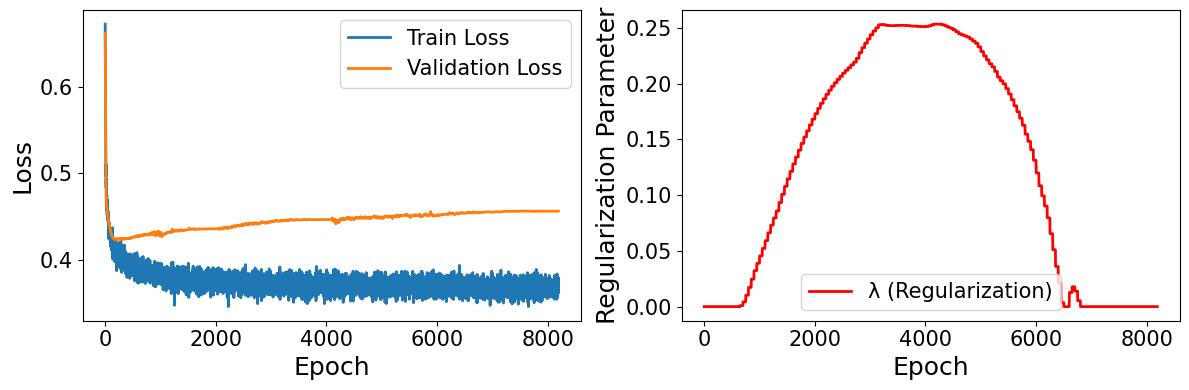

In [4]:
train_loss_history, val_loss_history, reg_history = histories
plot_epochs = np.arange(1, len(train_loss_history) + 1)

plt.figure(figsize=(12, 4))

# Plot 1: Losses
plt.subplot(1, 2, 1)
plt.plot(plot_epochs, train_loss_history, label="Train Loss", linewidth=2)
plt.plot(plot_epochs, val_loss_history, label="Validation Loss", linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)


if metaopt_type == 'awd':
    # Subplot 2: lambda weight decay
    plt.subplot(1,2,2)
    plt.plot(plot_epochs, reg_history, label='λ weight decay')
    plt.xlabel('Epoch')
    plt.ylabel('λ weight decay')
    plt.legend()
    plt.grid(True, alpha=0.3)
elif metaopt_type == 'imaml':
    # Plot 2: Regularization parameter
    plt.subplot(1, 2, 2)
    plt.plot(plot_epochs, reg_history, label="λ (Regularization)", linewidth=2, color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Regularization Parameter')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [5]:
# Set Configs
from spice.resources import sindy_utils
sindy_config = sindy_utils.SindyConfig_eckstein2022 if dataset == 'eckstein2022' else sindy_utils.SindyConfig_dezfouli2019

Library setup is valid. All keys and features appear in the provided list of features.
[tensor(0.), tensor(1.)]


  0%|          | 1/306 [00:03<19:36,  3.86s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  1%|          | 2/306 [00:07<19:52,  3.92s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 19:23:52,851] A new study created in memory with name: no-name-9f173e52-f107-4254-990a-24f44fdf63c2


Likelihoods before optuna fitting: RNN = 0.73659; SPICE =  0.001; Diff = 0.73559
Using optuna to find a better set of pysindy parameters for participant 2...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [00:15<19:52,  3.92s/it]

[I 2025-09-26 19:23:56,563] Trial 0 finished with value: 0.03693444597873068 and parameters: {'optimizer_alpha': 0.029181886841555208, 'optimizer_threshold': 0.03133617928990515}. Best is trial 0 with value: 0.03693444597873068.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [00:19<19:52,  3.92s/it]                                                       

[I 2025-09-26 19:24:00,287] Trial 1 finished with value: 0.3254764799240505 and parameters: {'optimizer_alpha': 0.08588918003386042, 'optimizer_threshold': 0.018567398597629608}. Best is trial 0 with value: 0.03693444597873068.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [00:22<19:52,  3.92s/it]                                                       

[I 2025-09-26 19:24:03,981] Trial 2 finished with value: 0.22995092823810664 and parameters: {'optimizer_alpha': 0.011328811920844149, 'optimizer_threshold': 0.020021179538058795}. Best is trial 0 with value: 0.03693444597873068.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [00:26<19:52,  3.92s/it]                                                        

[I 2025-09-26 19:24:07,777] Trial 3 finished with value: 6.139994160941784 and parameters: {'optimizer_alpha': 0.5570699585058646, 'optimizer_threshold': 0.054106929724248055}. Best is trial 0 with value: 0.03693444597873068.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [00:30<19:52,  3.92s/it]                                                        

[I 2025-09-26 19:24:11,507] Trial 4 finished with value: 1.6210041253082936 and parameters: {'optimizer_alpha': 0.5120525596199077, 'optimizer_threshold': 0.01463333250941187}. Best is trial 0 with value: 0.03693444597873068.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [00:34<19:52,  3.92s/it]                                                        

[I 2025-09-26 19:24:15,263] Trial 5 finished with value: 0.02754985657942117 and parameters: {'optimizer_alpha': 0.3045341514088266, 'optimizer_threshold': 0.1329295308197849}. Best is trial 5 with value: 0.02754985657942117.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [00:37<19:52,  3.92s/it]                                                        

[I 2025-09-26 19:24:18,968] Trial 6 finished with value: 1.2239217754144178 and parameters: {'optimizer_alpha': 0.5517791724965335, 'optimizer_threshold': 0.017496434149276652}. Best is trial 5 with value: 0.02754985657942117.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [00:41<19:52,  3.92s/it]                                                        

[I 2025-09-26 19:24:22,670] Trial 7 finished with value: 0.29213229539007146 and parameters: {'optimizer_alpha': 0.5845671396534442, 'optimizer_threshold': 0.15707196985694674}. Best is trial 5 with value: 0.02754985657942117.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [00:45<19:52,  3.92s/it]                                                        

[I 2025-09-26 19:24:26,466] Trial 8 finished with value: 1.663746205369856 and parameters: {'optimizer_alpha': 0.015855695400094436, 'optimizer_threshold': 0.06466763486649414}. Best is trial 5 with value: 0.02754985657942117.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [00:49<19:52,  3.92s/it]                                                        

[I 2025-09-26 19:24:30,158] Trial 9 finished with value: 0.02652041656944902 and parameters: {'optimizer_alpha': 0.02655154572599139, 'optimizer_threshold': 0.1711698136432557}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [00:52<19:52,  3.92s/it]                                                         

[I 2025-09-26 19:24:33,877] Trial 10 finished with value: 7.924140778206735 and parameters: {'optimizer_alpha': 0.05356578451156243, 'optimizer_threshold': 0.08925062741458041}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [00:56<19:52,  3.92s/it]                                                         

[I 2025-09-26 19:24:37,680] Trial 11 finished with value: 2.509241004992356 and parameters: {'optimizer_alpha': 0.18554222512269034, 'optimizer_threshold': 0.19753890149454362}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [01:00<19:52,  3.92s/it]                                                         

[I 2025-09-26 19:24:41,415] Trial 12 finished with value: 3.097953736919227 and parameters: {'optimizer_alpha': 0.16888812115855026, 'optimizer_threshold': 0.11178893119608402}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [01:04<19:52,  3.92s/it]                                                         

[I 2025-09-26 19:24:45,130] Trial 13 finished with value: 1.1135401184739258 and parameters: {'optimizer_alpha': 0.23550311108025654, 'optimizer_threshold': 0.12121869414653905}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [01:07<19:52,  3.92s/it]                                                         

[I 2025-09-26 19:24:48,842] Trial 14 finished with value: 0.348964201881292 and parameters: {'optimizer_alpha': 0.037516664763483934, 'optimizer_threshold': 0.0736452301817795}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [01:11<19:52,  3.92s/it]                                                         

[I 2025-09-26 19:24:52,612] Trial 15 finished with value: 2.86819976486524 and parameters: {'optimizer_alpha': 0.09556928864251116, 'optimizer_threshold': 0.04083271342700444}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [01:15<19:52,  3.92s/it]                                                         

[I 2025-09-26 19:24:56,429] Trial 16 finished with value: 0.3484391561464697 and parameters: {'optimizer_alpha': 0.32766631482815856, 'optimizer_threshold': 0.010277301115642257}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [01:19<19:52,  3.92s/it]                                                         

[I 2025-09-26 19:25:00,177] Trial 17 finished with value: 1.161195239726963 and parameters: {'optimizer_alpha': 0.024615112825415564, 'optimizer_threshold': 0.17163723882424115}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [01:22<19:52,  3.92s/it]                                                         

[I 2025-09-26 19:25:03,891] Trial 18 finished with value: 1.0484875424896976 and parameters: {'optimizer_alpha': 0.925871372946551, 'optimizer_threshold': 0.125539717035965}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [01:26<19:52,  3.92s/it]                                                         

[I 2025-09-26 19:25:07,689] Trial 19 finished with value: 0.13195135523461254 and parameters: {'optimizer_alpha': 0.05478375096634531, 'optimizer_threshold': 0.09240144290488832}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [01:30<19:52,  3.92s/it]                                                         

[I 2025-09-26 19:25:11,422] Trial 20 finished with value: 1.0560054754070674 and parameters: {'optimizer_alpha': 0.29785254176560333, 'optimizer_threshold': 0.03145492123250785}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [01:34<19:52,  3.92s/it]                                                         

[I 2025-09-26 19:25:15,196] Trial 21 finished with value: 1.1431719002842209 and parameters: {'optimizer_alpha': 0.02285517627758202, 'optimizer_threshold': 0.03489689488243802}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [01:37<19:52,  3.92s/it]                                                         

[I 2025-09-26 19:25:18,921] Trial 22 finished with value: 0.6806882176988525 and parameters: {'optimizer_alpha': 0.034900718611162014, 'optimizer_threshold': 0.027854429618051433}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [01:41<19:52,  3.92s/it]                                                         

[I 2025-09-26 19:25:22,627] Trial 23 finished with value: 0.6323023921272876 and parameters: {'optimizer_alpha': 0.06311224928523683, 'optimizer_threshold': 0.051730764454739724}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [01:45<19:52,  3.92s/it]                                                         

[I 2025-09-26 19:25:26,418] Trial 24 finished with value: 2.191567010357989 and parameters: {'optimizer_alpha': 0.010137608442413931, 'optimizer_threshold': 0.025585180050610192}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [01:49<19:52,  3.92s/it]                                                         

[I 2025-09-26 19:25:30,147] Trial 25 finished with value: 1.5234041878769482 and parameters: {'optimizer_alpha': 0.1464503584417158, 'optimizer_threshold': 0.1637250338101879}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [01:52<19:52,  3.92s/it]                                                         

[I 2025-09-26 19:25:33,900] Trial 26 finished with value: 5.599924130460373 and parameters: {'optimizer_alpha': 0.01782059406034347, 'optimizer_threshold': 0.04105727968259761}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [01:56<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:25:37,623] Trial 27 finished with value: 0.7553809413770385 and parameters: {'optimizer_alpha': 0.03503665159032533, 'optimizer_threshold': 0.08884731968586462}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [02:00<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:25:41,419] Trial 28 finished with value: 1.8785370836746313 and parameters: {'optimizer_alpha': 0.11185886449713478, 'optimizer_threshold': 0.13934918583935105}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [02:04<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:25:45,293] Trial 29 finished with value: 2.4683671638536495 and parameters: {'optimizer_alpha': 0.06871591767552208, 'optimizer_threshold': 0.06807786910688898}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [02:08<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:25:49,024] Trial 30 finished with value: 0.8688525081918252 and parameters: {'optimizer_alpha': 0.04273060696634165, 'optimizer_threshold': 0.023425759431246695}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [02:11<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:25:52,787] Trial 31 finished with value: 2.0664141078445213 and parameters: {'optimizer_alpha': 0.02667406008606806, 'optimizer_threshold': 0.09573608276139346}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [02:15<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:25:56,542] Trial 32 finished with value: 0.03597654633071631 and parameters: {'optimizer_alpha': 0.0495722135531153, 'optimizer_threshold': 0.19921290112860088}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [02:19<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:26:00,294] Trial 33 finished with value: 0.12270111717538293 and parameters: {'optimizer_alpha': 0.016169090014754917, 'optimizer_threshold': 0.19471850077973285}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [02:23<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:26:04,036] Trial 34 finished with value: 1.2791092148331802 and parameters: {'optimizer_alpha': 0.0728692406462825, 'optimizer_threshold': 0.14566237021113054}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [02:26<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:26:07,793] Trial 35 finished with value: 0.09875285468414297 and parameters: {'optimizer_alpha': 0.045512674307725404, 'optimizer_threshold': 0.19877407467730318}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [02:30<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:26:11,639] Trial 36 finished with value: 1.30018968228235 and parameters: {'optimizer_alpha': 0.02922228787896314, 'optimizer_threshold': 0.10910660420824712}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [02:34<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:26:15,379] Trial 37 finished with value: 0.805134527687051 and parameters: {'optimizer_alpha': 0.0209280576688896, 'optimizer_threshold': 0.01792266985267169}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [02:38<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:26:19,126] Trial 38 finished with value: 0.6632237787731704 and parameters: {'optimizer_alpha': 0.12307540364621566, 'optimizer_threshold': 0.050376724919692466}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [02:41<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:26:22,858] Trial 39 finished with value: 2.0397200124772557 and parameters: {'optimizer_alpha': 0.08726666136495466, 'optimizer_threshold': 0.1648996071546497}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [02:45<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:26:26,614] Trial 40 finished with value: 0.10744865806263658 and parameters: {'optimizer_alpha': 0.012964162859199524, 'optimizer_threshold': 0.14188063597782108}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [02:49<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:26:30,362] Trial 41 finished with value: 4.261334079953746 and parameters: {'optimizer_alpha': 0.044383838940783134, 'optimizer_threshold': 0.19495300636780394}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [02:53<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:26:34,191] Trial 42 finished with value: 1.4176193948221012 and parameters: {'optimizer_alpha': 0.05349036556467176, 'optimizer_threshold': 0.17648669719692325}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [02:57<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:26:38,015] Trial 43 finished with value: 0.3066726069024694 and parameters: {'optimizer_alpha': 0.030740653768653384, 'optimizer_threshold': 0.13072021032134828}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [03:00<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:26:41,753] Trial 44 finished with value: 0.03221614190097406 and parameters: {'optimizer_alpha': 0.045315571675615604, 'optimizer_threshold': 0.19913681273134207}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [03:04<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:26:45,624] Trial 45 finished with value: 0.21861263969710965 and parameters: {'optimizer_alpha': 0.38630952043399786, 'optimizer_threshold': 0.1103128266791187}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [03:08<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:26:49,329] Trial 46 finished with value: 0.181461883775567 and parameters: {'optimizer_alpha': 0.0123589111239862, 'optimizer_threshold': 0.15311501432250912}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [03:12<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:26:53,238] Trial 47 finished with value: 0.7376104329981926 and parameters: {'optimizer_alpha': 0.018836044427649603, 'optimizer_threshold': 0.18012097587598566}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  1%|          | 2/306 [03:15<19:52,  3.92s/it]                                                          

[I 2025-09-26 19:26:56,981] Trial 48 finished with value: 0.6243934445104888 and parameters: {'optimizer_alpha': 0.23085764925129681, 'optimizer_threshold': 0.014876889376682544}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
Best trial: 9. Best value: 0.0265204: 100%|██████████| 50/50 [03:07<00:00,  3.76s/it, 187.87/600 seconds]


[I 2025-09-26 19:27:00,723] Trial 49 finished with value: 0.4284260913338949 and parameters: {'optimizer_alpha': 0.6771115726000057, 'optimizer_threshold': 0.02074915144257854}. Best is trial 9 with value: 0.02652041656944902.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  1%|          | 3/306 [03:23<7:41:50, 91.46s/it]

Likelihoods after optuna fitting: RNN = 0.73659; SPICE =  0.001 -> 0.03796, Diff = 0.73559 -> 0.69863


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  1%|▏         | 4/306 [03:27<4:46:27, 56.91s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  2%|▏         | 5/306 [03:31<3:09:43, 37.82s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 19:27:16,529] A new study created in memory with name: no-name-0f1cb6af-df71-4e12-a968-d88bbcf661bd


Likelihoods before optuna fitting: RNN = 0.63025; SPICE =  0.49597; Diff = 0.13429
Using optuna to find a better set of pysindy parameters for participant 5...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
  2%|▏         | 5/306 [03:39<3:09:43, 37.82s/it]

[I 2025-09-26 19:27:20,231] Trial 0 finished with value: 0.23088157495446276 and parameters: {'optimizer_alpha': 0.2690044832206461, 'optimizer_threshold': 0.03911921273802997}. Best is trial 0 with value: 0.23088157495446276.


                                                 
  2%|▏         | 5/306 [03:42<3:09:43, 37.82s/it]                                                    

[I 2025-09-26 19:27:23,972] Trial 1 finished with value: 0.04432680413059169 and parameters: {'optimizer_alpha': 0.013968805231967576, 'optimizer_threshold': 0.1126197154201084}. Best is trial 1 with value: 0.04432680413059169.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
Best trial: 2. Best value: 0.00479635:   6%|▌         | 3/50 [00:11<02:56,  3.75s/it, 11.25/600 seconds]


[I 2025-09-26 19:27:27,782] Trial 2 finished with value: 0.004796352700066873 and parameters: {'optimizer_alpha': 0.7078929984501109, 'optimizer_threshold': 0.021626625056319734}. Best is trial 2 with value: 0.004796352700066873.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  2%|▏         | 6/306 [03:50<2:37:19, 31.47s/it]

Likelihoods after optuna fitting: RNN = 0.63025; SPICE =  0.49597 -> 0.62476, Diff = 0.13429 -> 0.00549


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 19:27:35,530] A new study created in memory with name: no-name-18f7ca8e-0d87-4871-90a5-c1968a45f0e4


Likelihoods before optuna fitting: RNN = 0.76951; SPICE =  nan; Diff = nan
Using optuna to find a better set of pysindy parameters for participant 6...


                                                 
Best trial: 0. Best value: 0.00122604:   2%|▏         | 1/50 [00:03<03:00,  3.69s/it, 3.69/600 seconds]


[I 2025-09-26 19:27:39,218] Trial 0 finished with value: 0.0012260410443092357 and parameters: {'optimizer_alpha': 0.2491457956285004, 'optimizer_threshold': 0.04920298349896315}. Best is trial 0 with value: 0.0012260410443092357.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  2%|▏         | 7/306 [04:01<2:04:08, 24.91s/it]

Likelihoods after optuna fitting: RNN = 0.76951; SPICE =  nan -> 0.76899, Diff = nan -> 0.00052


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  3%|▎         | 8/306 [04:05<1:30:46, 18.28s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  3%|▎         | 9/306 [04:10<1:08:26, 13.83s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  3%|▎         | 10/306 [04:14<53:15, 10.79s/it

Likelihoods before optuna fitting: RNN = 0.62238; SPICE =  0.00015; Diff = 0.62222
Using optuna to find a better set of pysindy parameters for participant 14...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
  5%|▍         | 14/306 [04:37<27:08,  5.58s/it]

[I 2025-09-26 19:28:18,691] Trial 0 finished with value: 0.036571924765877964 and parameters: {'optimizer_alpha': 0.038636066515144146, 'optimizer_threshold': 0.04818483863847977}. Best is trial 0 with value: 0.036571924765877964.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 1. Best value: 0.00455522:   4%|▍         | 2/50 [00:07<03:02,  3.80s/it, 7.60/600 seconds]


[I 2025-09-26 19:28:22,502] Trial 1 finished with value: 0.004555224018592727 and parameters: {'optimizer_alpha': 0.20148150714439583, 'optimizer_threshold': 0.02383735796744982}. Best is trial 1 with value: 0.004555224018592727.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  5%|▍         | 15/306 [04:45<41:20,  8.52s/it]

Likelihoods after optuna fitting: RNN = 0.62238; SPICE =  0.00015 -> 0.6188, Diff = 0.62222 -> 0.00358


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  6%|▌         | 17/306 [04:53<29:48,  6.19s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  6%|▌         | 18/306 [04:57<26:33,  5.53s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  6%|▌         | 19/306 [05:01<24:11,  5.06s/it]c

Likelihoods before optuna fitting: RNN = 0.84545; SPICE =  0.73452; Diff = 0.11092
Using optuna to find a better set of pysindy parameters for participant 20...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 0. Best value: 0.00278089:   2%|▏         | 1/50 [00:03<03:10,  3.88s/it, 3.88/600 seconds]


[I 2025-09-26 19:28:54,016] Trial 0 finished with value: 0.0027808874157089843 and parameters: {'optimizer_alpha': 0.1755341374333696, 'optimizer_threshold': 0.010432914786547974}. Best is trial 0 with value: 0.0027808874157089843.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  7%|▋         | 21/306 [05:16<32:14,  6.79s/it]

Likelihoods after optuna fitting: RNN = 0.84545; SPICE =  0.73452 -> 0.84044, Diff = 0.11092 -> 0.005


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  7%|▋         | 22/306 [05:20<28:21,  5.99s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  8%|▊         | 24/306 [05:28<23:14,  4.95s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  8%|▊         | 26/306 [05:36<20:49,  4.46s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 

Likelihoods before optuna fitting: RNN = 0.77788; SPICE =  0.00207; Diff = 0.77581
Using optuna to find a better set of pysindy parameters for participant 27...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
  9%|▉         | 27/306 [05:48<20:06,  4.33s/it]

[I 2025-09-26 19:29:29,977] Trial 0 finished with value: 0.027047224601278858 and parameters: {'optimizer_alpha': 0.01804875680972515, 'optimizer_threshold': 0.07885575576016647}. Best is trial 0 with value: 0.027047224601278858.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                      
  9%|▉         | 27/306 [05:52<20:06,  4.33s/it]                                                      

[W 2025-09-26 19:29:33,854] Trial 1 failed with parameters: {'optimizer_alpha': 0.35551570780908054, 'optimizer_threshold': 0.01092761449031574} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:29:33,858] Trial 1 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
  9%|▉         | 27/306 [05:56<20:06,  4.33s/it]                                                      

[I 2025-09-26 19:29:37,779] Trial 2 finished with value: 0.38443141407371134 and parameters: {'optimizer_alpha': 0.03787827313696689, 'optimizer_threshold': 0.013325288351375983}. Best is trial 0 with value: 0.027047224601278858.


                                                
Best trial: 3. Best value: 0.00941562:   8%|▊         | 4/50 [00:15<02:59,  3.89s/it, 15.57/600 seconds]


[I 2025-09-26 19:29:41,645] Trial 3 finished with value: 0.009415616947970891 and parameters: {'optimizer_alpha': 0.5555094204461598, 'optimizer_threshold': 0.1529874531261945}. Best is trial 3 with value: 0.009415616947970891.


  9%|▉         | 28/306 [06:04<47:04, 10.16s/it]

Likelihoods after optuna fitting: RNN = 0.77788; SPICE =  0.00207 -> 0.75198, Diff = 0.77581 -> 0.0259


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 19:29:49,624] A new study created in memory with name: no-name-527b971a-1c15-4228-99ae-fc4254050ed3


Likelihoods before optuna fitting: RNN = 0.81292; SPICE =  nan; Diff = nan
Using optuna to find a better set of pysindy parameters for participant 28...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
  9%|▉         | 28/306 [06:12<47:04, 10.16s/it]

[I 2025-09-26 19:29:53,420] Trial 0 finished with value: 0.03777713690331058 and parameters: {'optimizer_alpha': 0.7025286514214533, 'optimizer_threshold': 0.11172291753832898}. Best is trial 0 with value: 0.03777713690331058.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                      
  9%|▉         | 28/306 [06:16<47:04, 10.16s/it]                                                      

[W 2025-09-26 19:29:57,148] Trial 1 failed with parameters: {'optimizer_alpha': 0.049029477691613435, 'optimizer_threshold': 0.16710791201165284} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:29:57,153] Trial 1 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                      
  9%|▉         | 28/306 [06:20<47:04, 10.16s/it]                                                      

[W 2025-09-26 19:30:01,033] Trial 2 failed with parameters: {'optimizer_alpha': 0.23060915650840852, 'optimizer_threshold': 0.06390430336410544} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:30:01,038] Trial 2 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
  9%|▉         | 28/306 [06:23<47:04, 10.16s/it]                                                       

[W 2025-09-26 19:30:04,801] Trial 3 failed with parameters: {'optimizer_alpha': 0.04408159782124843, 'optimizer_threshold': 0.046384103310438} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:30:04,806] Trial 3 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
  9%|▉         | 28/306 [06:27<47:04, 10.16s/it]                                                       

[W 2025-09-26 19:30:08,518] Trial 4 failed with parameters: {'optimizer_alpha': 0.10854543304234905, 'optimizer_threshold': 0.014195166763438495} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:30:08,522] Trial 4 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
  9%|▉         | 28/306 [06:31<47:04, 10.16s/it]                                                       

[W 2025-09-26 19:30:12,284] Trial 5 failed with parameters: {'optimizer_alpha': 0.2377582190768235, 'optimizer_threshold': 0.020381571782686018} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:30:12,289] Trial 5 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
  9%|▉         | 28/306 [06:34<47:04, 10.16s/it]                                                       

[W 2025-09-26 19:30:16,008] Trial 6 failed with parameters: {'optimizer_alpha': 0.19036940298676303, 'optimizer_threshold': 0.06649812580815191} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:30:16,012] Trial 6 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
  9%|▉         | 28/306 [06:38<47:04, 10.16s/it]                                                       

[I 2025-09-26 19:30:19,746] Trial 7 finished with value: 0.012369413739874068 and parameters: {'optimizer_alpha': 0.020084718643709348, 'optimizer_threshold': 0.16487966502278845}. Best is trial 7 with value: 0.012369413739874068.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
  9%|▉         | 28/306 [06:42<47:04, 10.16s/it]                                                       

[W 2025-09-26 19:30:23,504] Trial 8 failed with parameters: {'optimizer_alpha': 0.04584533553031583, 'optimizer_threshold': 0.15364219206193439} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:30:23,509] Trial 8 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
  9%|▉         | 28/306 [06:46<47:04, 10.16s/it]                                                       

[W 2025-09-26 19:30:27,270] Trial 9 failed with parameters: {'optimizer_alpha': 0.31059557044707753, 'optimizer_threshold': 0.025626997647841803} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:30:27,275] Trial 9 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                        
  9%|▉         | 28/306 [06:50<47:04, 10.16s/it]                                                        

[W 2025-09-26 19:30:31,074] Trial 10 failed with parameters: {'optimizer_alpha': 0.029471602550134823, 'optimizer_threshold': 0.08655462334444855} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:30:31,078] Trial 10 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
  9%|▉         | 28/306 [06:53<47:04, 10.16s/it]                                                        

[I 2025-09-26 19:30:34,795] Trial 11 finished with value: 0.01289324055213615 and parameters: {'optimizer_alpha': 0.02010876978338243, 'optimizer_threshold': 0.15692171599428764}. Best is trial 7 with value: 0.012369413739874068.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                        
  9%|▉         | 28/306 [06:57<47:04, 10.16s/it]                                                        

[W 2025-09-26 19:30:38,678] Trial 12 failed with parameters: {'optimizer_alpha': 0.022247911010521905, 'optimizer_threshold': 0.011763143149053181} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:30:38,682] Trial 12 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
  9%|▉         | 28/306 [07:01<47:04, 10.16s/it]                                                        

[I 2025-09-26 19:30:42,389] Trial 13 finished with value: 0.096837523596623 and parameters: {'optimizer_alpha': 0.037208753032814755, 'optimizer_threshold': 0.09205559338206962}. Best is trial 7 with value: 0.012369413739874068.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
  9%|▉         | 28/306 [07:05<47:04, 10.16s/it]                                                        

[I 2025-09-26 19:30:46,146] Trial 14 finished with value: 0.010887568036903644 and parameters: {'optimizer_alpha': 0.2305677020921531, 'optimizer_threshold': 0.11656948580626184}. Best is trial 14 with value: 0.010887568036903644.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
  9%|▉         | 28/306 [07:08<47:04, 10.16s/it]                                                         

[W 2025-09-26 19:30:49,849] Trial 15 failed with parameters: {'optimizer_alpha': 0.8074613901876455, 'optimizer_threshold': 0.01566259625735384} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:30:49,853] Trial 15 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
  9%|▉         | 28/306 [07:12<47:04, 10.16s/it]                                                         

[W 2025-09-26 19:30:53,616] Trial 16 failed with parameters: {'optimizer_alpha': 0.028548160434988066, 'optimizer_threshold': 0.034196444902334} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:30:53,621] Trial 16 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
  9%|▉         | 28/306 [07:16<47:04, 10.16s/it]                                                         

[W 2025-09-26 19:30:57,449] Trial 17 failed with parameters: {'optimizer_alpha': 0.0144041192585406, 'optimizer_threshold': 0.010541671155322617} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:30:57,453] Trial 17 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
  9%|▉         | 28/306 [07:20<47:04, 10.16s/it]                                                         

[W 2025-09-26 19:31:01,204] Trial 18 failed with parameters: {'optimizer_alpha': 0.010702155755673175, 'optimizer_threshold': 0.02526851467162288} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:31:01,208] Trial 18 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
  9%|▉         | 28/306 [07:23<47:04, 10.16s/it]                                                         

[W 2025-09-26 19:31:04,916] Trial 19 failed with parameters: {'optimizer_alpha': 0.04746891979514373, 'optimizer_threshold': 0.0614040890116958} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:31:04,920] Trial 19 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
  9%|▉         | 28/306 [07:27<47:04, 10.16s/it]                                                         

[W 2025-09-26 19:31:08,749] Trial 20 failed with parameters: {'optimizer_alpha': 0.5345927934980356, 'optimizer_threshold': 0.0655980565795147} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:31:08,753] Trial 20 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
  9%|▉         | 28/306 [07:31<47:04, 10.16s/it]                                                         

[W 2025-09-26 19:31:12,499] Trial 21 failed with parameters: {'optimizer_alpha': 0.04044323786457717, 'optimizer_threshold': 0.09565258767521072} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:31:12,503] Trial 21 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
  9%|▉         | 28/306 [07:35<47:04, 10.16s/it]                                                         

[W 2025-09-26 19:31:16,269] Trial 22 failed with parameters: {'optimizer_alpha': 0.13470878060261002, 'optimizer_threshold': 0.016517665575387214} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:31:16,274] Trial 22 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
  9%|▉         | 28/306 [07:39<47:04, 10.16s/it]                                                         

[W 2025-09-26 19:31:20,063] Trial 23 failed with parameters: {'optimizer_alpha': 0.024851131000032205, 'optimizer_threshold': 0.010612277969593466} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:31:20,068] Trial 23 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
  9%|▉         | 28/306 [07:42<47:04, 10.16s/it]                                                         

[W 2025-09-26 19:31:23,776] Trial 24 failed with parameters: {'optimizer_alpha': 0.24793466347469661, 'optimizer_threshold': 0.016949267977557747} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:31:23,780] Trial 24 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
  9%|▉         | 28/306 [07:46<47:04, 10.16s/it]                                                         

[W 2025-09-26 19:31:27,602] Trial 25 failed with parameters: {'optimizer_alpha': 0.8010930417054849, 'optimizer_threshold': 0.014882947691557189} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:31:27,606] Trial 25 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 26. Best value: 0.00356569:  54%|█████▍    | 27/50 [01:41<01:26,  3.77s/it, 101.75/600 seconds]


[I 2025-09-26 19:31:31,375] Trial 26 finished with value: 0.003565688196794499 and parameters: {'optimizer_alpha': 0.09535708008496013, 'optimizer_threshold': 0.13086987316656604}. Best is trial 26 with value: 0.003565688196794499.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  9%|▉         | 29/306 [07:54<3:04:41, 40.01s/it]

Likelihoods after optuna fitting: RNN = 0.81292; SPICE =  nan -> nan, Diff = nan -> nan


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 19:31:39,229] A new study created in memory with name: no-name-79e6b8f5-5dd0-49b7-8969-b4b26e0c28cf


Likelihoods before optuna fitting: RNN = 0.88175; SPICE =  nan; Diff = nan
Using optuna to find a better set of pysindy parameters for participant 29...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
                                                  
  9%|▉         | 29/306 [08:02<3:04:41, 40.01s/it]

[W 2025-09-26 19:31:43,092] Trial 0 failed with parameters: {'optimizer_alpha': 0.023945442250137287, 'optimizer_threshold': 0.018944895617475314} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:31:43,096] Trial 0 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
Best trial: 1. Best value: 0.00594725:   4%|▍         | 2/50 [00:07<03:02,  3.79s/it, 7.58/600 seconds]


[I 2025-09-26 19:31:46,810] Trial 1 finished with value: 0.005947249217935712 and parameters: {'optimizer_alpha': 0.36434929447409214, 'optimizer_threshold': 0.16358710002927346}. Best is trial 1 with value: 0.005947249217935712.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 10%|▉         | 30/306 [08:09<2:30:16, 32.67s/it]

Likelihoods after optuna fitting: RNN = 0.88175; SPICE =  nan -> nan, Diff = nan -> nan


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 11%|█         | 34/306 [08:25<49:15, 10.87s/it]  c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 11%|█▏        | 35/306 [08:29<40:02,  8.86s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 12%|█▏        | 36/306 [08:33<33:18,  7.40s/it

Likelihoods before optuna fitting: RNN = 0.72642; SPICE =  2e-05; Diff = 0.7264
Using optuna to find a better set of pysindy parameters for participant 57...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 19%|█▊        | 57/306 [10:05<16:32,  3.99s/it]

[I 2025-09-26 19:33:46,489] Trial 0 finished with value: 0.5181999886917432 and parameters: {'optimizer_alpha': 0.026353762012451057, 'optimizer_threshold': 0.020324944408013003}. Best is trial 0 with value: 0.5181999886917432.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 19%|█▊        | 57/306 [10:09<16:32,  3.99s/it]                                                   

[I 2025-09-26 19:33:50,381] Trial 1 finished with value: 0.34268846153733223 and parameters: {'optimizer_alpha': 0.07014459336016507, 'optimizer_threshold': 0.010911656591388654}. Best is trial 1 with value: 0.34268846153733223.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 19%|█▊        | 57/306 [10:13<16:32,  3.99s/it]                                                     

[I 2025-09-26 19:33:54,129] Trial 2 finished with value: 0.394810131990938 and parameters: {'optimizer_alpha': 0.746611689068693, 'optimizer_threshold': 0.0318613179212527}. Best is trial 1 with value: 0.34268846153733223.


                                                
 19%|█▊        | 57/306 [10:16<16:32,  3.99s/it]                                                      

[I 2025-09-26 19:33:57,931] Trial 3 finished with value: 0.03863702490692766 and parameters: {'optimizer_alpha': 0.016843213449470547, 'optimizer_threshold': 0.14162674309457976}. Best is trial 3 with value: 0.03863702490692766.


                                                
 19%|█▊        | 57/306 [10:20<16:32,  3.99s/it]                                                      

[I 2025-09-26 19:34:01,643] Trial 4 finished with value: 0.038201031400218764 and parameters: {'optimizer_alpha': 0.05077441358695757, 'optimizer_threshold': 0.14375415815817277}. Best is trial 4 with value: 0.038201031400218764.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 19%|█▊        | 57/306 [10:24<16:32,  3.99s/it]                                                      

[I 2025-09-26 19:34:05,429] Trial 5 finished with value: 0.4166971957984388 and parameters: {'optimizer_alpha': 0.043910697912490755, 'optimizer_threshold': 0.020210241727245084}. Best is trial 4 with value: 0.038201031400218764.


                                                
 19%|█▊        | 57/306 [10:28<16:32,  3.99s/it]                                                      

[I 2025-09-26 19:34:09,134] Trial 6 finished with value: 0.037839953098520784 and parameters: {'optimizer_alpha': 0.013851535683537468, 'optimizer_threshold': 0.07835669545307795}. Best is trial 6 with value: 0.037839953098520784.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 19%|█▊        | 57/306 [10:31<16:32,  3.99s/it]                                                     

[I 2025-09-26 19:34:12,852] Trial 7 finished with value: 0.011326369166950847 and parameters: {'optimizer_alpha': 0.02931223046933519, 'optimizer_threshold': 0.0512735566124962}. Best is trial 7 with value: 0.011326369166950847.


                                                
 19%|█▊        | 57/306 [10:35<16:32,  3.99s/it]                                                       

[I 2025-09-26 19:34:16,592] Trial 8 finished with value: 0.2641842600500422 and parameters: {'optimizer_alpha': 0.8912429766689061, 'optimizer_threshold': 0.15570138460121172}. Best is trial 7 with value: 0.011326369166950847.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 19%|█▊        | 57/306 [10:39<16:32,  3.99s/it]                                                       

[I 2025-09-26 19:34:20,302] Trial 9 finished with value: 0.5187839959240531 and parameters: {'optimizer_alpha': 0.034845319578203277, 'optimizer_threshold': 0.03475862437954931}. Best is trial 7 with value: 0.011326369166950847.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 19%|█▊        | 57/306 [10:43<16:32,  3.99s/it]                                                        

[I 2025-09-26 19:34:24,082] Trial 10 finished with value: 0.5199863905740671 and parameters: {'optimizer_alpha': 0.2071675459285123, 'optimizer_threshold': 0.06557047218939578}. Best is trial 7 with value: 0.011326369166950847.


                                                
 19%|█▊        | 57/306 [10:46<16:32,  3.99s/it]                                                        

[I 2025-09-26 19:34:27,842] Trial 11 finished with value: 0.043476941728013314 and parameters: {'optimizer_alpha': 0.012569488456569206, 'optimizer_threshold': 0.07312202107886609}. Best is trial 7 with value: 0.011326369166950847.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 19%|█▊        | 57/306 [10:50<16:32,  3.99s/it]                                                        

[I 2025-09-26 19:34:31,689] Trial 12 finished with value: 0.024319391252876035 and parameters: {'optimizer_alpha': 0.1419846678034987, 'optimizer_threshold': 0.07539603687651461}. Best is trial 7 with value: 0.011326369166950847.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 19%|█▊        | 57/306 [10:54<16:32,  3.99s/it]                                                        

[I 2025-09-26 19:34:35,449] Trial 13 finished with value: 0.5213016195843376 and parameters: {'optimizer_alpha': 0.15773096689112442, 'optimizer_threshold': 0.05327128032052321}. Best is trial 7 with value: 0.011326369166950847.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 19%|█▊        | 57/306 [10:58<16:32,  3.99s/it]                                                        

[I 2025-09-26 19:34:39,206] Trial 14 finished with value: 0.05550659523403282 and parameters: {'optimizer_alpha': 0.31666367916551946, 'optimizer_threshold': 0.09437309014397897}. Best is trial 7 with value: 0.011326369166950847.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 19%|█▊        | 57/306 [11:01<16:32,  3.99s/it]                                                        

[I 2025-09-26 19:34:42,922] Trial 15 finished with value: 0.5206012416633253 and parameters: {'optimizer_alpha': 0.11885873892863474, 'optimizer_threshold': 0.04260030289323702}. Best is trial 7 with value: 0.011326369166950847.


                                                
 19%|█▊        | 57/306 [11:05<16:32,  3.99s/it]                                                        

[I 2025-09-26 19:34:46,663] Trial 16 finished with value: 0.029606904260396416 and parameters: {'optimizer_alpha': 0.3155358216144233, 'optimizer_threshold': 0.1135586588753328}. Best is trial 7 with value: 0.011326369166950847.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 19%|█▊        | 57/306 [11:09<16:32,  3.99s/it]                                                        

[I 2025-09-26 19:34:50,480] Trial 17 finished with value: 0.41932586273916017 and parameters: {'optimizer_alpha': 0.07616803941657961, 'optimizer_threshold': 0.024851142637051057}. Best is trial 7 with value: 0.011326369166950847.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 18. Best value: 0.00982771:  38%|███▊      | 19/50 [01:11<01:56,  3.76s/it, 71.45/600 seconds]


[I 2025-09-26 19:34:54,197] Trial 18 finished with value: 0.009827706802130942 and parameters: {'optimizer_alpha': 0.022040747592971165, 'optimizer_threshold': 0.055388158829468764}. Best is trial 18 with value: 0.009827706802130942.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 19%|█▉        | 58/306 [11:16<1:49:43, 26.55s/it]

Likelihoods after optuna fitting: RNN = 0.72642; SPICE =  2e-05 -> 0.701, Diff = 0.7264 -> 0.02542


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 19:35:02,037] A new study created in memory with name: no-name-bbe1e87d-c8c7-4dfa-afd9-33fa798ecb4e


Likelihoods before optuna fitting: RNN = 0.61178; SPICE =  0.31201; Diff = 0.29977
Using optuna to find a better set of pysindy parameters for participant 58...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 19%|█▉        | 58/306 [11:24<1:49:43, 26.55s/it]

[I 2025-09-26 19:35:05,704] Trial 0 finished with value: 0.08408385856452302 and parameters: {'optimizer_alpha': 0.035782936549528986, 'optimizer_threshold': 0.030057946303562854}. Best is trial 0 with value: 0.08408385856452302.


                                                  
Best trial: 1. Best value: 0.0088273:   4%|▍         | 2/50 [00:07<02:57,  3.69s/it, 7.38/600 seconds]


[I 2025-09-26 19:35:09,419] Trial 1 finished with value: 0.008827297714909026 and parameters: {'optimizer_alpha': 0.8377281747457446, 'optimizer_threshold': 0.06715684688927642}. Best is trial 1 with value: 0.008827297714909026.


 19%|█▉        | 59/306 [11:32<1:35:09, 23.11s/it]

Likelihoods after optuna fitting: RNN = 0.61178; SPICE =  0.31201 -> 0.61016, Diff = 0.29977 -> 0.00162


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 20%|█▉        | 60/306 [11:36<1:11:16, 17.38s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 19:35:21,053] A new study created in memory with name: no-name-7061e318-4eb4-43af-9c5e-35fc527bec5d


Likelihoods before optuna fitting: RNN = 0.61763; SPICE =  0.13517; Diff = 0.48246
Using optuna to find a better set of pysindy parameters for participant 60...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 20%|█▉        | 60/306 [11:43<1:11:16, 17.38s/it]

[I 2025-09-26 19:35:24,812] Trial 0 finished with value: 0.017744942699440148 and parameters: {'optimizer_alpha': 0.026010747027710536, 'optimizer_threshold': 0.024481896659517673}. Best is trial 0 with value: 0.017744942699440148.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 20%|█▉        | 60/306 [11:47<1:11:16, 17.38s/it]                                                    

[I 2025-09-26 19:35:28,543] Trial 1 finished with value: 0.0242550644359021 and parameters: {'optimizer_alpha': 0.034753112192260474, 'optimizer_threshold': 0.08000057852202816}. Best is trial 0 with value: 0.017744942699440148.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
Best trial: 2. Best value: 0.00401577:   6%|▌         | 3/50 [00:11<02:56,  3.76s/it, 11.29/600 seconds]


[I 2025-09-26 19:35:32,340] Trial 2 finished with value: 0.004015770426910517 and parameters: {'optimizer_alpha': 0.33440926173699836, 'optimizer_threshold': 0.015035835668472098}. Best is trial 2 with value: 0.004015770426910517.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 20%|█▉        | 61/306 [11:55<1:13:02, 17.89s/it]

Likelihoods after optuna fitting: RNN = 0.61763; SPICE =  0.13517 -> 0.00024, Diff = 0.48246 -> 0.61739


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 20%|██        | 62/306 [11:59<55:50, 13.73s/it]  c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 21%|██        | 63/306 [12:03<43:46, 10.81s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 21%|██        | 65/306 [12:11<29:47,  7.42s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(

Likelihoods before optuna fitting: RNN = 0.75298; SPICE =  0.00164; Diff = 0.75134
Using optuna to find a better set of pysindy parameters for participant 70...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [12:39<18:02,  4.59s/it]

[I 2025-09-26 19:36:20,318] Trial 0 finished with value: 2.15433293566444 and parameters: {'optimizer_alpha': 0.3657257939960897, 'optimizer_threshold': 0.01096586922082895}. Best is trial 0 with value: 2.15433293566444.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [12:43<18:02,  4.59s/it]                                                    

[I 2025-09-26 19:36:24,034] Trial 1 finished with value: 2.0883180383231026 and parameters: {'optimizer_alpha': 0.2876685829423215, 'optimizer_threshold': 0.029303013700131615}. Best is trial 1 with value: 2.0883180383231026.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [12:46<18:02,  4.59s/it]                                                    

[I 2025-09-26 19:36:27,842] Trial 2 finished with value: 1.8720052437182957 and parameters: {'optimizer_alpha': 0.20468638404929523, 'optimizer_threshold': 0.01779411886936838}. Best is trial 2 with value: 1.8720052437182957.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [12:50<18:02,  4.59s/it]                                                     

[I 2025-09-26 19:36:31,840] Trial 3 finished with value: 3.1968213140764625 and parameters: {'optimizer_alpha': 0.04972129247612726, 'optimizer_threshold': 0.010252612762629974}. Best is trial 2 with value: 1.8720052437182957.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [12:54<18:02,  4.59s/it]                                                     

[I 2025-09-26 19:36:35,663] Trial 4 finished with value: 8.217871485786485 and parameters: {'optimizer_alpha': 0.09431835422369612, 'optimizer_threshold': 0.012038112680083236}. Best is trial 2 with value: 1.8720052437182957.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [12:58<18:02,  4.59s/it]                                                     

[I 2025-09-26 19:36:39,463] Trial 5 finished with value: 1.5942245371346722 and parameters: {'optimizer_alpha': 0.025828179603612684, 'optimizer_threshold': 0.013511753478820726}. Best is trial 5 with value: 1.5942245371346722.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [13:02<18:02,  4.59s/it]                                                     

[I 2025-09-26 19:36:43,282] Trial 6 finished with value: 0.6020903228750947 and parameters: {'optimizer_alpha': 0.9283786916441913, 'optimizer_threshold': 0.010038689604113325}. Best is trial 6 with value: 0.6020903228750947.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [13:06<18:02,  4.59s/it]                                                     

[I 2025-09-26 19:36:47,094] Trial 7 finished with value: 7.090945123656183 and parameters: {'optimizer_alpha': 0.36080373330352833, 'optimizer_threshold': 0.018952624259203094}. Best is trial 6 with value: 0.6020903228750947.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [13:09<18:02,  4.59s/it]                                                     

[I 2025-09-26 19:36:50,823] Trial 8 finished with value: 4.675494032194859 and parameters: {'optimizer_alpha': 0.05543887081120768, 'optimizer_threshold': 0.011838771398016716}. Best is trial 6 with value: 0.6020903228750947.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [13:13<18:02,  4.59s/it]                                                     

[I 2025-09-26 19:36:54,589] Trial 9 finished with value: 1.22852383162901 and parameters: {'optimizer_alpha': 0.02995948933024084, 'optimizer_threshold': 0.027888935040195375}. Best is trial 6 with value: 0.6020903228750947.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [13:17<18:02,  4.59s/it]                                                      

[I 2025-09-26 19:36:58,337] Trial 10 finished with value: 0.657895032142416 and parameters: {'optimizer_alpha': 0.9799709930614089, 'optimizer_threshold': 0.09910375024607755}. Best is trial 6 with value: 0.6020903228750947.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [13:21<18:02,  4.59s/it]                                                      

[I 2025-09-26 19:37:02,108] Trial 11 finished with value: 1.27972213085728 and parameters: {'optimizer_alpha': 0.9482894946774822, 'optimizer_threshold': 0.11012023509436483}. Best is trial 6 with value: 0.6020903228750947.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [13:24<18:02,  4.59s/it]                                                      

[I 2025-09-26 19:37:05,830] Trial 12 finished with value: 0.34139195019778834 and parameters: {'optimizer_alpha': 0.8169628966801451, 'optimizer_threshold': 0.09035319146174073}. Best is trial 12 with value: 0.34139195019778834.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [13:28<18:02,  4.59s/it]                                                        

[I 2025-09-26 19:37:09,587] Trial 13 finished with value: 0.4526296452086488 and parameters: {'optimizer_alpha': 0.6175961986188755, 'optimizer_threshold': 0.06348279674581082}. Best is trial 12 with value: 0.34139195019778834.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [13:32<18:02,  4.59s/it]                                                        

[I 2025-09-26 19:37:13,360] Trial 14 finished with value: 1.7963818384864645 and parameters: {'optimizer_alpha': 0.5645592514150398, 'optimizer_threshold': 0.06539533106350862}. Best is trial 12 with value: 0.34139195019778834.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [13:36<18:02,  4.59s/it]                                                        

[I 2025-09-26 19:37:17,201] Trial 15 finished with value: 41.81926315484066 and parameters: {'optimizer_alpha': 0.010482110875317306, 'optimizer_threshold': 0.19064242545232069}. Best is trial 12 with value: 0.34139195019778834.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [13:39<18:02,  4.59s/it]                                                        

[I 2025-09-26 19:37:20,953] Trial 16 finished with value: 0.5564299819875664 and parameters: {'optimizer_alpha': 0.17742997873124938, 'optimizer_threshold': 0.055963739090372236}. Best is trial 12 with value: 0.34139195019778834.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [13:43<18:02,  4.59s/it]                                                        

[I 2025-09-26 19:37:24,722] Trial 17 finished with value: 0.7718820151700008 and parameters: {'optimizer_alpha': 0.5564830279399802, 'optimizer_threshold': 0.09417616985987773}. Best is trial 12 with value: 0.34139195019778834.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [13:47<18:02,  4.59s/it]                                                        

[I 2025-09-26 19:37:28,489] Trial 18 finished with value: 0.6346265873170696 and parameters: {'optimizer_alpha': 0.12338071493121525, 'optimizer_threshold': 0.19323606101462573}. Best is trial 12 with value: 0.34139195019778834.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [13:51<18:02,  4.59s/it]                                                        

[I 2025-09-26 19:37:32,320] Trial 19 finished with value: 2.1699881072856324 and parameters: {'optimizer_alpha': 0.528874674864867, 'optimizer_threshold': 0.03782874668064158}. Best is trial 12 with value: 0.34139195019778834.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [13:55<18:02,  4.59s/it]                                                        

[I 2025-09-26 19:37:36,052] Trial 20 finished with value: 3.6085108032663933 and parameters: {'optimizer_alpha': 0.22927378338747412, 'optimizer_threshold': 0.06935981578185207}. Best is trial 12 with value: 0.34139195019778834.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [13:58<18:02,  4.59s/it]                                                        

[I 2025-09-26 19:37:39,869] Trial 21 finished with value: 0.4554482224747956 and parameters: {'optimizer_alpha': 0.14562094789847796, 'optimizer_threshold': 0.053707919688785584}. Best is trial 12 with value: 0.34139195019778834.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [14:02<18:02,  4.59s/it]                                                        

[I 2025-09-26 19:37:43,610] Trial 22 finished with value: 0.5636497499766183 and parameters: {'optimizer_alpha': 0.1144853937114586, 'optimizer_threshold': 0.04418570699430541}. Best is trial 12 with value: 0.34139195019778834.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [14:06<18:02,  4.59s/it]                                                        

[I 2025-09-26 19:37:47,403] Trial 23 finished with value: 2.68134793920824 and parameters: {'optimizer_alpha': 0.5420795102511965, 'optimizer_threshold': 0.12094401239465084}. Best is trial 12 with value: 0.34139195019778834.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [14:10<18:02,  4.59s/it]                                                        

[I 2025-09-26 19:37:51,290] Trial 24 finished with value: 2.2587560453363267 and parameters: {'optimizer_alpha': 0.3833783361447659, 'optimizer_threshold': 0.07101845434949086}. Best is trial 12 with value: 0.34139195019778834.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [14:14<18:02,  4.59s/it]                                                        

[I 2025-09-26 19:37:55,069] Trial 25 finished with value: 0.4851987489581173 and parameters: {'optimizer_alpha': 0.6940165053845713, 'optimizer_threshold': 0.05056682290525626}. Best is trial 12 with value: 0.34139195019778834.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [14:17<18:02,  4.59s/it]                                                        

[I 2025-09-26 19:37:58,843] Trial 26 finished with value: 0.01624048694572605 and parameters: {'optimizer_alpha': 0.071478980989993, 'optimizer_threshold': 0.14084739960784562}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [14:21<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:38:02,591] Trial 27 finished with value: 0.8865897139141601 and parameters: {'optimizer_alpha': 0.06706112313126042, 'optimizer_threshold': 0.14378154867341042}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [14:25<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:38:06,314] Trial 28 finished with value: 0.4594392344962717 and parameters: {'optimizer_alpha': 0.03275465443755538, 'optimizer_threshold': 0.08213205154910798}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [14:29<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:38:10,123] Trial 29 finished with value: 6.15471128923846 and parameters: {'optimizer_alpha': 0.08372589475782406, 'optimizer_threshold': 0.1541343690612102}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [14:32<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:38:13,910] Trial 30 finished with value: 0.26763342418296643 and parameters: {'optimizer_alpha': 0.01984867769254472, 'optimizer_threshold': 0.13667727376732983}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [14:36<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:38:17,654] Trial 31 finished with value: 1.5499503158350803 and parameters: {'optimizer_alpha': 0.016843091048118514, 'optimizer_threshold': 0.14244010088306955}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [14:40<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:38:21,422] Trial 32 finished with value: 0.24449473228177981 and parameters: {'optimizer_alpha': 0.018206623694570608, 'optimizer_threshold': 0.08501145281035817}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [14:44<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:38:25,248] Trial 33 finished with value: 1.9371646702412901 and parameters: {'optimizer_alpha': 0.017073603559157245, 'optimizer_threshold': 0.12455591569909406}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [14:48<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:38:29,147] Trial 34 finished with value: 0.6943710143225044 and parameters: {'optimizer_alpha': 0.010669691766274591, 'optimizer_threshold': 0.08402094177594605}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [14:51<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:38:32,975] Trial 35 finished with value: 0.32728705802944136 and parameters: {'optimizer_alpha': 0.017142169750994314, 'optimizer_threshold': 0.10881171977302322}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [14:55<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:38:36,712] Trial 36 finished with value: 2.3267923693326686 and parameters: {'optimizer_alpha': 0.018685266408404257, 'optimizer_threshold': 0.16699146402601248}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [14:59<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:38:40,461] Trial 37 finished with value: 0.8536179589147777 and parameters: {'optimizer_alpha': 0.041948575083928505, 'optimizer_threshold': 0.11544379853447928}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [15:03<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:38:44,240] Trial 38 finished with value: 0.7754181261499585 and parameters: {'optimizer_alpha': 0.02043647190711673, 'optimizer_threshold': 0.13034456904461247}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [15:06<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:38:47,966] Trial 39 finished with value: 0.8781751075780606 and parameters: {'optimizer_alpha': 0.013003621857824941, 'optimizer_threshold': 0.17059973317520893}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [15:10<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:38:51,731] Trial 40 finished with value: 0.18718480068142093 and parameters: {'optimizer_alpha': 0.04000805813453302, 'optimizer_threshold': 0.10468078417916797}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [15:14<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:38:55,619] Trial 41 finished with value: 1.9762847941069177 and parameters: {'optimizer_alpha': 0.02345272460915559, 'optimizer_threshold': 0.10205991579214357}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [15:18<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:38:59,348] Trial 42 finished with value: 0.575265739799146 and parameters: {'optimizer_alpha': 0.03711925020080648, 'optimizer_threshold': 0.13458338432344097}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [15:22<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:39:03,238] Trial 43 finished with value: 0.8057294735151951 and parameters: {'optimizer_alpha': 0.05029727703662719, 'optimizer_threshold': 0.07836225861056563}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [15:25<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:39:06,999] Trial 44 finished with value: 0.3512855673629335 and parameters: {'optimizer_alpha': 0.026179356442363442, 'optimizer_threshold': 0.10399408653477622}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [15:29<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:39:10,766] Trial 45 finished with value: 0.24766962034119955 and parameters: {'optimizer_alpha': 0.014486430848559606, 'optimizer_threshold': 0.15969902055196122}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [15:33<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:39:14,538] Trial 46 finished with value: 0.36088620574924224 and parameters: {'optimizer_alpha': 0.012655286700651275, 'optimizer_threshold': 0.1600357399073391}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [15:37<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:39:18,310] Trial 47 finished with value: 0.8375555391470905 and parameters: {'optimizer_alpha': 0.06023081692523105, 'optimizer_threshold': 0.19765404858145252}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 23%|██▎       | 70/306 [15:41<18:02,  4.59s/it]                                                          

[I 2025-09-26 19:39:22,092] Trial 48 finished with value: 12.954320492732617 and parameters: {'optimizer_alpha': 0.04176050354365157, 'optimizer_threshold': 0.020187026267705806}. Best is trial 26 with value: 0.01624048694572605.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 26. Best value: 0.0162405: 100%|██████████| 50/50 [03:09<00:00,  3.79s/it, 189.34/600 seconds]

[I 2025-09-26 19:39:25,866] Trial 49 finished with value: 0.7226093368965265 and parameters: {'optimizer_alpha': 0.07500528413721931, 'optimizer_threshold': 0.09318277957546856}. Best is trial 26 with value: 0.01624048694572605.



c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 23%|██▎       | 71/306 [15:48<4:04:20, 62.38s/it]

Likelihoods after optuna fitting: RNN = 0.75298; SPICE =  0.00164 -> 0.02944, Diff = 0.75134 -> 0.72354


 24%|██▎       | 72/306 [15:52<2:55:00, 44.87s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 19:39:37,728] A new study created in memory with name: no-name-4e800202-cc9b-45f5-9706-0e5fda2728bf


Likelihoods before optuna fitting: RNN = 0.73619; SPICE =  0.0; Diff = 0.73619
Using optuna to find a better set of pysindy parameters for participant 72...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 24%|██▎       | 72/306 [16:00<2:55:00, 44.87s/it]

[I 2025-09-26 19:39:41,467] Trial 0 finished with value: 0.01948339303121519 and parameters: {'optimizer_alpha': 0.04052179633627485, 'optimizer_threshold': 0.09250527337859255}. Best is trial 0 with value: 0.01948339303121519.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 24%|██▎       | 72/306 [16:04<2:55:00, 44.87s/it]                                                    

[I 2025-09-26 19:39:45,257] Trial 1 finished with value: 0.019320955497948072 and parameters: {'optimizer_alpha': 0.7234869000481521, 'optimizer_threshold': 0.05324821684966697}. Best is trial 1 with value: 0.019320955497948072.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 24%|██▎       | 72/306 [16:07<2:55:00, 44.87s/it]                                                   

[I 2025-09-26 19:39:48,994] Trial 2 finished with value: 0.53135564607047 and parameters: {'optimizer_alpha': 0.01310214274986328, 'optimizer_threshold': 0.014421949611056207}. Best is trial 1 with value: 0.019320955497948072.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 24%|██▎       | 72/306 [16:11<2:55:00, 44.87s/it]                                                    

[I 2025-09-26 19:39:52,851] Trial 3 finished with value: 4.955102295245969 and parameters: {'optimizer_alpha': 0.7652851777702574, 'optimizer_threshold': 0.11867779892552478}. Best is trial 1 with value: 0.019320955497948072.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 24%|██▎       | 72/306 [16:15<2:55:00, 44.87s/it]                                                    

[I 2025-09-26 19:39:56,585] Trial 4 finished with value: 0.026322412794055602 and parameters: {'optimizer_alpha': 0.273692106598432, 'optimizer_threshold': 0.047697688329419084}. Best is trial 1 with value: 0.019320955497948072.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 24%|██▎       | 72/306 [16:19<2:55:00, 44.87s/it]                                                    

[I 2025-09-26 19:40:00,356] Trial 5 finished with value: 0.24862406593465264 and parameters: {'optimizer_alpha': 0.12199794909237152, 'optimizer_threshold': 0.019095625251232522}. Best is trial 1 with value: 0.019320955497948072.


                                                  
 24%|██▎       | 72/306 [16:23<2:55:00, 44.87s/it]                                                    

[I 2025-09-26 19:40:04,160] Trial 6 finished with value: 0.0295486211496723 and parameters: {'optimizer_alpha': 0.011073904817136656, 'optimizer_threshold': 0.1516200619187646}. Best is trial 1 with value: 0.019320955497948072.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 24%|██▎       | 72/306 [16:26<2:55:00, 44.87s/it]                                                    

[I 2025-09-26 19:40:07,952] Trial 7 finished with value: 0.035500917448368204 and parameters: {'optimizer_alpha': 0.02401796963726747, 'optimizer_threshold': 0.07218138178174582}. Best is trial 1 with value: 0.019320955497948072.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 24%|██▎       | 72/306 [16:30<2:55:00, 44.87s/it]                                                    

[I 2025-09-26 19:40:11,668] Trial 8 finished with value: 0.6767450067009697 and parameters: {'optimizer_alpha': 0.031165733144409475, 'optimizer_threshold': 0.110104590887162}. Best is trial 1 with value: 0.019320955497948072.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 24%|██▎       | 72/306 [16:34<2:55:00, 44.87s/it]                                                    

[I 2025-09-26 19:40:15,446] Trial 9 finished with value: 10.711214031965897 and parameters: {'optimizer_alpha': 0.28438620850993446, 'optimizer_threshold': 0.07626620103013923}. Best is trial 1 with value: 0.019320955497948072.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
Best trial: 10. Best value: 0.00344472:  22%|██▏       | 11/50 [00:41<02:27,  3.78s/it, 41.52/600 seconds]


[I 2025-09-26 19:40:19,248] Trial 10 finished with value: 0.0034447161428795142 and parameters: {'optimizer_alpha': 0.7977534373894482, 'optimizer_threshold': 0.029678501611494285}. Best is trial 10 with value: 0.0034447161428795142.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 24%|██▍       | 73/306 [16:41<2:59:23, 46.19s/it]

Likelihoods after optuna fitting: RNN = 0.73619; SPICE =  0.0 -> 0.00479, Diff = 0.73619 -> 0.7314


 25%|██▍       | 75/306 [16:49<1:34:51, 24.64s/it][I 2025-09-26 19:40:34,941] A new study created in memory with name: no-name-d7d07841-e857-4842-a03b-9fb3da04fe3b


Likelihoods before optuna fitting: RNN = 0.62018; SPICE =  0.42424; Diff = 0.19594
Using optuna to find a better set of pysindy parameters for participant 75...


                                                  
 25%|██▍       | 75/306 [16:57<1:34:51, 24.64s/it]

[I 2025-09-26 19:40:38,652] Trial 0 finished with value: 0.1353998184230116 and parameters: {'optimizer_alpha': 0.13836136990792414, 'optimizer_threshold': 0.08596571966241087}. Best is trial 0 with value: 0.1353998184230116.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [17:01<1:34:51, 24.64s/it]                                                 

[I 2025-09-26 19:40:42,425] Trial 1 finished with value: 0.050941829794573276 and parameters: {'optimizer_alpha': 0.012279105853959645, 'optimizer_threshold': 0.04219668183280231}. Best is trial 1 with value: 0.050941829794573276.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [17:05<1:34:51, 24.64s/it]                                                    

[I 2025-09-26 19:40:46,166] Trial 2 finished with value: 0.03987683507303732 and parameters: {'optimizer_alpha': 0.013658816107401685, 'optimizer_threshold': 0.0399591781736934}. Best is trial 2 with value: 0.03987683507303732.


                                                  
 25%|██▍       | 75/306 [17:08<1:34:51, 24.64s/it]                                                     

[I 2025-09-26 19:40:49,860] Trial 3 finished with value: 0.053900598784294755 and parameters: {'optimizer_alpha': 0.27467854504875855, 'optimizer_threshold': 0.1691768748271116}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [17:12<1:34:51, 24.64s/it]                                                     

[I 2025-09-26 19:40:53,638] Trial 4 finished with value: 0.05509748500945183 and parameters: {'optimizer_alpha': 0.01741811637550538, 'optimizer_threshold': 0.02672493392094338}. Best is trial 2 with value: 0.03987683507303732.


                                                  
 25%|██▍       | 75/306 [17:16<1:34:51, 24.64s/it]                                                     

[I 2025-09-26 19:40:57,472] Trial 5 finished with value: 0.10060152331830662 and parameters: {'optimizer_alpha': 0.17996811165851329, 'optimizer_threshold': 0.10014277141632182}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [17:20<1:34:51, 24.64s/it]                                                     

[I 2025-09-26 19:41:01,220] Trial 6 finished with value: 0.23274781660574761 and parameters: {'optimizer_alpha': 0.5843254452185163, 'optimizer_threshold': 0.027872596651648693}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [17:23<1:34:51, 24.64s/it]                                                     

[I 2025-09-26 19:41:04,978] Trial 7 finished with value: 0.3481296905828419 and parameters: {'optimizer_alpha': 0.5903746704204994, 'optimizer_threshold': 0.021980862347342516}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [17:27<1:34:51, 24.64s/it]                                                     

[I 2025-09-26 19:41:08,767] Trial 8 finished with value: 0.3934927069169888 and parameters: {'optimizer_alpha': 0.8791004701370069, 'optimizer_threshold': 0.05374669861981511}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [17:31<1:34:51, 24.64s/it]                                                     

[I 2025-09-26 19:41:12,558] Trial 9 finished with value: 0.055573680162860094 and parameters: {'optimizer_alpha': 0.016304829296463114, 'optimizer_threshold': 0.02634339375528287}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [17:35<1:34:51, 24.64s/it]                                                      

[I 2025-09-26 19:41:16,323] Trial 10 finished with value: 0.05765854496898479 and parameters: {'optimizer_alpha': 0.03750422733999404, 'optimizer_threshold': 0.01211560298090354}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [17:39<1:34:51, 24.64s/it]                                                      

[I 2025-09-26 19:41:20,073] Trial 11 finished with value: 0.14153308035910445 and parameters: {'optimizer_alpha': 0.04578400633727415, 'optimizer_threshold': 0.053857038837672296}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [17:42<1:34:51, 24.64s/it]                                                      

[I 2025-09-26 19:41:23,822] Trial 12 finished with value: 0.040737427042985705 and parameters: {'optimizer_alpha': 0.011566609534920374, 'optimizer_threshold': 0.04177224926650224}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [17:46<1:34:51, 24.64s/it]                                                      

[I 2025-09-26 19:41:27,576] Trial 13 finished with value: 0.3473721469510669 and parameters: {'optimizer_alpha': 0.045603092249295596, 'optimizer_threshold': 0.013590121186365654}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [17:50<1:34:51, 24.64s/it]                                                      

[I 2025-09-26 19:41:31,383] Trial 14 finished with value: 0.07036006152187198 and parameters: {'optimizer_alpha': 0.010243345310554812, 'optimizer_threshold': 0.03943354759109197}. Best is trial 2 with value: 0.03987683507303732.


                                                  
 25%|██▍       | 75/306 [17:54<1:34:51, 24.64s/it]                                                      

[I 2025-09-26 19:41:35,365] Trial 15 finished with value: 0.05078529230174023 and parameters: {'optimizer_alpha': 0.02980262670841857, 'optimizer_threshold': 0.09454849123401642}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [17:58<1:34:51, 24.64s/it]                                                      

[I 2025-09-26 19:41:39,310] Trial 16 finished with value: 0.07120864365919756 and parameters: {'optimizer_alpha': 0.06763808649947663, 'optimizer_threshold': 0.016656240320551418}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [18:02<1:34:51, 24.64s/it]                                                      

[I 2025-09-26 19:41:43,077] Trial 17 finished with value: 0.07095896289236706 and parameters: {'optimizer_alpha': 0.02222125096312402, 'optimizer_threshold': 0.07092442969873222}. Best is trial 2 with value: 0.03987683507303732.


                                                  
 25%|██▍       | 75/306 [18:05<1:34:51, 24.64s/it]                                                      

[I 2025-09-26 19:41:46,790] Trial 18 finished with value: 0.07885543053875377 and parameters: {'optimizer_alpha': 0.07997470224868523, 'optimizer_threshold': 0.15108147406619443}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [18:09<1:34:51, 24.64s/it]                                                      

[I 2025-09-26 19:41:50,580] Trial 19 finished with value: 0.04295997834191396 and parameters: {'optimizer_alpha': 0.025262079721790617, 'optimizer_threshold': 0.03730509353670251}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [18:13<1:34:51, 24.64s/it]                                                      

[I 2025-09-26 19:41:54,300] Trial 20 finished with value: 0.05310740260843139 and parameters: {'optimizer_alpha': 0.014744371524216733, 'optimizer_threshold': 0.06838491892542826}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [18:17<1:34:51, 24.64s/it]                                                      

[I 2025-09-26 19:41:58,112] Trial 21 finished with value: 0.04996187939200273 and parameters: {'optimizer_alpha': 0.024851794727851113, 'optimizer_threshold': 0.03489041083496958}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [18:20<1:34:51, 24.64s/it]                                                      

[I 2025-09-26 19:42:01,868] Trial 22 finished with value: 0.05398283517037386 and parameters: {'optimizer_alpha': 0.010846776891586793, 'optimizer_threshold': 0.05620465301856257}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [18:24<1:34:51, 24.64s/it]                                                      

[I 2025-09-26 19:42:05,594] Trial 23 finished with value: 0.051008949303676186 and parameters: {'optimizer_alpha': 0.021195878063999342, 'optimizer_threshold': 0.03326678327125119}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [18:28<1:34:51, 24.64s/it]                                                      

[I 2025-09-26 19:42:09,358] Trial 24 finished with value: 0.07965205231887061 and parameters: {'optimizer_alpha': 0.03188660926576833, 'optimizer_threshold': 0.019676094159026953}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [18:32<1:34:51, 24.64s/it]                                                      

[I 2025-09-26 19:42:13,220] Trial 25 finished with value: 0.10475577923471786 and parameters: {'optimizer_alpha': 0.059057731183217145, 'optimizer_threshold': 0.04766891278911034}. Best is trial 2 with value: 0.03987683507303732.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [18:36<1:34:51, 24.64s/it]                                                      

[I 2025-09-26 19:42:17,015] Trial 26 finished with value: 0.05441177986203476 and parameters: {'optimizer_alpha': 0.016442182341141438, 'optimizer_threshold': 0.03291968884135582}. Best is trial 2 with value: 0.03987683507303732.


                                                  
 25%|██▍       | 75/306 [18:39<1:34:51, 24.64s/it]                                                       

[I 2025-09-26 19:42:20,731] Trial 27 finished with value: 0.025312629105439154 and parameters: {'optimizer_alpha': 0.11422464926987111, 'optimizer_threshold': 0.12307096249904226}. Best is trial 27 with value: 0.025312629105439154.


                                                  
 25%|██▍       | 75/306 [18:43<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:42:24,486] Trial 28 finished with value: 0.024835174127860512 and parameters: {'optimizer_alpha': 0.13088981584420276, 'optimizer_threshold': 0.12852938188476729}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [18:47<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:42:28,189] Trial 29 finished with value: 0.031756659097765996 and parameters: {'optimizer_alpha': 0.13114994887767512, 'optimizer_threshold': 0.1272742844076763}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [18:50<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:42:31,985] Trial 30 finished with value: 0.17253179168862723 and parameters: {'optimizer_alpha': 0.1422944791517434, 'optimizer_threshold': 0.11766472378297782}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [18:54<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:42:35,725] Trial 31 finished with value: 0.03374803270932068 and parameters: {'optimizer_alpha': 0.1169384379758735, 'optimizer_threshold': 0.1256605660051135}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [18:58<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:42:39,592] Trial 32 finished with value: 0.03157237905436362 and parameters: {'optimizer_alpha': 0.10651996328621488, 'optimizer_threshold': 0.19790493441554025}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [19:02<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:42:43,334] Trial 33 finished with value: 0.06152362988712763 and parameters: {'optimizer_alpha': 0.2274007186829455, 'optimizer_threshold': 0.18615308128173055}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [19:06<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:42:47,182] Trial 34 finished with value: 0.0380992179733954 and parameters: {'optimizer_alpha': 0.09904675443777405, 'optimizer_threshold': 0.14451790255574742}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [19:09<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:42:50,917] Trial 35 finished with value: 0.05916571507027364 and parameters: {'optimizer_alpha': 0.35214349667362255, 'optimizer_threshold': 0.19622338040589213}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [19:13<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:42:54,652] Trial 36 finished with value: 0.0543392552754195 and parameters: {'optimizer_alpha': 0.18791163967820934, 'optimizer_threshold': 0.13968084869241412}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [19:17<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:42:58,391] Trial 37 finished with value: 0.025556882178013513 and parameters: {'optimizer_alpha': 0.14220990983556928, 'optimizer_threshold': 0.11611848395196456}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [19:21<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:43:02,128] Trial 38 finished with value: 0.12202593032590303 and parameters: {'optimizer_alpha': 0.3319737997547207, 'optimizer_threshold': 0.10722863323442976}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [19:24<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:43:05,879] Trial 39 finished with value: 0.15218805253966466 and parameters: {'optimizer_alpha': 0.09004131245048386, 'optimizer_threshold': 0.0838116032248524}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [19:28<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:43:09,594] Trial 40 finished with value: 0.06786353154375392 and parameters: {'optimizer_alpha': 0.16452714667930304, 'optimizer_threshold': 0.17054685930368468}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [19:32<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:43:13,332] Trial 41 finished with value: 0.13141882382518708 and parameters: {'optimizer_alpha': 0.1158807317291208, 'optimizer_threshold': 0.08125232010395264}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [19:36<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:43:17,217] Trial 42 finished with value: 0.10254337972160074 and parameters: {'optimizer_alpha': 0.2335951909729962, 'optimizer_threshold': 0.12135870587345068}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [19:39<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:43:20,928] Trial 43 finished with value: 0.06969304456999009 and parameters: {'optimizer_alpha': 0.12648012119035165, 'optimizer_threshold': 0.16119782817438355}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [19:43<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:43:24,714] Trial 44 finished with value: 0.026738683230133325 and parameters: {'optimizer_alpha': 0.07011668262562505, 'optimizer_threshold': 0.10792596166839008}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [19:47<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:43:28,414] Trial 45 finished with value: 0.0432859041745008 and parameters: {'optimizer_alpha': 0.06145465086864674, 'optimizer_threshold': 0.10688675797122452}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [19:51<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:43:32,200] Trial 46 finished with value: 0.03806007117901996 and parameters: {'optimizer_alpha': 0.07896891969663636, 'optimizer_threshold': 0.09070271024555854}. Best is trial 28 with value: 0.024835174127860512.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▍       | 75/306 [19:54<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:43:35,988] Trial 47 finished with value: 0.04023428202927383 and parameters: {'optimizer_alpha': 0.04904897524719488, 'optimizer_threshold': 0.07144641675955961}. Best is trial 28 with value: 0.024835174127860512.


                                                  
 25%|██▍       | 75/306 [19:58<1:34:51, 24.64s/it]                                                        

[I 2025-09-26 19:43:39,699] Trial 48 finished with value: 0.05269827718714223 and parameters: {'optimizer_alpha': 0.1600529545317903, 'optimizer_threshold': 0.1414678084976093}. Best is trial 28 with value: 0.024835174127860512.


                                                  
Best trial: 28. Best value: 0.0248352: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, 188.54/600 seconds]


[I 2025-09-26 19:43:43,476] Trial 49 finished with value: 0.05927276884621439 and parameters: {'optimizer_alpha': 0.20925613969460324, 'optimizer_threshold': 0.17367214294344172}. Best is trial 28 with value: 0.024835174127860512.


 25%|██▍       | 76/306 [20:06<4:51:51, 76.14s/it]

Likelihoods after optuna fitting: RNN = 0.62018; SPICE =  0.42424 -> 0.62024, Diff = 0.19594 -> -6e-05


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 25%|██▌       | 77/306 [20:10<3:28:03, 54.51s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 25%|██▌       | 78/306 [20:14<2:29:45, 39.41s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 19:43:59,414] A new study created in memory with name: no-name-c8d803bc-ed11-4714-be1c-c113c1248acc


Likelihoods before optuna fitting: RNN = 0.96437; SPICE =  nan; Diff = nan
Using optuna to find a better set of pysindy parameters for participant 78...


                                                  
 25%|██▌       | 78/306 [20:22<2:29:45, 39.41s/it]

[I 2025-09-26 19:44:03,139] Trial 0 finished with value: 0.08756910443974898 and parameters: {'optimizer_alpha': 0.035523096064369604, 'optimizer_threshold': 0.15144157411579073}. Best is trial 0 with value: 0.08756910443974898.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
Best trial: 1. Best value: 0.00197093:   4%|▍         | 2/50 [00:07<03:01,  3.78s/it, 7.55/600 seconds]


[I 2025-09-26 19:44:06,965] Trial 1 finished with value: 0.0019709280547516696 and parameters: {'optimizer_alpha': 0.10203134190479393, 'optimizer_threshold': 0.018361307509947335}. Best is trial 1 with value: 0.0019709280547516696.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 26%|██▌       | 79/306 [20:29<2:01:42, 32.17s/it]

Likelihoods after optuna fitting: RNN = 0.96437; SPICE =  nan -> 0.95191, Diff = nan -> 0.01246


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 26%|██▌       | 80/306 [20:33<1:29:23, 23.73s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 26%|██▋       | 81/306 [20:37<1:06:46, 17.81s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 27%|██▋       | 82/306 [20:41<51:07, 13.69s/it]  c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 27%|██▋       | 83/306 [20:45<40:02, 10.77s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did

Likelihoods before optuna fitting: RNN = 0.58827; SPICE =  0.57845; Diff = 0.00982
Using optuna to find a better set of pysindy parameters for participant 91...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [21:25<15:53,  4.44s/it]

[I 2025-09-26 19:45:06,496] Trial 0 finished with value: 0.014995754578893215 and parameters: {'optimizer_alpha': 0.09713631583288296, 'optimizer_threshold': 0.010904907328487395}. Best is trial 0 with value: 0.014995754578893215.


                                                
 30%|██▉       | 91/306 [21:29<15:53,  4.44s/it]                                                      

[I 2025-09-26 19:45:10,263] Trial 1 finished with value: 0.020217999169377308 and parameters: {'optimizer_alpha': 0.1619935603447316, 'optimizer_threshold': 0.09552642456009311}. Best is trial 0 with value: 0.014995754578893215.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [21:33<15:53,  4.44s/it]                                                      

[I 2025-09-26 19:45:14,030] Trial 2 finished with value: 0.020360736907354758 and parameters: {'optimizer_alpha': 0.09586788776952491, 'optimizer_threshold': 0.0528836306238209}. Best is trial 0 with value: 0.014995754578893215.


                                                
 30%|██▉       | 91/306 [21:36<15:53,  4.44s/it]                                                       

[I 2025-09-26 19:45:17,776] Trial 3 finished with value: 0.0367963130347034 and parameters: {'optimizer_alpha': 0.6445104132982395, 'optimizer_threshold': 0.1515765208584485}. Best is trial 0 with value: 0.014995754578893215.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [21:40<15:53,  4.44s/it]                                                       

[I 2025-09-26 19:45:21,586] Trial 4 finished with value: 0.02209652824971751 and parameters: {'optimizer_alpha': 0.013867307659645152, 'optimizer_threshold': 0.03142025241061087}. Best is trial 0 with value: 0.014995754578893215.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [21:44<15:53,  4.44s/it]                                                       

[I 2025-09-26 19:45:25,634] Trial 5 finished with value: 0.01677811222394108 and parameters: {'optimizer_alpha': 0.3959206083920842, 'optimizer_threshold': 0.02813941770476876}. Best is trial 0 with value: 0.014995754578893215.


                                                
 30%|██▉       | 91/306 [21:48<15:53,  4.44s/it]                                                       

[I 2025-09-26 19:45:29,531] Trial 6 finished with value: 0.022667395390842855 and parameters: {'optimizer_alpha': 0.053333768780104915, 'optimizer_threshold': 0.12531816237698967}. Best is trial 0 with value: 0.014995754578893215.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [21:52<15:53,  4.44s/it]                                                       

[I 2025-09-26 19:45:33,450] Trial 7 finished with value: 0.014145556569556579 and parameters: {'optimizer_alpha': 0.2073183679457412, 'optimizer_threshold': 0.033120799270644416}. Best is trial 7 with value: 0.014145556569556579.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [21:56<15:53,  4.44s/it]                                                       

[I 2025-09-26 19:45:37,303] Trial 8 finished with value: 0.015294717758262567 and parameters: {'optimizer_alpha': 0.3036709465670593, 'optimizer_threshold': 0.020960452091563282}. Best is trial 7 with value: 0.014145556569556579.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [22:00<15:53,  4.44s/it]                                                       

[I 2025-09-26 19:45:41,058] Trial 9 finished with value: 0.015308618006788125 and parameters: {'optimizer_alpha': 0.4874293061279213, 'optimizer_threshold': 0.0378479062704383}. Best is trial 7 with value: 0.014145556569556579.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [22:03<15:53,  4.44s/it]                                                        

[I 2025-09-26 19:45:44,832] Trial 10 finished with value: 0.022117786125187153 and parameters: {'optimizer_alpha': 0.027336365549173253, 'optimizer_threshold': 0.06779222295555432}. Best is trial 7 with value: 0.014145556569556579.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [22:07<15:53,  4.44s/it]                                                        

[I 2025-09-26 19:45:48,623] Trial 11 finished with value: 0.011920019327762321 and parameters: {'optimizer_alpha': 0.13703072764236982, 'optimizer_threshold': 0.010340914113807725}. Best is trial 11 with value: 0.011920019327762321.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [22:11<15:53,  4.44s/it]                                                       

[I 2025-09-26 19:45:52,422] Trial 12 finished with value: 0.01263977238877629 and parameters: {'optimizer_alpha': 0.21507711561653944, 'optimizer_threshold': 0.011280107101800675}. Best is trial 11 with value: 0.011920019327762321.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [22:15<15:53,  4.44s/it]                                                       

[I 2025-09-26 19:45:56,295] Trial 13 finished with value: 0.012458844643629265 and parameters: {'optimizer_alpha': 0.9296450618694752, 'optimizer_threshold': 0.010115683360368073}. Best is trial 11 with value: 0.011920019327762321.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [22:19<15:53,  4.44s/it]                                                       

[I 2025-09-26 19:46:00,100] Trial 14 finished with value: 0.012903066223917323 and parameters: {'optimizer_alpha': 0.8762484344358707, 'optimizer_threshold': 0.01605672416359576}. Best is trial 11 with value: 0.011920019327762321.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [22:22<15:53,  4.44s/it]                                                       

[I 2025-09-26 19:46:03,977] Trial 15 finished with value: 0.012925697829482347 and parameters: {'optimizer_alpha': 0.04564008078913743, 'optimizer_threshold': 0.017043526468475304}. Best is trial 11 with value: 0.011920019327762321.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [22:26<15:53,  4.44s/it]                                                       

[I 2025-09-26 19:46:07,735] Trial 16 finished with value: 0.012859995724377215 and parameters: {'optimizer_alpha': 0.9730289106280519, 'optimizer_threshold': 0.010086462482691294}. Best is trial 11 with value: 0.011920019327762321.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [22:30<15:53,  4.44s/it]                                                       

[I 2025-09-26 19:46:11,587] Trial 17 finished with value: 0.018778340731183563 and parameters: {'optimizer_alpha': 0.015896391354457355, 'optimizer_threshold': 0.016858010513498865}. Best is trial 11 with value: 0.011920019327762321.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [22:34<15:53,  4.44s/it]                                                       

[I 2025-09-26 19:46:15,399] Trial 18 finished with value: 0.013362001380160497 and parameters: {'optimizer_alpha': 0.05806750915793003, 'optimizer_threshold': 0.021859341565146535}. Best is trial 11 with value: 0.011920019327762321.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [22:38<15:53,  4.44s/it]                                                       

[I 2025-09-26 19:46:19,202] Trial 19 finished with value: 0.015474426853546336 and parameters: {'optimizer_alpha': 0.028497321738146925, 'optimizer_threshold': 0.013448055143537481}. Best is trial 11 with value: 0.011920019327762321.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [22:41<15:53,  4.44s/it]                                                       

[I 2025-09-26 19:46:22,952] Trial 20 finished with value: 0.013513041888416847 and parameters: {'optimizer_alpha': 0.12770149851018398, 'optimizer_threshold': 0.023275172661327708}. Best is trial 11 with value: 0.011920019327762321.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [22:45<15:53,  4.44s/it]                                                       

[I 2025-09-26 19:46:26,849] Trial 21 finished with value: 0.012918969637030164 and parameters: {'optimizer_alpha': 0.23391656833860336, 'optimizer_threshold': 0.013088391088072781}. Best is trial 11 with value: 0.011920019327762321.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [22:49<15:53,  4.44s/it]                                                       

[I 2025-09-26 19:46:30,679] Trial 22 finished with value: 0.011739349160630666 and parameters: {'optimizer_alpha': 0.316026160488441, 'optimizer_threshold': 0.010950409469569027}. Best is trial 22 with value: 0.011739349160630666.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [22:53<15:53,  4.44s/it]                                                         

[I 2025-09-26 19:46:34,583] Trial 23 finished with value: 0.013122301386657589 and parameters: {'optimizer_alpha': 0.55534520166622, 'optimizer_threshold': 0.015284329298019803}. Best is trial 22 with value: 0.011739349160630666.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [22:57<15:53,  4.44s/it]                                                         

[I 2025-09-26 19:46:38,556] Trial 24 finished with value: 0.01211590730409473 and parameters: {'optimizer_alpha': 0.3620247569596111, 'optimizer_threshold': 0.010179046196752497}. Best is trial 22 with value: 0.011739349160630666.


                                                
 30%|██▉       | 91/306 [23:01<15:53,  4.44s/it]                                                         

[I 2025-09-26 19:46:42,312] Trial 25 finished with value: 0.05184049694616403 and parameters: {'optimizer_alpha': 0.3219122292704256, 'optimizer_threshold': 0.19740410118068558}. Best is trial 22 with value: 0.011739349160630666.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [23:05<15:53,  4.44s/it]                                                         

[I 2025-09-26 19:46:46,114] Trial 26 finished with value: 0.014053269210759244 and parameters: {'optimizer_alpha': 0.14577135462332777, 'optimizer_threshold': 0.013785389978214813}. Best is trial 22 with value: 0.011739349160630666.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [23:08<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:46:49,896] Trial 27 finished with value: 0.012901649314016939 and parameters: {'optimizer_alpha': 0.3423263877650146, 'optimizer_threshold': 0.01959801569697842}. Best is trial 22 with value: 0.011739349160630666.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [23:12<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:46:53,704] Trial 28 finished with value: 0.022240221891397394 and parameters: {'optimizer_alpha': 0.08456895368356718, 'optimizer_threshold': 0.04658694845447726}. Best is trial 22 with value: 0.011739349160630666.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [23:16<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:46:57,521] Trial 29 finished with value: 0.015365793836799015 and parameters: {'optimizer_alpha': 0.07366214584121636, 'optimizer_threshold': 0.011952522342059114}. Best is trial 22 with value: 0.011739349160630666.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [23:20<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:47:01,319] Trial 30 finished with value: 0.014005950159562967 and parameters: {'optimizer_alpha': 0.12370701815045188, 'optimizer_threshold': 0.02754899799065316}. Best is trial 22 with value: 0.011739349160630666.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [23:24<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:47:05,100] Trial 31 finished with value: 0.012036182902888137 and parameters: {'optimizer_alpha': 0.686614837265147, 'optimizer_threshold': 0.011191129378545866}. Best is trial 22 with value: 0.011739349160630666.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [23:27<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:47:08,943] Trial 32 finished with value: 0.012501415267138636 and parameters: {'optimizer_alpha': 0.6889105713249222, 'optimizer_threshold': 0.012150773088105611}. Best is trial 22 with value: 0.011739349160630666.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [23:31<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:47:12,713] Trial 33 finished with value: 0.012650191957309095 and parameters: {'optimizer_alpha': 0.4507340530628166, 'optimizer_threshold': 0.010201181661530662}. Best is trial 22 with value: 0.011739349160630666.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [23:35<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:47:16,546] Trial 34 finished with value: 0.013627295300276404 and parameters: {'optimizer_alpha': 0.23692452579207698, 'optimizer_threshold': 0.01456419356945578}. Best is trial 22 with value: 0.011739349160630666.


                                                
 30%|██▉       | 91/306 [23:39<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:47:20,284] Trial 35 finished with value: 0.02056369420824841 and parameters: {'optimizer_alpha': 0.1760212590891117, 'optimizer_threshold': 0.07254530925885784}. Best is trial 22 with value: 0.011739349160630666.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [23:43<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:47:24,092] Trial 36 finished with value: 0.011470036827053193 and parameters: {'optimizer_alpha': 0.6467367417834164, 'optimizer_threshold': 0.018651930313584083}. Best is trial 36 with value: 0.011470036827053193.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [23:46<15:53,  4.44s/it]                                                        

[I 2025-09-26 19:47:27,842] Trial 37 finished with value: 0.01123738171566607 and parameters: {'optimizer_alpha': 0.6772500885305716, 'optimizer_threshold': 0.01834470126436698}. Best is trial 37 with value: 0.01123738171566607.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [23:50<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:47:31,609] Trial 38 finished with value: 0.012420480687100544 and parameters: {'optimizer_alpha': 0.6738214174238498, 'optimizer_threshold': 0.02544779480209877}. Best is trial 37 with value: 0.01123738171566607.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [23:54<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:47:35,439] Trial 39 finished with value: 0.013417198424276959 and parameters: {'optimizer_alpha': 0.27290325610492683, 'optimizer_threshold': 0.018415271127892596}. Best is trial 37 with value: 0.01123738171566607.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [23:58<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:47:39,226] Trial 40 finished with value: 0.016368812143375332 and parameters: {'optimizer_alpha': 0.5287355470130463, 'optimizer_threshold': 0.0341491668737296}. Best is trial 37 with value: 0.01123738171566607.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [24:02<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:47:43,085] Trial 41 finished with value: 0.012391314928973853 and parameters: {'optimizer_alpha': 0.7315408259412224, 'optimizer_threshold': 0.012553465041649907}. Best is trial 37 with value: 0.01123738171566607.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [24:05<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:47:46,824] Trial 42 finished with value: 0.010948593874827807 and parameters: {'optimizer_alpha': 0.40568762881004683, 'optimizer_threshold': 0.019273382514554824}. Best is trial 42 with value: 0.010948593874827807.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [24:09<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:47:50,653] Trial 43 finished with value: 0.012041944183876668 and parameters: {'optimizer_alpha': 0.4354652651038401, 'optimizer_threshold': 0.018703679756123737}. Best is trial 42 with value: 0.010948593874827807.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [24:13<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:47:54,443] Trial 44 finished with value: 0.012921155499228398 and parameters: {'optimizer_alpha': 0.5651566815309869, 'optimizer_threshold': 0.02476912028283586}. Best is trial 42 with value: 0.010948593874827807.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [24:17<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:47:58,242] Trial 45 finished with value: 0.01500344631774896 and parameters: {'optimizer_alpha': 0.39277243003445494, 'optimizer_threshold': 0.04108609284730718}. Best is trial 42 with value: 0.010948593874827807.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [24:20<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:48:01,985] Trial 46 finished with value: 0.015948127963454278 and parameters: {'optimizer_alpha': 0.18585993081748214, 'optimizer_threshold': 0.02914428507285334}. Best is trial 42 with value: 0.010948593874827807.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [24:24<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:48:05,742] Trial 47 finished with value: 0.01503906691047071 and parameters: {'optimizer_alpha': 0.2741699808418993, 'optimizer_threshold': 0.020832297953344354}. Best is trial 42 with value: 0.010948593874827807.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 30%|██▉       | 91/306 [24:28<15:53,  4.44s/it]                                                          

[I 2025-09-26 19:48:09,510] Trial 48 finished with value: 0.02030877408410703 and parameters: {'optimizer_alpha': 0.10651250239575304, 'optimizer_threshold': 0.057186428445798215}. Best is trial 42 with value: 0.010948593874827807.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 42. Best value: 0.0109486: 100%|██████████| 50/50 [03:10<00:00,  3.81s/it, 190.54/600 seconds]


[I 2025-09-26 19:48:13,288] Trial 49 finished with value: 0.011702530892469021 and parameters: {'optimizer_alpha': 0.8175389202153788, 'optimizer_threshold': 0.01570812461150881}. Best is trial 42 with value: 0.010948593874827807.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 30%|███       | 92/306 [24:36<3:43:25, 62.64s/it]

Likelihoods after optuna fitting: RNN = 0.58827; SPICE =  0.57845 -> 0.58356, Diff = 0.00982 -> 0.00471


 30%|███       | 93/306 [24:40<2:39:55, 45.05s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 31%|███▏      | 96/306 [24:52<1:03:13, 18.07s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 32%|███▏      | 98/306 [25:00<37:41, 10.87s/it]  c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 32%|███▏      | 99/306 [25:04<30:26,  8.82s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 33%|███▎      | 101/306 [25:12<21:54,  6.41s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizer

Likelihoods before optuna fitting: RNN = 0.77891; SPICE =  0.72185; Diff = 0.05706
Using optuna to find a better set of pysindy parameters for participant 101...


                                                 
 33%|███▎      | 101/306 [25:20<21:54,  6.41s/it]

[I 2025-09-26 19:49:01,058] Trial 0 finished with value: 0.02278142373410663 and parameters: {'optimizer_alpha': 0.05568923027146137, 'optimizer_threshold': 0.13117579667717838}. Best is trial 0 with value: 0.02278142373410663.


                                                 
 33%|███▎      | 101/306 [25:23<21:54,  6.41s/it]                                                     

[I 2025-09-26 19:49:04,922] Trial 1 finished with value: 0.03657303253340747 and parameters: {'optimizer_alpha': 0.0789578182408768, 'optimizer_threshold': 0.07827221447600827}. Best is trial 0 with value: 0.02278142373410663.


                                                 
 33%|███▎      | 101/306 [25:27<21:54,  6.41s/it]                                                     

[I 2025-09-26 19:49:08,672] Trial 2 finished with value: 0.023335592939786924 and parameters: {'optimizer_alpha': 0.05692389773631671, 'optimizer_threshold': 0.19470704311109688}. Best is trial 0 with value: 0.02278142373410663.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
Best trial: 3. Best value: 0.00847457:   8%|▊         | 4/50 [00:15<02:54,  3.78s/it, 15.13/600 seconds]


[I 2025-09-26 19:49:12,445] Trial 3 finished with value: 0.008474573032589198 and parameters: {'optimizer_alpha': 0.017633221620988602, 'optimizer_threshold': 0.018538318593443574}. Best is trial 3 with value: 0.008474573032589198.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 33%|███▎      | 102/306 [25:35<38:38, 11.37s/it]

Likelihoods after optuna fitting: RNN = 0.77891; SPICE =  0.72185 -> 0.77832, Diff = 0.05706 -> 0.00059


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 34%|███▎      | 103/306 [25:39<30:58,  9.16s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 34%|███▍      | 105/306 [25:47<21:54,  6.54s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 35%|███▍      | 106/306 [25:51<19:15,  5.78s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn

Likelihoods before optuna fitting: RNN = 0.62255; SPICE =  0.60452; Diff = 0.01803
Using optuna to find a better set of pysindy parameters for participant 114...


                                                 
 37%|███▋      | 114/306 [26:31<13:11,  4.12s/it]

[I 2025-09-26 19:50:12,232] Trial 0 finished with value: 0.01912900744239049 and parameters: {'optimizer_alpha': 0.013753728996449915, 'optimizer_threshold': 0.13690820040982363}. Best is trial 0 with value: 0.01912900744239049.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 37%|███▋      | 114/306 [26:35<13:11,  4.12s/it]                                                    

[I 2025-09-26 19:50:16,041] Trial 1 finished with value: 0.2270286010333955 and parameters: {'optimizer_alpha': 0.01029657771306105, 'optimizer_threshold': 0.021035545773659944}. Best is trial 0 with value: 0.01912900744239049.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 37%|███▋      | 114/306 [26:38<13:11,  4.12s/it]                                                    

[I 2025-09-26 19:50:19,795] Trial 2 finished with value: 0.011508206461143547 and parameters: {'optimizer_alpha': 0.0900171722345805, 'optimizer_threshold': 0.014033679744253248}. Best is trial 2 with value: 0.011508206461143547.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
Best trial: 3. Best value: 0.00665176:   8%|▊         | 4/50 [00:15<02:53,  3.77s/it, 15.07/600 seconds]


[I 2025-09-26 19:50:23,582] Trial 3 finished with value: 0.006651764722702726 and parameters: {'optimizer_alpha': 0.021888641395109803, 'optimizer_threshold': 0.012410956937875731}. Best is trial 3 with value: 0.006651764722702726.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 38%|███▊      | 115/306 [26:46<30:56,  9.72s/it]

Likelihoods after optuna fitting: RNN = 0.62255; SPICE =  0.60452 -> 0.6133, Diff = 0.01803 -> 0.00925


 38%|███▊      | 116/306 [26:50<25:24,  8.02s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 38%|███▊      | 117/306 [26:54<21:36,  6.86s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 19:50:39,551] A new study created in memory with name: no-name-d29c465a-1824-4817-84c6-b2806a265a07


Likelihoods before optuna fitting: RNN = 0.93082; SPICE =  nan; Diff = nan
Using optuna to find a better set of pysindy parameters for participant 117...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 38%|███▊      | 117/306 [27:02<21:36,  6.86s/it]

[I 2025-09-26 19:50:43,296] Trial 0 finished with value: 0.07317509721957716 and parameters: {'optimizer_alpha': 0.01962021555877031, 'optimizer_threshold': 0.04398837940385888}. Best is trial 0 with value: 0.07317509721957716.


                                                 
 38%|███▊      | 117/306 [27:06<21:36,  6.86s/it]                                                     

[I 2025-09-26 19:50:47,040] Trial 1 finished with value: 0.058580304025050434 and parameters: {'optimizer_alpha': 0.01922379074653787, 'optimizer_threshold': 0.0948315571831422}. Best is trial 1 with value: 0.058580304025050434.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 38%|███▊      | 117/306 [27:09<21:36,  6.86s/it]                                                     

[I 2025-09-26 19:50:50,807] Trial 2 finished with value: 0.04693662152938302 and parameters: {'optimizer_alpha': 0.08833774525418958, 'optimizer_threshold': 0.10558263426505189}. Best is trial 2 with value: 0.04693662152938302.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 38%|███▊      | 117/306 [27:13<21:36,  6.86s/it]                                                      

[W 2025-09-26 19:50:54,584] Trial 3 failed with parameters: {'optimizer_alpha': 0.20701694383966227, 'optimizer_threshold': 0.0727477358906059} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:50:54,588] Trial 3 failed with value nan.


                                                 
 38%|███▊      | 117/306 [27:17<21:36,  6.86s/it]                                                      

[I 2025-09-26 19:50:58,311] Trial 4 finished with value: 0.06182763223044774 and parameters: {'optimizer_alpha': 0.014152710784291254, 'optimizer_threshold': 0.07706371946105885}. Best is trial 2 with value: 0.04693662152938302.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
Best trial: 5. Best value: 0.00875681:  12%|█▏        | 6/50 [00:22<02:45,  3.75s/it, 22.50/600 seconds]


[I 2025-09-26 19:51:02,054] Trial 5 finished with value: 0.008756806709213357 and parameters: {'optimizer_alpha': 0.09697507535957094, 'optimizer_threshold': 0.05159574806372773}. Best is trial 5 with value: 0.008756806709213357.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 39%|███▊      | 118/306 [27:24<43:37, 13.92s/it]

Likelihoods after optuna fitting: RNN = 0.93082; SPICE =  nan -> 0.91503, Diff = nan -> 0.01578


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 39%|███▉      | 119/306 [27:28<34:04, 10.93s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 39%|███▉      | 120/306 [27:32<27:26,  8.85s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 40%|███▉      | 121/306 [27:36<22:45,  7.38s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn

Likelihoods before optuna fitting: RNN = 0.92716; SPICE =  nan; Diff = nan
Using optuna to find a better set of pysindy parameters for participant 129...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 42%|████▏     | 129/306 [28:17<12:32,  4.25s/it]

[I 2025-09-26 19:51:58,068] Trial 0 finished with value: 0.011568554041714736 and parameters: {'optimizer_alpha': 0.014452620381926644, 'optimizer_threshold': 0.09897392593434774}. Best is trial 0 with value: 0.011568554041714736.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 42%|████▏     | 129/306 [28:20<12:32,  4.25s/it]                                                     

[W 2025-09-26 19:52:01,865] Trial 1 failed with parameters: {'optimizer_alpha': 0.13050563264123088, 'optimizer_threshold': 0.018336351348942553} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:52:01,869] Trial 1 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 42%|████▏     | 129/306 [28:24<12:32,  4.25s/it]                                                     

[W 2025-09-26 19:52:05,590] Trial 2 failed with parameters: {'optimizer_alpha': 0.13660549517762283, 'optimizer_threshold': 0.012541625598483376} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:52:05,594] Trial 2 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 42%|████▏     | 129/306 [28:28<12:32,  4.25s/it]                                                      

[W 2025-09-26 19:52:09,442] Trial 3 failed with parameters: {'optimizer_alpha': 0.038473102974600173, 'optimizer_threshold': 0.04139404018781676} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:52:09,446] Trial 3 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 42%|████▏     | 129/306 [28:32<12:32,  4.25s/it]                                                      

[W 2025-09-26 19:52:13,247] Trial 4 failed with parameters: {'optimizer_alpha': 0.025338398100013225, 'optimizer_threshold': 0.01947502274211611} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:52:13,252] Trial 4 failed with value nan.


                                                 
Best trial: 5. Best value: 0.00650064:  12%|█▏        | 6/50 [00:22<02:46,  3.78s/it, 22.65/600 seconds]


[I 2025-09-26 19:52:16,964] Trial 5 finished with value: 0.006500635824543934 and parameters: {'optimizer_alpha': 0.02542118630821084, 'optimizer_threshold': 0.17249951667815305}. Best is trial 5 with value: 0.006500635824543934.


 42%|████▏     | 130/306 [28:39<35:33, 12.12s/it]

Likelihoods after optuna fitting: RNN = 0.92716; SPICE =  nan -> 0.91588, Diff = nan -> 0.01128


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 44%|████▍     | 134/306 [28:55<17:08,  5.98s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 45%|████▍     | 137/306 [29:08<13:18,  4.73s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 45%|████▌     | 138/306 [29:12<12:38,  4.52s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn

Likelihoods before optuna fitting: RNN = 0.76101; SPICE =  0.69255; Diff = 0.06845
Using optuna to find a better set of pysindy parameters for participant 147...


                                                 
 48%|████▊     | 147/306 [29:56<10:47,  4.07s/it]

[I 2025-09-26 19:53:37,411] Trial 0 finished with value: 0.023866391708979466 and parameters: {'optimizer_alpha': 0.23218559933453206, 'optimizer_threshold': 0.11629312780027361}. Best is trial 0 with value: 0.023866391708979466.


                                                 
 48%|████▊     | 147/306 [30:00<10:47,  4.07s/it]                                                     

[I 2025-09-26 19:53:41,155] Trial 1 finished with value: 0.013631083735600503 and parameters: {'optimizer_alpha': 0.23186219124525104, 'optimizer_threshold': 0.09437373769798964}. Best is trial 1 with value: 0.013631083735600503.


                                                 
 48%|████▊     | 147/306 [30:04<10:47,  4.07s/it]                                                     

[I 2025-09-26 19:53:45,034] Trial 2 finished with value: 0.037970598432116774 and parameters: {'optimizer_alpha': 0.05856373517266148, 'optimizer_threshold': 0.11982443322923439}. Best is trial 1 with value: 0.013631083735600503.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
Best trial: 3. Best value: 0.00249507:   8%|▊         | 4/50 [00:15<02:54,  3.79s/it, 15.16/600 seconds]


[I 2025-09-26 19:53:48,795] Trial 3 finished with value: 0.0024950722579072833 and parameters: {'optimizer_alpha': 0.6763997627235596, 'optimizer_threshold': 0.02102492169053428}. Best is trial 3 with value: 0.0024950722579072833.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 48%|████▊     | 148/306 [30:11<25:42,  9.76s/it]

Likelihoods after optuna fitting: RNN = 0.76101; SPICE =  0.69255 -> 0.75943, Diff = 0.06845 -> 0.00157


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 49%|████▊     | 149/306 [30:15<21:02,  8.04s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 49%|████▉     | 150/306 [30:19<17:42,  6.81s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 49%|████▉     | 151/306 [30:23<15:23,  5.96s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 50%|████▉     | 152/306 [30:27<13:46,  5.37s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did n

Likelihoods before optuna fitting: RNN = 0.73305; SPICE =  nan; Diff = nan
Using optuna to find a better set of pysindy parameters for participant 158...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                 
 52%|█████▏    | 158/306 [30:59<10:17,  4.17s/it]

[W 2025-09-26 19:54:40,485] Trial 0 failed with parameters: {'optimizer_alpha': 0.3749547392256021, 'optimizer_threshold': 0.08139186625877073} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:54:40,489] Trial 0 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                
 52%|█████▏    | 158/306 [31:03<10:17,  4.17s/it]               

[W 2025-09-26 19:54:44,333] Trial 1 failed with parameters: {'optimizer_alpha': 0.014175507790208701, 'optimizer_threshold': 0.059037323257953946} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:54:44,337] Trial 1 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                
 52%|█████▏    | 158/306 [31:07<10:17,  4.17s/it]               

[W 2025-09-26 19:54:48,158] Trial 2 failed with parameters: {'optimizer_alpha': 0.6971309997324632, 'optimizer_threshold': 0.01900558820688949} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:54:48,163] Trial 2 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                 
 52%|█████▏    | 158/306 [31:10<10:17,  4.17s/it]                

[W 2025-09-26 19:54:51,926] Trial 3 failed with parameters: {'optimizer_alpha': 0.07450607589696508, 'optimizer_threshold': 0.0923896390535636} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:54:51,930] Trial 3 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                 
 52%|█████▏    | 158/306 [31:14<10:17,  4.17s/it]                

[W 2025-09-26 19:54:55,791] Trial 4 failed with parameters: {'optimizer_alpha': 0.07306751091709046, 'optimizer_threshold': 0.054333974140326036} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:54:55,796] Trial 4 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                 
 52%|█████▏    | 158/306 [31:18<10:17,  4.17s/it]                

[W 2025-09-26 19:54:59,597] Trial 5 failed with parameters: {'optimizer_alpha': 0.45177047446124763, 'optimizer_threshold': 0.0366260224501377} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:54:59,601] Trial 5 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 52%|█████▏    | 158/306 [31:22<10:17,  4.17s/it]                

[I 2025-09-26 19:55:03,482] Trial 6 finished with value: 0.010743445255835978 and parameters: {'optimizer_alpha': 0.04072343926557786, 'optimizer_threshold': 0.047461841360703326}. Best is trial 6 with value: 0.010743445255835978.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 52%|█████▏    | 158/306 [31:26<10:17,  4.17s/it]                                                      

[W 2025-09-26 19:55:07,304] Trial 7 failed with parameters: {'optimizer_alpha': 0.01987884662141231, 'optimizer_threshold': 0.05907863888275661} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:55:07,308] Trial 7 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 52%|█████▏    | 158/306 [31:30<10:17,  4.17s/it]                                                      

[W 2025-09-26 19:55:11,063] Trial 8 failed with parameters: {'optimizer_alpha': 0.19498685431143523, 'optimizer_threshold': 0.15527124071706752} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:55:11,068] Trial 8 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 52%|█████▏    | 158/306 [31:33<10:17,  4.17s/it]                                                      

[W 2025-09-26 19:55:14,918] Trial 9 failed with parameters: {'optimizer_alpha': 0.03286811178244606, 'optimizer_threshold': 0.013238802456944117} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:55:14,922] Trial 9 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 52%|█████▏    | 158/306 [31:37<10:17,  4.17s/it]                                                       

[W 2025-09-26 19:55:18,759] Trial 10 failed with parameters: {'optimizer_alpha': 0.16647679829735945, 'optimizer_threshold': 0.014949444994015673} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:55:18,763] Trial 10 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 52%|█████▏    | 158/306 [31:41<10:17,  4.17s/it]                                                       

[W 2025-09-26 19:55:22,545] Trial 11 failed with parameters: {'optimizer_alpha': 0.591936984740108, 'optimizer_threshold': 0.01584521271728482} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:55:22,550] Trial 11 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 52%|█████▏    | 158/306 [31:45<10:17,  4.17s/it]                                                       

[W 2025-09-26 19:55:26,365] Trial 12 failed with parameters: {'optimizer_alpha': 0.7579082527774852, 'optimizer_threshold': 0.013831591178213767} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:55:26,369] Trial 12 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 52%|█████▏    | 158/306 [31:49<10:17,  4.17s/it]                                                       

[W 2025-09-26 19:55:30,210] Trial 13 failed with parameters: {'optimizer_alpha': 0.23369707712198162, 'optimizer_threshold': 0.019119764133756236} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:55:30,215] Trial 13 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 52%|█████▏    | 158/306 [31:52<10:17,  4.17s/it]                                                       

[I 2025-09-26 19:55:33,986] Trial 14 finished with value: 0.01950027590414 and parameters: {'optimizer_alpha': 0.318048992947588, 'optimizer_threshold': 0.07025345040811612}. Best is trial 6 with value: 0.010743445255835978.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 52%|█████▏    | 158/306 [31:56<10:17,  4.17s/it]                                                       

[W 2025-09-26 19:55:37,916] Trial 15 failed with parameters: {'optimizer_alpha': 0.9999827736495293, 'optimizer_threshold': 0.01029885697977219} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:55:37,920] Trial 15 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 52%|█████▏    | 158/306 [32:00<10:17,  4.17s/it]                                                       

[W 2025-09-26 19:55:41,764] Trial 16 failed with parameters: {'optimizer_alpha': 0.050433165627978685, 'optimizer_threshold': 0.02671600694629148} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:55:41,769] Trial 16 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 52%|█████▏    | 158/306 [32:04<10:17,  4.17s/it]                                                       

[W 2025-09-26 19:55:45,643] Trial 17 failed with parameters: {'optimizer_alpha': 0.18249830121534907, 'optimizer_threshold': 0.027988940240134375} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:55:45,649] Trial 17 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 52%|█████▏    | 158/306 [32:08<10:17,  4.17s/it]                                                       

[W 2025-09-26 19:55:49,550] Trial 18 failed with parameters: {'optimizer_alpha': 0.5408347394326549, 'optimizer_threshold': 0.015976815486346968} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:55:49,554] Trial 18 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 52%|█████▏    | 158/306 [32:12<10:17,  4.17s/it]                                                       

[W 2025-09-26 19:55:53,395] Trial 19 failed with parameters: {'optimizer_alpha': 0.40479555734131634, 'optimizer_threshold': 0.018603709888073437} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:55:53,399] Trial 19 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 52%|█████▏    | 158/306 [32:16<10:17,  4.17s/it]                                                       

[W 2025-09-26 19:55:57,220] Trial 20 failed with parameters: {'optimizer_alpha': 0.1506160315759048, 'optimizer_threshold': 0.054814321949989045} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:55:57,224] Trial 20 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 52%|█████▏    | 158/306 [32:20<10:17,  4.17s/it]                                                       

[W 2025-09-26 19:56:01,020] Trial 21 failed with parameters: {'optimizer_alpha': 0.022132987713218637, 'optimizer_threshold': 0.0927126120078279} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:56:01,024] Trial 21 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 52%|█████▏    | 158/306 [32:23<10:17,  4.17s/it]                                                       

[W 2025-09-26 19:56:04,830] Trial 22 failed with parameters: {'optimizer_alpha': 0.010213351594508566, 'optimizer_threshold': 0.09139010898968576} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:56:04,835] Trial 22 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 52%|█████▏    | 158/306 [32:27<10:17,  4.17s/it]                                                       

[W 2025-09-26 19:56:08,646] Trial 23 failed with parameters: {'optimizer_alpha': 0.10608081757772515, 'optimizer_threshold': 0.04641434348459209} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:56:08,652] Trial 23 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 52%|█████▏    | 158/306 [32:31<10:17,  4.17s/it]                                                       

[W 2025-09-26 19:56:12,555] Trial 24 failed with parameters: {'optimizer_alpha': 0.9316428739139222, 'optimizer_threshold': 0.044718982053361035} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:56:12,560] Trial 24 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 52%|█████▏    | 158/306 [32:35<10:17,  4.17s/it]                                                       

[W 2025-09-26 19:56:16,384] Trial 25 failed with parameters: {'optimizer_alpha': 0.1957360940227228, 'optimizer_threshold': 0.19274548150775817} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:56:16,388] Trial 25 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 52%|█████▏    | 158/306 [32:39<10:17,  4.17s/it]                                                       

[W 2025-09-26 19:56:20,346] Trial 26 failed with parameters: {'optimizer_alpha': 0.4627764651546527, 'optimizer_threshold': 0.020499234364711207} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:56:20,351] Trial 26 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [32:43<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:56:24,191] Trial 27 failed with parameters: {'optimizer_alpha': 0.16045741919244794, 'optimizer_threshold': 0.13473483928273933} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:56:24,195] Trial 27 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [32:47<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:56:28,031] Trial 28 failed with parameters: {'optimizer_alpha': 0.9454475923704504, 'optimizer_threshold': 0.012518327635034795} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:56:28,036] Trial 28 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [32:50<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:56:32,004] Trial 29 failed with parameters: {'optimizer_alpha': 0.010378014085167753, 'optimizer_threshold': 0.038653801267542136} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:56:32,008] Trial 29 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [32:54<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:56:35,852] Trial 30 failed with parameters: {'optimizer_alpha': 0.042689515501237556, 'optimizer_threshold': 0.19697214120713177} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:56:35,856] Trial 30 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [32:58<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:56:39,792] Trial 31 failed with parameters: {'optimizer_alpha': 0.9422905642753617, 'optimizer_threshold': 0.07460742219369329} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:56:39,797] Trial 31 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [33:02<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:56:43,607] Trial 32 failed with parameters: {'optimizer_alpha': 0.15079503071574774, 'optimizer_threshold': 0.029873067221889982} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:56:43,611] Trial 32 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [33:06<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:56:47,492] Trial 33 failed with parameters: {'optimizer_alpha': 0.10027156869498462, 'optimizer_threshold': 0.12749300392878596} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:56:47,496] Trial 33 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [33:10<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:56:51,307] Trial 34 failed with parameters: {'optimizer_alpha': 0.6049179950951711, 'optimizer_threshold': 0.051269702583894766} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:56:51,311] Trial 34 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [33:14<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:56:55,168] Trial 35 failed with parameters: {'optimizer_alpha': 0.030736595175136768, 'optimizer_threshold': 0.023406088232789876} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:56:55,172] Trial 35 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [33:17<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:56:58,962] Trial 36 failed with parameters: {'optimizer_alpha': 0.8027234178727912, 'optimizer_threshold': 0.05806464391242214} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:56:58,966] Trial 36 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [33:21<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:57:02,827] Trial 37 failed with parameters: {'optimizer_alpha': 0.21492346442745242, 'optimizer_threshold': 0.032735836470529835} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:57:02,831] Trial 37 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [33:25<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:57:06,601] Trial 38 failed with parameters: {'optimizer_alpha': 0.01100094804571659, 'optimizer_threshold': 0.05296972938967823} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:57:06,605] Trial 38 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [33:29<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:57:10,408] Trial 39 failed with parameters: {'optimizer_alpha': 0.01603781312203392, 'optimizer_threshold': 0.01042903701860684} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:57:10,413] Trial 39 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [33:33<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:57:14,235] Trial 40 failed with parameters: {'optimizer_alpha': 0.9625563706276334, 'optimizer_threshold': 0.04748819069706378} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:57:14,239] Trial 40 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [33:37<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:57:18,025] Trial 41 failed with parameters: {'optimizer_alpha': 0.1276627212513216, 'optimizer_threshold': 0.026710735234561158} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:57:18,029] Trial 41 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [33:40<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:57:21,974] Trial 42 failed with parameters: {'optimizer_alpha': 0.021108512467648954, 'optimizer_threshold': 0.02700629822099202} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:57:21,978] Trial 42 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [33:44<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:57:25,793] Trial 43 failed with parameters: {'optimizer_alpha': 0.023345468678402356, 'optimizer_threshold': 0.0636348429095524} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:57:25,798] Trial 43 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [33:48<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:57:29,591] Trial 44 failed with parameters: {'optimizer_alpha': 0.06287167344318642, 'optimizer_threshold': 0.04172157289417179} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:57:29,594] Trial 44 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [33:52<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:57:33,376] Trial 45 failed with parameters: {'optimizer_alpha': 0.014930433063324604, 'optimizer_threshold': 0.03825878020359492} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:57:33,380] Trial 45 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [33:56<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:57:37,267] Trial 46 failed with parameters: {'optimizer_alpha': 0.30907126995933915, 'optimizer_threshold': 0.047632834695200674} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:57:37,271] Trial 46 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [34:00<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:57:41,074] Trial 47 failed with parameters: {'optimizer_alpha': 0.015141047921273664, 'optimizer_threshold': 0.028675321918688417} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:57:41,080] Trial 47 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 52%|█████▏    | 158/306 [34:03<10:17,  4.17s/it]                                                        

[W 2025-09-26 19:57:44,916] Trial 48 failed with parameters: {'optimizer_alpha': 0.013952053513467153, 'optimizer_threshold': 0.021537334089838198} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:57:44,920] Trial 48 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
Best trial: 6. Best value: 0.0107434: 100%|██████████| 50/50 [03:12<00:00,  3.84s/it, 192.04/600 seconds]


[W 2025-09-26 19:57:48,726] Trial 49 failed with parameters: {'optimizer_alpha': 0.8100838772165917, 'optimizer_threshold': 0.12084406865455276} because of the following error: The value nan is not acceptable.
[W 2025-09-26 19:57:48,731] Trial 49 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 52%|█████▏    | 159/306 [34:11<2:34:05, 62.89s/it]

Likelihoods after optuna fitting: RNN = 0.73305; SPICE =  nan -> nan, Diff = nan -> nan


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 52%|█████▏    | 160/306 [34:15<1:50:08, 45.27s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 53%|█████▎    | 161/306 [34:19<1:19:26, 32.87s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 53%|█████▎    | 162/306 [34:23<58:06, 24.21s/it]  c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 53%|█████▎    | 163/306 [34:27<43:15, 18.15s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce

Likelihoods before optuna fitting: RNN = 0.73901; SPICE =  0.04934; Diff = 0.68967
Using optuna to find a better set of pysindy parameters for participant 165...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 54%|█████▍    | 165/306 [34:43<25:43, 10.95s/it]

[I 2025-09-26 19:58:24,376] Trial 0 finished with value: 0.014517593718032684 and parameters: {'optimizer_alpha': 0.09997734834570697, 'optimizer_threshold': 0.09529313364250265}. Best is trial 0 with value: 0.014517593718032684.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 54%|█████▍    | 165/306 [34:47<25:43, 10.95s/it]                                                     

[I 2025-09-26 19:58:28,280] Trial 1 finished with value: 0.10512622091111101 and parameters: {'optimizer_alpha': 0.01289894681185121, 'optimizer_threshold': 0.09196683072577186}. Best is trial 0 with value: 0.014517593718032684.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 54%|█████▍    | 165/306 [34:51<25:43, 10.95s/it]                                                     

[I 2025-09-26 19:58:32,022] Trial 2 finished with value: 4.0045707556067 and parameters: {'optimizer_alpha': 0.015608663696303662, 'optimizer_threshold': 0.011989525574249031}. Best is trial 0 with value: 0.014517593718032684.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 54%|█████▍    | 165/306 [34:54<25:43, 10.95s/it]                                                      

[I 2025-09-26 19:58:35,820] Trial 3 finished with value: 0.014912883688465928 and parameters: {'optimizer_alpha': 0.14823784008530339, 'optimizer_threshold': 0.09857234658096713}. Best is trial 0 with value: 0.014517593718032684.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
Best trial: 4. Best value: 0.00636443:  10%|█         | 5/50 [00:18<02:50,  3.79s/it, 18.93/600 seconds]


[I 2025-09-26 19:58:39,571] Trial 4 finished with value: 0.006364430309004276 and parameters: {'optimizer_alpha': 0.2837372609551903, 'optimizer_threshold': 0.06373382030817089}. Best is trial 4 with value: 0.006364430309004276.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 54%|█████▍    | 166/306 [35:02<36:34, 15.68s/it]

Likelihoods after optuna fitting: RNN = 0.73901; SPICE =  0.04934 -> 0.0002, Diff = 0.68967 -> 0.7388


 55%|█████▍    | 167/306 [35:06<28:10, 12.16s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 56%|█████▌    | 172/306 [35:26<12:04,  5.41s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 57%|█████▋    | 173/306 [35:30<11:02,  4.98s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 19:59:15,551] A new study created in memory with name: no-name-18f3f93f-d3b0-4e3d-ac6f-b339915e77f6


Likelihoods before optuna fitting: RNN = 0.64482; SPICE =  0.00288; Diff = 0.64194
Using optuna to find a better set of pysindy parameters for participant 173...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [35:38<11:02,  4.98s/it]

[I 2025-09-26 19:59:19,314] Trial 0 finished with value: 7.157055704668896 and parameters: {'optimizer_alpha': 0.02355378647429121, 'optimizer_threshold': 0.04574290097325761}. Best is trial 0 with value: 7.157055704668896.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [35:42<11:02,  4.98s/it]                                                   

[I 2025-09-26 19:59:23,122] Trial 1 finished with value: 4.797541346123404 and parameters: {'optimizer_alpha': 0.41590822746539413, 'optimizer_threshold': 0.03834851741710125}. Best is trial 1 with value: 4.797541346123404.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [35:45<11:02,  4.98s/it]                                                   

[I 2025-09-26 19:59:26,855] Trial 2 finished with value: 6.370467649235284 and parameters: {'optimizer_alpha': 0.034614244279259666, 'optimizer_threshold': 0.01985189957122382}. Best is trial 1 with value: 4.797541346123404.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [35:49<11:02,  4.98s/it]                                                    

[I 2025-09-26 19:59:30,636] Trial 3 finished with value: 1.6523958943484574 and parameters: {'optimizer_alpha': 0.040427408382488345, 'optimizer_threshold': 0.0793052583287445}. Best is trial 3 with value: 1.6523958943484574.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [35:53<11:02,  4.98s/it]                                                   

[I 2025-09-26 19:59:34,450] Trial 4 finished with value: 0.017785258264003616 and parameters: {'optimizer_alpha': 0.028570941397387157, 'optimizer_threshold': 0.16273595601549706}. Best is trial 4 with value: 0.017785258264003616.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [35:57<11:02,  4.98s/it]                                                      

[I 2025-09-26 19:59:38,288] Trial 5 finished with value: 2.9969163456734966 and parameters: {'optimizer_alpha': 0.7525917324480385, 'optimizer_threshold': 0.07683633005267457}. Best is trial 4 with value: 0.017785258264003616.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [36:01<11:02,  4.98s/it]                                                      

[I 2025-09-26 19:59:42,037] Trial 6 finished with value: 2.3306962011186663 and parameters: {'optimizer_alpha': 0.08747569000234724, 'optimizer_threshold': 0.07714085696289562}. Best is trial 4 with value: 0.017785258264003616.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [36:04<11:02,  4.98s/it]                                                      

[I 2025-09-26 19:59:45,918] Trial 7 finished with value: 0.5347475432211131 and parameters: {'optimizer_alpha': 0.011525785775655386, 'optimizer_threshold': 0.06643372027891913}. Best is trial 4 with value: 0.017785258264003616.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [36:08<11:02,  4.98s/it]                                                      

[I 2025-09-26 19:59:49,757] Trial 8 finished with value: 3.07300590625332 and parameters: {'optimizer_alpha': 0.03755145181029859, 'optimizer_threshold': 0.011337242660133008}. Best is trial 4 with value: 0.017785258264003616.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [36:12<11:02,  4.98s/it]                                                      

[I 2025-09-26 19:59:53,589] Trial 9 finished with value: 9.493010224786671 and parameters: {'optimizer_alpha': 0.27567697955931403, 'optimizer_threshold': 0.011002629702938176}. Best is trial 4 with value: 0.017785258264003616.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [36:16<11:02,  4.98s/it]                                                       

[I 2025-09-26 19:59:57,324] Trial 10 finished with value: 0.011421086068764564 and parameters: {'optimizer_alpha': 0.1360145589690477, 'optimizer_threshold': 0.15319164115876338}. Best is trial 10 with value: 0.011421086068764564.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [36:20<11:02,  4.98s/it]                                                        

[I 2025-09-26 20:00:01,120] Trial 11 finished with value: 1.2958030271794292 and parameters: {'optimizer_alpha': 0.12415247917809723, 'optimizer_threshold': 0.1986965756443149}. Best is trial 10 with value: 0.011421086068764564.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [36:23<11:02,  4.98s/it]                                                        

[I 2025-09-26 20:00:04,872] Trial 12 finished with value: 3.5664562866787444 and parameters: {'optimizer_alpha': 0.10740742054072987, 'optimizer_threshold': 0.1841224299904697}. Best is trial 10 with value: 0.011421086068764564.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [36:27<11:02,  4.98s/it]                                                        

[I 2025-09-26 20:00:08,684] Trial 13 finished with value: 11.418872754899148 and parameters: {'optimizer_alpha': 0.2019952559442402, 'optimizer_threshold': 0.13496105160757513}. Best is trial 10 with value: 0.011421086068764564.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [36:31<11:02,  4.98s/it]                                                        

[I 2025-09-26 20:00:12,491] Trial 14 finished with value: 2.0552231701762396 and parameters: {'optimizer_alpha': 0.0141377082018018, 'optimizer_threshold': 0.12239937685912593}. Best is trial 10 with value: 0.011421086068764564.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [36:35<11:02,  4.98s/it]                                                        

[I 2025-09-26 20:00:16,219] Trial 15 finished with value: 6.7426397875362944 and parameters: {'optimizer_alpha': 0.0699385816304114, 'optimizer_threshold': 0.13043220162023425}. Best is trial 10 with value: 0.011421086068764564.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [36:39<11:02,  4.98s/it]                                                        

[I 2025-09-26 20:00:20,060] Trial 16 finished with value: 0.35889732213041226 and parameters: {'optimizer_alpha': 0.0529193235615416, 'optimizer_threshold': 0.03630901347135734}. Best is trial 10 with value: 0.011421086068764564.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [36:42<11:02,  4.98s/it]                                                        

[I 2025-09-26 20:00:23,807] Trial 17 finished with value: 0.011203070930541998 and parameters: {'optimizer_alpha': 0.021856350625353977, 'optimizer_threshold': 0.109454001589618}. Best is trial 17 with value: 0.011203070930541998.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [36:46<11:02,  4.98s/it]                                                        

[I 2025-09-26 20:00:27,619] Trial 18 finished with value: 8.777854197008434 and parameters: {'optimizer_alpha': 0.18721970228100915, 'optimizer_threshold': 0.10011360278776095}. Best is trial 17 with value: 0.011203070930541998.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [36:50<11:02,  4.98s/it]                                                        

[I 2025-09-26 20:00:31,364] Trial 19 finished with value: 5.350564398510595 and parameters: {'optimizer_alpha': 0.018908723120713383, 'optimizer_threshold': 0.049489233002415076}. Best is trial 17 with value: 0.011203070930541998.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 57%|█████▋    | 173/306 [36:54<11:02,  4.98s/it]                                                        

[I 2025-09-26 20:00:35,143] Trial 20 finished with value: 0.012191308427476313 and parameters: {'optimizer_alpha': 0.4312032066808209, 'optimizer_threshold': 0.10886066844818829}. Best is trial 17 with value: 0.011203070930541998.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
Best trial: 21. Best value: 0.00953709:  44%|████▍     | 22/50 [01:23<01:46,  3.79s/it, 83.35/600 seconds]


[I 2025-09-26 20:00:38,895] Trial 21 finished with value: 0.009537089888807603 and parameters: {'optimizer_alpha': 0.681366833080688, 'optimizer_threshold': 0.10291184575391017}. Best is trial 21 with value: 0.009537089888807603.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 57%|█████▋    | 174/306 [37:01<1:07:54, 30.87s/it]

Likelihoods after optuna fitting: RNN = 0.64482; SPICE =  0.00288 -> 0.14524, Diff = 0.64194 -> 0.49958


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 58%|█████▊    | 176/306 [37:09<37:11, 17.16s/it]  c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 58%|█████▊    | 177/306 [37:13<28:22, 13.20s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 20:00:58,826] A new study created in memory with name: no-name-7661795c-8ae9-4e03-a41b-f455ed7950e6


Likelihoods before optuna fitting: RNN = 0.99128; SPICE =  nan; Diff = nan
Using optuna to find a better set of pysindy parameters for participant 177...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                 
 58%|█████▊    | 177/306 [37:21<28:22, 13.20s/it]

[W 2025-09-26 20:01:02,556] Trial 0 failed with parameters: {'optimizer_alpha': 0.44267503692331045, 'optimizer_threshold': 0.012573910109702227} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:01:02,560] Trial 0 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                
 58%|█████▊    | 177/306 [37:25<28:22, 13.20s/it]               

[W 2025-09-26 20:01:06,317] Trial 1 failed with parameters: {'optimizer_alpha': 0.0843974234368499, 'optimizer_threshold': 0.05340041252352778} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:01:06,321] Trial 1 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                
 58%|█████▊    | 177/306 [37:29<28:22, 13.20s/it]               

[W 2025-09-26 20:01:10,119] Trial 2 failed with parameters: {'optimizer_alpha': 0.030799802471294255, 'optimizer_threshold': 0.037497598931565936} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:01:10,123] Trial 2 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                 
 58%|█████▊    | 177/306 [37:32<28:22, 13.20s/it]                

[W 2025-09-26 20:01:13,839] Trial 3 failed with parameters: {'optimizer_alpha': 0.021069537054489454, 'optimizer_threshold': 0.05138762848779215} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:01:13,843] Trial 3 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                 
 58%|█████▊    | 177/306 [37:36<28:22, 13.20s/it]                

[W 2025-09-26 20:01:17,745] Trial 4 failed with parameters: {'optimizer_alpha': 0.017805093929777093, 'optimizer_threshold': 0.010623420193075325} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:01:17,750] Trial 4 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 58%|█████▊    | 177/306 [37:40<28:22, 13.20s/it]                

[I 2025-09-26 20:01:21,471] Trial 5 finished with value: 0.024282402823948498 and parameters: {'optimizer_alpha': 0.35284601425176365, 'optimizer_threshold': 0.1934393783156208}. Best is trial 5 with value: 0.024282402823948498.


                                                 
 58%|█████▊    | 177/306 [37:44<28:22, 13.20s/it]                                                      

[I 2025-09-26 20:01:25,214] Trial 6 finished with value: 0.025808888090558278 and parameters: {'optimizer_alpha': 0.050382318787819354, 'optimizer_threshold': 0.1831192559755028}. Best is trial 5 with value: 0.024282402823948498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 58%|█████▊    | 177/306 [37:47<28:22, 13.20s/it]                                                      

[W 2025-09-26 20:01:28,956] Trial 7 failed with parameters: {'optimizer_alpha': 0.33095109057189276, 'optimizer_threshold': 0.14388866690410823} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:01:28,961] Trial 7 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
Best trial: 8. Best value: 0.00911431:  18%|█▊        | 9/50 [00:33<02:34,  3.77s/it, 33.96/600 seconds]


[I 2025-09-26 20:01:32,782] Trial 8 finished with value: 0.00911431446178632 and parameters: {'optimizer_alpha': 0.6764429734700083, 'optimizer_threshold': 0.025092225061177878}. Best is trial 8 with value: 0.00911431446178632.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 58%|█████▊    | 178/306 [37:55<46:30, 21.80s/it]

Likelihoods after optuna fitting: RNN = 0.99128; SPICE =  nan -> nan, Diff = nan -> nan


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 58%|█████▊    | 179/306 [37:59<34:53, 16.48s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 59%|█████▉    | 180/306 [38:03<26:44, 12.74s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 59%|█████▉    | 181/306 [38:07<21:11, 10.17s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn

Likelihoods before optuna fitting: RNN = 0.7884; SPICE =  nan; Diff = nan
Using optuna to find a better set of pysindy parameters for participant 181...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 59%|█████▉    | 181/306 [38:15<21:11, 10.17s/it]

[I 2025-09-26 20:01:56,822] Trial 0 finished with value: 0.015769530293117475 and parameters: {'optimizer_alpha': 0.06572926980532283, 'optimizer_threshold': 0.03555745716495004}. Best is trial 0 with value: 0.015769530293117475.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 59%|█████▉    | 181/306 [38:19<21:11, 10.17s/it]                                                     

[I 2025-09-26 20:02:00,611] Trial 1 finished with value: 0.019924099903759748 and parameters: {'optimizer_alpha': 0.29118182951980504, 'optimizer_threshold': 0.1565454475176094}. Best is trial 0 with value: 0.015769530293117475.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 59%|█████▉    | 181/306 [38:23<21:11, 10.17s/it]                                                     

[W 2025-09-26 20:02:04,362] Trial 2 failed with parameters: {'optimizer_alpha': 0.14371204046058741, 'optimizer_threshold': 0.013372667327588033} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:02:04,366] Trial 2 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 59%|█████▉    | 181/306 [38:27<21:11, 10.17s/it]                                                      

[W 2025-09-26 20:02:08,112] Trial 3 failed with parameters: {'optimizer_alpha': 0.07449613976477845, 'optimizer_threshold': 0.029800564845419694} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:02:08,117] Trial 3 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 59%|█████▉    | 181/306 [38:30<21:11, 10.17s/it]                                                      

[I 2025-09-26 20:02:11,862] Trial 4 finished with value: 0.014953155299010977 and parameters: {'optimizer_alpha': 0.2667002907661424, 'optimizer_threshold': 0.04547525246858561}. Best is trial 4 with value: 0.014953155299010977.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 59%|█████▉    | 181/306 [38:34<21:11, 10.17s/it]                                                      

[W 2025-09-26 20:02:15,610] Trial 5 failed with parameters: {'optimizer_alpha': 0.24915850771672304, 'optimizer_threshold': 0.011321745611698629} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:02:15,614] Trial 5 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 59%|█████▉    | 181/306 [38:38<21:11, 10.17s/it]                                                      

[W 2025-09-26 20:02:19,334] Trial 6 failed with parameters: {'optimizer_alpha': 0.088582322929709, 'optimizer_threshold': 0.02118066750849588} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:02:19,338] Trial 6 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 59%|█████▉    | 181/306 [38:42<21:11, 10.17s/it]                                                      

[I 2025-09-26 20:02:23,098] Trial 7 finished with value: 0.017051682608280952 and parameters: {'optimizer_alpha': 0.4763877662239962, 'optimizer_threshold': 0.01545050185500013}. Best is trial 4 with value: 0.014953155299010977.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 59%|█████▉    | 181/306 [38:45<21:11, 10.17s/it]                                                      

[I 2025-09-26 20:02:26,909] Trial 8 finished with value: 0.01728334716457671 and parameters: {'optimizer_alpha': 0.01092173563726713, 'optimizer_threshold': 0.09934102202424942}. Best is trial 4 with value: 0.014953155299010977.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 59%|█████▉    | 181/306 [38:49<21:11, 10.17s/it]                                                      

[W 2025-09-26 20:02:30,681] Trial 9 failed with parameters: {'optimizer_alpha': 0.713197998854089, 'optimizer_threshold': 0.031064574366184084} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:02:30,685] Trial 9 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 59%|█████▉    | 181/306 [38:53<21:11, 10.17s/it]                                                       

[W 2025-09-26 20:02:34,386] Trial 10 failed with parameters: {'optimizer_alpha': 0.043382001855353056, 'optimizer_threshold': 0.027142846178219805} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:02:34,391] Trial 10 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 59%|█████▉    | 181/306 [38:57<21:11, 10.17s/it]                                                       

[I 2025-09-26 20:02:38,157] Trial 11 finished with value: 0.013341844194660816 and parameters: {'optimizer_alpha': 0.11792907478126333, 'optimizer_threshold': 0.07547000342789477}. Best is trial 11 with value: 0.013341844194660816.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
Best trial: 12. Best value: 0.00281776:  26%|██▌       | 13/50 [00:48<02:19,  3.76s/it, 48.86/600 seconds]


[I 2025-09-26 20:02:41,924] Trial 12 finished with value: 0.0028177621865170654 and parameters: {'optimizer_alpha': 0.03365719285728714, 'optimizer_threshold': 0.027924390993970902}. Best is trial 12 with value: 0.0028177621865170654.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 59%|█████▉    | 182/306 [39:04<49:58, 24.18s/it]

Likelihoods after optuna fitting: RNN = 0.7884; SPICE =  nan -> nan, Diff = nan -> nan


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 60%|█████▉    | 183/306 [39:08<37:12, 18.15s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 60%|██████    | 185/306 [39:16<22:07, 10.97s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 61%|██████    | 187/306 [39:24<14:41,  7.40s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn

Likelihoods before optuna fitting: RNN = 0.76817; SPICE =  0.00683; Diff = 0.76134
Using optuna to find a better set of pysindy parameters for participant 195...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 64%|██████▎   | 195/306 [40:04<07:48,  4.22s/it]

[I 2025-09-26 20:03:45,828] Trial 0 finished with value: 0.026546889649220962 and parameters: {'optimizer_alpha': 0.9030322962280072, 'optimizer_threshold': 0.01445561744807911}. Best is trial 0 with value: 0.026546889649220962.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 64%|██████▎   | 195/306 [40:08<07:48,  4.22s/it]                                                     

[I 2025-09-26 20:03:49,774] Trial 1 finished with value: 0.039967825913244236 and parameters: {'optimizer_alpha': 0.010892344688775753, 'optimizer_threshold': 0.0468694196007536}. Best is trial 0 with value: 0.026546889649220962.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 64%|██████▎   | 195/306 [40:12<07:48,  4.22s/it]                                                     

[I 2025-09-26 20:03:53,625] Trial 2 finished with value: 0.01318812109001599 and parameters: {'optimizer_alpha': 0.09814146262428546, 'optimizer_threshold': 0.030155046210510756}. Best is trial 2 with value: 0.01318812109001599.


                                                 
 64%|██████▎   | 195/306 [40:16<07:48,  4.22s/it]                                                      

[I 2025-09-26 20:03:57,367] Trial 3 finished with value: 0.05379291633097806 and parameters: {'optimizer_alpha': 0.1830139617936771, 'optimizer_threshold': 0.16818594018163635}. Best is trial 2 with value: 0.01318812109001599.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 64%|██████▎   | 195/306 [40:20<07:48,  4.22s/it]                                                      

[I 2025-09-26 20:04:01,162] Trial 4 finished with value: 0.03807702541616719 and parameters: {'optimizer_alpha': 0.04664888409115274, 'optimizer_threshold': 0.05869482634102478}. Best is trial 2 with value: 0.01318812109001599.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 64%|██████▎   | 195/306 [40:23<07:48,  4.22s/it]                                                      

[I 2025-09-26 20:04:04,880] Trial 5 finished with value: 0.040435908798216694 and parameters: {'optimizer_alpha': 0.017562082982554315, 'optimizer_threshold': 0.05527242240866844}. Best is trial 2 with value: 0.01318812109001599.


                                                 
 64%|██████▎   | 195/306 [40:27<07:48,  4.22s/it]                                                      

[I 2025-09-26 20:04:08,720] Trial 6 finished with value: 0.1743346415262905 and parameters: {'optimizer_alpha': 0.6884818382163567, 'optimizer_threshold': 0.1202868276904455}. Best is trial 2 with value: 0.01318812109001599.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 64%|██████▎   | 195/306 [40:31<07:48,  4.22s/it]                                                      

[I 2025-09-26 20:04:12,458] Trial 7 finished with value: 0.05369244380737693 and parameters: {'optimizer_alpha': 0.02662698465762721, 'optimizer_threshold': 0.14332101868432298}. Best is trial 2 with value: 0.01318812109001599.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 64%|██████▎   | 195/306 [40:35<07:48,  4.22s/it]                                                      

[I 2025-09-26 20:04:16,277] Trial 8 finished with value: 0.015102781389384944 and parameters: {'optimizer_alpha': 0.11097337811176336, 'optimizer_threshold': 0.028533535123460456}. Best is trial 2 with value: 0.01318812109001599.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 64%|██████▎   | 195/306 [40:38<07:48,  4.22s/it]                                                      

[I 2025-09-26 20:04:20,000] Trial 9 finished with value: 0.039651825998673916 and parameters: {'optimizer_alpha': 0.06327109663632319, 'optimizer_threshold': 0.05663868385196771}. Best is trial 2 with value: 0.01318812109001599.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 64%|██████▎   | 195/306 [40:42<07:48,  4.22s/it]                                                       

[I 2025-09-26 20:04:23,794] Trial 10 finished with value: 0.01367873594096378 and parameters: {'optimizer_alpha': 0.2749969150741473, 'optimizer_threshold': 0.010436686182709686}. Best is trial 2 with value: 0.01318812109001599.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 64%|██████▎   | 195/306 [40:46<07:48,  4.22s/it]                                                       

[I 2025-09-26 20:04:27,529] Trial 11 finished with value: 0.012800927336639348 and parameters: {'optimizer_alpha': 0.2917002905925138, 'optimizer_threshold': 0.010125304481955057}. Best is trial 11 with value: 0.012800927336639348.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
Best trial: 12. Best value: 0.005566:  26%|██▌       | 13/50 [00:49<02:20,  3.79s/it, 49.31/600 seconds] 


[I 2025-09-26 20:04:31,349] Trial 12 finished with value: 0.005566000083695731 and parameters: {'optimizer_alpha': 0.3393377277417623, 'optimizer_threshold': 0.023868201266560488}. Best is trial 12 with value: 0.005566000083695731.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 64%|██████▍   | 196/306 [40:54<36:49, 20.09s/it]

Likelihoods after optuna fitting: RNN = 0.76817; SPICE =  0.00683 -> 0.74202, Diff = 0.76134 -> 0.02615


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 64%|██████▍   | 197/306 [40:58<27:45, 15.28s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 65%|██████▍   | 198/306 [41:02<21:27, 11.92s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 65%|██████▌   | 199/306 [41:06<17:02,  9.56s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 65%|██████▌   | 200/306 [41:10<13:55,  7.88s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did n

Likelihoods before optuna fitting: RNN = 0.84335; SPICE =  nan; Diff = nan
Using optuna to find a better set of pysindy parameters for participant 203...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                 
 66%|██████▋   | 203/306 [41:30<09:12,  5.37s/it]

[W 2025-09-26 20:05:11,142] Trial 0 failed with parameters: {'optimizer_alpha': 0.7492930132034441, 'optimizer_threshold': 0.0270776630278582} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:05:11,146] Trial 0 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 66%|██████▋   | 203/306 [41:33<09:12,  5.37s/it]               

[I 2025-09-26 20:05:14,897] Trial 1 finished with value: 1.3650150247570363 and parameters: {'optimizer_alpha': 0.020863189485525943, 'optimizer_threshold': 0.13333800434461246}. Best is trial 1 with value: 1.3650150247570363.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                    
 66%|██████▋   | 203/306 [41:37<09:12,  5.37s/it]                                                   

[W 2025-09-26 20:05:18,756] Trial 2 failed with parameters: {'optimizer_alpha': 0.016682509888397024, 'optimizer_threshold': 0.043977925749553275} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:05:18,760] Trial 2 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                     
 66%|██████▋   | 203/306 [41:41<09:12,  5.37s/it]                                                    

[W 2025-09-26 20:05:22,512] Trial 3 failed with parameters: {'optimizer_alpha': 0.14044718547918517, 'optimizer_threshold': 0.021321290296002146} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:05:22,516] Trial 3 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                     
 66%|██████▋   | 203/306 [41:45<09:12,  5.37s/it]                                                    

[W 2025-09-26 20:05:26,284] Trial 4 failed with parameters: {'optimizer_alpha': 0.017253570102510996, 'optimizer_threshold': 0.018547541147684945} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:05:26,288] Trial 4 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                     
 66%|██████▋   | 203/306 [41:49<09:12,  5.37s/it]                                                    

[W 2025-09-26 20:05:30,046] Trial 5 failed with parameters: {'optimizer_alpha': 0.7629494183167033, 'optimizer_threshold': 0.08658112650982544} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:05:30,050] Trial 5 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                     
 66%|██████▋   | 203/306 [41:52<09:12,  5.37s/it]                                                    

[W 2025-09-26 20:05:33,777] Trial 6 failed with parameters: {'optimizer_alpha': 0.5739679274601156, 'optimizer_threshold': 0.011337778971210029} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:05:33,781] Trial 6 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                     
 66%|██████▋   | 203/306 [41:56<09:12,  5.37s/it]                                                    

[W 2025-09-26 20:05:37,567] Trial 7 failed with parameters: {'optimizer_alpha': 0.013267769671351428, 'optimizer_threshold': 0.016399571411649373} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:05:37,571] Trial 7 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                     
 66%|██████▋   | 203/306 [42:00<09:12,  5.37s/it]                                                    

[W 2025-09-26 20:05:41,422] Trial 8 failed with parameters: {'optimizer_alpha': 0.6665278823915155, 'optimizer_threshold': 0.06505633455720528} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:05:41,426] Trial 8 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                     
 66%|██████▋   | 203/306 [42:04<09:12,  5.37s/it]                                                    

[W 2025-09-26 20:05:45,224] Trial 9 failed with parameters: {'optimizer_alpha': 0.05038364779984303, 'optimizer_threshold': 0.012510411871217712} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:05:45,228] Trial 9 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 66%|██████▋   | 203/306 [42:08<09:12,  5.37s/it]                                                     

[W 2025-09-26 20:05:49,129] Trial 10 failed with parameters: {'optimizer_alpha': 0.1316980994359272, 'optimizer_threshold': 0.011337387739695726} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:05:49,133] Trial 10 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 66%|██████▋   | 203/306 [42:12<09:12,  5.37s/it]                                                     

[W 2025-09-26 20:05:53,022] Trial 11 failed with parameters: {'optimizer_alpha': 0.20268250956671285, 'optimizer_threshold': 0.06608950863990243} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:05:53,027] Trial 11 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 66%|██████▋   | 203/306 [42:15<09:12,  5.37s/it]                                                     

[W 2025-09-26 20:05:56,759] Trial 12 failed with parameters: {'optimizer_alpha': 0.08505455534618622, 'optimizer_threshold': 0.029227973731906703} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:05:56,764] Trial 12 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 66%|██████▋   | 203/306 [42:19<09:12,  5.37s/it]                                                     

[W 2025-09-26 20:06:00,554] Trial 13 failed with parameters: {'optimizer_alpha': 0.12534331299412327, 'optimizer_threshold': 0.04788172946492022} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:06:00,557] Trial 13 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 66%|██████▋   | 203/306 [42:23<09:12,  5.37s/it]                                                     

[W 2025-09-26 20:06:04,311] Trial 14 failed with parameters: {'optimizer_alpha': 0.1718963413444476, 'optimizer_threshold': 0.04021998181517172} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:06:04,315] Trial 14 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 66%|██████▋   | 203/306 [42:27<09:12,  5.37s/it]                                                     

[W 2025-09-26 20:06:08,058] Trial 15 failed with parameters: {'optimizer_alpha': 0.21357578692120854, 'optimizer_threshold': 0.1300521721710043} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:06:08,063] Trial 15 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 66%|██████▋   | 203/306 [42:30<09:12,  5.37s/it]                                                     

[W 2025-09-26 20:06:11,778] Trial 16 failed with parameters: {'optimizer_alpha': 0.030834993262015272, 'optimizer_threshold': 0.026997978349827943} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:06:11,783] Trial 16 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 66%|██████▋   | 203/306 [42:34<09:12,  5.37s/it]                                                     

[W 2025-09-26 20:06:15,578] Trial 17 failed with parameters: {'optimizer_alpha': 0.601899400859084, 'optimizer_threshold': 0.059646273183941806} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:06:15,582] Trial 17 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 66%|██████▋   | 203/306 [42:38<09:12,  5.37s/it]                                                     

[W 2025-09-26 20:06:19,341] Trial 18 failed with parameters: {'optimizer_alpha': 0.29951670041256867, 'optimizer_threshold': 0.030958005796738994} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:06:19,345] Trial 18 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 66%|██████▋   | 203/306 [42:42<09:12,  5.37s/it]                                                     

[W 2025-09-26 20:06:23,072] Trial 19 failed with parameters: {'optimizer_alpha': 0.06737684789295433, 'optimizer_threshold': 0.013433658988489017} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:06:23,076] Trial 19 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 66%|██████▋   | 203/306 [42:45<09:12,  5.37s/it]                                                     

[W 2025-09-26 20:06:26,860] Trial 20 failed with parameters: {'optimizer_alpha': 0.9145058762190001, 'optimizer_threshold': 0.16679072877315304} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:06:26,864] Trial 20 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 66%|██████▋   | 203/306 [42:49<09:12,  5.37s/it]                                                     

[W 2025-09-26 20:06:30,851] Trial 21 failed with parameters: {'optimizer_alpha': 0.2509084257446725, 'optimizer_threshold': 0.1670015653505487} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:06:30,855] Trial 21 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 66%|██████▋   | 203/306 [42:53<09:12,  5.37s/it]                                                     

[W 2025-09-26 20:06:34,706] Trial 22 failed with parameters: {'optimizer_alpha': 0.06155880972948293, 'optimizer_threshold': 0.10616651083662491} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:06:34,711] Trial 22 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 66%|██████▋   | 203/306 [42:57<09:12,  5.37s/it]                                                     

[W 2025-09-26 20:06:38,515] Trial 23 failed with parameters: {'optimizer_alpha': 0.021545005014468006, 'optimizer_threshold': 0.03345283596429976} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:06:38,519] Trial 23 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 66%|██████▋   | 203/306 [43:01<09:12,  5.37s/it]                                                     

[W 2025-09-26 20:06:42,354] Trial 24 failed with parameters: {'optimizer_alpha': 0.02349410788094984, 'optimizer_threshold': 0.10277849027540908} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:06:42,359] Trial 24 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 66%|██████▋   | 203/306 [43:05<09:12,  5.37s/it]                                                     

[W 2025-09-26 20:06:46,111] Trial 25 failed with parameters: {'optimizer_alpha': 0.010466517008901858, 'optimizer_threshold': 0.0552900055674637} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:06:46,115] Trial 25 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 66%|██████▋   | 203/306 [43:08<09:12,  5.37s/it]                                                     

[W 2025-09-26 20:06:49,894] Trial 26 failed with parameters: {'optimizer_alpha': 0.020182460009823194, 'optimizer_threshold': 0.16302693719261377} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:06:49,898] Trial 26 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 66%|██████▋   | 203/306 [43:12<09:12,  5.37s/it]                                                      

[W 2025-09-26 20:06:53,618] Trial 27 failed with parameters: {'optimizer_alpha': 0.08122207534491885, 'optimizer_threshold': 0.16569121978476045} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:06:53,622] Trial 27 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 66%|██████▋   | 203/306 [43:16<09:12,  5.37s/it]                                                      

[W 2025-09-26 20:06:57,412] Trial 28 failed with parameters: {'optimizer_alpha': 0.04593748391670013, 'optimizer_threshold': 0.02439268679044026} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:06:57,417] Trial 28 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 66%|██████▋   | 203/306 [43:20<09:12,  5.37s/it]                                                      

[W 2025-09-26 20:07:01,233] Trial 29 failed with parameters: {'optimizer_alpha': 0.1885634186416597, 'optimizer_threshold': 0.05682912403635288} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:07:01,237] Trial 29 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 66%|██████▋   | 203/306 [43:24<09:12,  5.37s/it]                                                      

[W 2025-09-26 20:07:05,019] Trial 30 failed with parameters: {'optimizer_alpha': 0.04630049475959346, 'optimizer_threshold': 0.04172743302970355} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:07:05,024] Trial 30 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 66%|██████▋   | 203/306 [43:27<09:12,  5.37s/it]                                                      

[I 2025-09-26 20:07:08,742] Trial 31 finished with value: 1.6393251765897427 and parameters: {'optimizer_alpha': 0.01728721685550734, 'optimizer_threshold': 0.09399980731500687}. Best is trial 1 with value: 1.3650150247570363.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 66%|██████▋   | 203/306 [43:31<09:12,  5.37s/it]                                                      

[W 2025-09-26 20:07:12,536] Trial 32 failed with parameters: {'optimizer_alpha': 0.015232317347314566, 'optimizer_threshold': 0.06812906380506896} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:07:12,541] Trial 32 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 66%|██████▋   | 203/306 [43:35<09:12,  5.37s/it]                                                      

[W 2025-09-26 20:07:16,315] Trial 33 failed with parameters: {'optimizer_alpha': 0.06191200463062304, 'optimizer_threshold': 0.03681391977839504} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:07:16,320] Trial 33 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 66%|██████▋   | 203/306 [43:39<09:12,  5.37s/it]                                                      

[W 2025-09-26 20:07:20,077] Trial 34 failed with parameters: {'optimizer_alpha': 0.29243797203649746, 'optimizer_threshold': 0.01656433605683639} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:07:20,082] Trial 34 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 66%|██████▋   | 203/306 [43:42<09:12,  5.37s/it]                                                      

[W 2025-09-26 20:07:23,840] Trial 35 failed with parameters: {'optimizer_alpha': 0.07518725774451139, 'optimizer_threshold': 0.037960336377841464} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:07:23,844] Trial 35 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 66%|██████▋   | 203/306 [43:46<09:12,  5.37s/it]                                                      

[W 2025-09-26 20:07:27,612] Trial 36 failed with parameters: {'optimizer_alpha': 0.8340439059197435, 'optimizer_threshold': 0.01266057877444823} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:07:27,616] Trial 36 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 66%|██████▋   | 203/306 [43:50<09:12,  5.37s/it]                                                      

[W 2025-09-26 20:07:31,372] Trial 37 failed with parameters: {'optimizer_alpha': 0.014489388985393384, 'optimizer_threshold': 0.053032954029429695} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:07:31,376] Trial 37 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 66%|██████▋   | 203/306 [43:54<09:12,  5.37s/it]                                                      

[I 2025-09-26 20:07:35,090] Trial 38 finished with value: 1.193986967233255 and parameters: {'optimizer_alpha': 0.05806640590049061, 'optimizer_threshold': 0.16738370902166247}. Best is trial 38 with value: 1.193986967233255.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 66%|██████▋   | 203/306 [43:57<09:12,  5.37s/it]                                                       

[W 2025-09-26 20:07:38,985] Trial 39 failed with parameters: {'optimizer_alpha': 0.011233238529842147, 'optimizer_threshold': 0.06092040313224403} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:07:38,989] Trial 39 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 66%|██████▋   | 203/306 [44:01<09:12,  5.37s/it]                                                       

[W 2025-09-26 20:07:42,810] Trial 40 failed with parameters: {'optimizer_alpha': 0.20265162671108172, 'optimizer_threshold': 0.024545008737734006} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:07:42,814] Trial 40 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 66%|██████▋   | 203/306 [44:05<09:12,  5.37s/it]                                                       

[W 2025-09-26 20:07:46,570] Trial 41 failed with parameters: {'optimizer_alpha': 0.04507995863723976, 'optimizer_threshold': 0.05936025526323572} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:07:46,574] Trial 41 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 66%|██████▋   | 203/306 [44:09<09:12,  5.37s/it]                                                       

[W 2025-09-26 20:07:50,398] Trial 42 failed with parameters: {'optimizer_alpha': 0.011984218424998984, 'optimizer_threshold': 0.03220091712174961} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:07:50,402] Trial 42 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 66%|██████▋   | 203/306 [44:13<09:12,  5.37s/it]                                                       

[W 2025-09-26 20:07:54,126] Trial 43 failed with parameters: {'optimizer_alpha': 0.024150506782401052, 'optimizer_threshold': 0.028379080274269934} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:07:54,130] Trial 43 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 66%|██████▋   | 203/306 [44:16<09:12,  5.37s/it]                                                       

[W 2025-09-26 20:07:57,951] Trial 44 failed with parameters: {'optimizer_alpha': 0.014720414245427896, 'optimizer_threshold': 0.014888765168758224} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:07:57,955] Trial 44 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 66%|██████▋   | 203/306 [44:20<09:12,  5.37s/it]                                                       

[W 2025-09-26 20:08:01,662] Trial 45 failed with parameters: {'optimizer_alpha': 0.7927608080029406, 'optimizer_threshold': 0.14541353782278033} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:08:01,666] Trial 45 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 66%|██████▋   | 203/306 [44:24<09:12,  5.37s/it]                                                       

[W 2025-09-26 20:08:05,484] Trial 46 failed with parameters: {'optimizer_alpha': 0.3002790577448903, 'optimizer_threshold': 0.013533128769046287} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:08:05,488] Trial 46 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 66%|██████▋   | 203/306 [44:28<09:12,  5.37s/it]                                                       

[W 2025-09-26 20:08:09,205] Trial 47 failed with parameters: {'optimizer_alpha': 0.12172019546179423, 'optimizer_threshold': 0.17173665985679107} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:08:09,209] Trial 47 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 66%|██████▋   | 203/306 [44:32<09:12,  5.37s/it]                                                       

[W 2025-09-26 20:08:13,113] Trial 48 failed with parameters: {'optimizer_alpha': 0.026374778954235494, 'optimizer_threshold': 0.0107696035290063} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:08:13,118] Trial 48 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
Best trial: 38. Best value: 1.19399: 100%|██████████| 50/50 [03:09<00:00,  3.79s/it, 189.44/600 seconds]


[W 2025-09-26 20:08:16,842] Trial 49 failed with parameters: {'optimizer_alpha': 0.8047767343398595, 'optimizer_threshold': 0.031313842339244655} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:08:16,847] Trial 49 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 67%|██████▋   | 204/306 [44:39<1:46:58, 62.92s/it]

Likelihoods after optuna fitting: RNN = 0.84335; SPICE =  nan -> nan, Diff = nan -> nan


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 20:08:24,602] A new study created in memory with name: no-name-7f5a5b0a-bd9f-4969-8100-77ef08940c5e


Likelihoods before optuna fitting: RNN = 0.72127; SPICE =  0.00695; Diff = 0.71432
Using optuna to find a better set of pysindy parameters for participant 204...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                   
Best trial: 0. Best value: 0.00435692:   2%|▏         | 1/50 [00:03<03:04,  3.77s/it, 3.77/600 seconds]


[I 2025-09-26 20:08:28,370] Trial 0 finished with value: 0.004356917573008797 and parameters: {'optimizer_alpha': 0.27065878129171445, 'optimizer_threshold': 0.01903696607229638}. Best is trial 0 with value: 0.004356917573008797.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 67%|██████▋   | 205/306 [44:51<1:19:57, 47.50s/it]

Likelihoods after optuna fitting: RNN = 0.72127; SPICE =  0.00695 -> 0.00138, Diff = 0.71432 -> 0.71989


 67%|██████▋   | 206/306 [44:55<57:26, 34.46s/it]  c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 68%|██████▊   | 208/306 [45:03<30:57, 18.95s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 69%|██████▊   | 210/306 [45:11<18:09, 11.35s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 69%|██████▉   | 211/306 [45:15<14:28,  9.14s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did

Likelihoods before optuna fitting: RNN = 0.74032; SPICE =  0.00419; Diff = 0.73613
Using optuna to find a better set of pysindy parameters for participant 218...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 71%|███████   | 218/306 [45:51<06:35,  4.50s/it]

[I 2025-09-26 20:09:32,541] Trial 0 finished with value: 0.15235669740167573 and parameters: {'optimizer_alpha': 0.03866871872878483, 'optimizer_threshold': 0.06356111923185771}. Best is trial 0 with value: 0.15235669740167573.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 71%|███████   | 218/306 [45:55<06:35,  4.50s/it]                                                    

[I 2025-09-26 20:09:36,353] Trial 1 finished with value: 0.29019099275737104 and parameters: {'optimizer_alpha': 0.93147883359036, 'optimizer_threshold': 0.11169882481438656}. Best is trial 0 with value: 0.15235669740167573.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                     
 71%|███████   | 218/306 [45:59<06:35,  4.50s/it]                                                    

[W 2025-09-26 20:09:40,099] Trial 2 failed with parameters: {'optimizer_alpha': 0.23356865202328603, 'optimizer_threshold': 0.034747147204699465} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:09:40,104] Trial 2 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 71%|███████   | 218/306 [46:02<06:35,  4.50s/it]                                                     

[I 2025-09-26 20:09:43,951] Trial 3 finished with value: 0.1515767623475573 and parameters: {'optimizer_alpha': 0.09886299769198759, 'optimizer_threshold': 0.06596991143427712}. Best is trial 3 with value: 0.1515767623475573.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 71%|███████   | 218/306 [46:06<06:35,  4.50s/it]                                                     

[I 2025-09-26 20:09:47,683] Trial 4 finished with value: 0.143741667689787 and parameters: {'optimizer_alpha': 0.03554875727710455, 'optimizer_threshold': 0.08955657822896221}. Best is trial 4 with value: 0.143741667689787.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 71%|███████   | 218/306 [46:10<06:35,  4.50s/it]                                                     

[I 2025-09-26 20:09:51,511] Trial 5 finished with value: 0.1468681132510377 and parameters: {'optimizer_alpha': 0.26115629743057023, 'optimizer_threshold': 0.15242873603326343}. Best is trial 4 with value: 0.143741667689787.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 71%|███████   | 218/306 [46:14<06:35,  4.50s/it]                                                     

[W 2025-09-26 20:09:55,388] Trial 6 failed with parameters: {'optimizer_alpha': 0.22377767601177323, 'optimizer_threshold': 0.0275761611194214} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:09:55,394] Trial 6 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 71%|███████   | 218/306 [46:18<06:35,  4.50s/it]                                                     

[I 2025-09-26 20:09:59,279] Trial 7 finished with value: 0.01950731031207438 and parameters: {'optimizer_alpha': 0.0212871661994011, 'optimizer_threshold': 0.13616003851594097}. Best is trial 7 with value: 0.01950731031207438.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 71%|███████   | 218/306 [46:22<06:35,  4.50s/it]                                                      

[I 2025-09-26 20:10:03,150] Trial 8 finished with value: 0.011319782444271393 and parameters: {'optimizer_alpha': 0.18101112941997005, 'optimizer_threshold': 0.02282466368014308}. Best is trial 8 with value: 0.011319782444271393.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 71%|███████   | 218/306 [46:25<06:35,  4.50s/it]                                                      

[I 2025-09-26 20:10:06,950] Trial 9 finished with value: 0.18934977348873433 and parameters: {'optimizer_alpha': 0.031787452358103804, 'optimizer_threshold': 0.08657302970974398}. Best is trial 8 with value: 0.011319782444271393.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 71%|███████   | 218/306 [46:29<06:35,  4.50s/it]                                                       

[I 2025-09-26 20:10:10,671] Trial 10 finished with value: 0.5043447157164039 and parameters: {'optimizer_alpha': 0.28389327418744664, 'optimizer_threshold': 0.0877846317830422}. Best is trial 8 with value: 0.011319782444271393.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 71%|███████   | 218/306 [46:33<06:35,  4.50s/it]                                                       

[W 2025-09-26 20:10:14,481] Trial 11 failed with parameters: {'optimizer_alpha': 0.8994943310553024, 'optimizer_threshold': 0.062281735705812934} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:10:14,485] Trial 11 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 71%|███████   | 218/306 [46:37<06:35,  4.50s/it]                                                       

[I 2025-09-26 20:10:18,218] Trial 12 finished with value: 0.1658309307133646 and parameters: {'optimizer_alpha': 0.03719012972105715, 'optimizer_threshold': 0.06506675523500435}. Best is trial 8 with value: 0.011319782444271393.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 71%|███████   | 218/306 [46:41<06:35,  4.50s/it]                                                       

[W 2025-09-26 20:10:22,035] Trial 13 failed with parameters: {'optimizer_alpha': 0.13306793638238926, 'optimizer_threshold': 0.018353618741877895} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:10:22,040] Trial 13 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 71%|███████   | 218/306 [46:44<06:35,  4.50s/it]                                                       

[I 2025-09-26 20:10:25,824] Trial 14 finished with value: 0.23136895161015347 and parameters: {'optimizer_alpha': 0.010275799899726623, 'optimizer_threshold': 0.018820016940002248}. Best is trial 8 with value: 0.011319782444271393.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 71%|███████   | 218/306 [46:48<06:35,  4.50s/it]                                                       

[W 2025-09-26 20:10:29,591] Trial 15 failed with parameters: {'optimizer_alpha': 0.12711492932035726, 'optimizer_threshold': 0.021845059359512843} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:10:29,595] Trial 15 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 71%|███████   | 218/306 [46:52<06:35,  4.50s/it]                                                       

[W 2025-09-26 20:10:33,442] Trial 16 failed with parameters: {'optimizer_alpha': 0.15197532386191095, 'optimizer_threshold': 0.025182431168442404} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:10:33,447] Trial 16 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 71%|███████   | 218/306 [46:56<06:35,  4.50s/it]                                                       

[W 2025-09-26 20:10:37,265] Trial 17 failed with parameters: {'optimizer_alpha': 0.121073806329141, 'optimizer_threshold': 0.025359665586150847} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:10:37,269] Trial 17 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 71%|███████   | 218/306 [47:00<06:35,  4.50s/it]                                                       

[W 2025-09-26 20:10:41,018] Trial 18 failed with parameters: {'optimizer_alpha': 0.1401387012082439, 'optimizer_threshold': 0.02567810459774217} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:10:41,023] Trial 18 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 71%|███████   | 218/306 [47:03<06:35,  4.50s/it]                                                       

[W 2025-09-26 20:10:44,882] Trial 19 failed with parameters: {'optimizer_alpha': 0.16094895975736, 'optimizer_threshold': 0.023099105777422} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:10:44,887] Trial 19 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 71%|███████   | 218/306 [47:07<06:35,  4.50s/it]                                                       

[W 2025-09-26 20:10:48,659] Trial 20 failed with parameters: {'optimizer_alpha': 0.12997485038688938, 'optimizer_threshold': 0.025070201600801506} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:10:48,664] Trial 20 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
Best trial: 21. Best value: 0.00338951:  44%|████▍     | 22/50 [01:23<01:46,  3.80s/it, 83.66/600 seconds]


[I 2025-09-26 20:10:52,456] Trial 21 finished with value: 0.0033895103944936856 and parameters: {'optimizer_alpha': 0.14646705671520957, 'optimizer_threshold': 0.025299601709291023}. Best is trial 21 with value: 0.0033895103944936856.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 72%|███████▏  | 219/306 [47:15<44:23, 30.62s/it]

Likelihoods after optuna fitting: RNN = 0.74032; SPICE =  0.00419 -> 0.71877, Diff = 0.73613 -> 0.02155


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 72%|███████▏  | 221/306 [47:23<24:08, 17.04s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 73%|███████▎  | 223/306 [47:31<14:23, 10.41s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 74%|███████▎  | 225/306 [47:39<09:38,  7.15s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn

Likelihoods before optuna fitting: RNN = 0.81133; SPICE =  0.75118; Diff = 0.06015
Using optuna to find a better set of pysindy parameters for participant 225...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                 
 74%|███████▎  | 225/306 [47:47<09:38,  7.15s/it]

[W 2025-09-26 20:11:28,247] Trial 0 failed with parameters: {'optimizer_alpha': 0.020888094889193236, 'optimizer_threshold': 0.06135327544208482} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:11:28,251] Trial 0 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 74%|███████▎  | 225/306 [47:51<09:38,  7.15s/it]               

[I 2025-09-26 20:11:32,043] Trial 1 finished with value: 0.06115664072222773 and parameters: {'optimizer_alpha': 0.7014421646982767, 'optimizer_threshold': 0.05581961507103552}. Best is trial 1 with value: 0.06115664072222773.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                      
 74%|███████▎  | 225/306 [47:54<09:38,  7.15s/it]                                                     

[W 2025-09-26 20:11:35,775] Trial 2 failed with parameters: {'optimizer_alpha': 0.01057223967180124, 'optimizer_threshold': 0.010851791092365408} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:11:35,778] Trial 2 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
Best trial: 3. Best value: 0.00184684:   8%|▊         | 4/50 [00:15<02:53,  3.78s/it, 15.12/600 seconds]


[I 2025-09-26 20:11:39,622] Trial 3 finished with value: 0.0018468390943302822 and parameters: {'optimizer_alpha': 0.012982595806336102, 'optimizer_threshold': 0.018355421729739117}. Best is trial 3 with value: 0.0018468390943302822.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 74%|███████▍  | 226/306 [48:02<15:54, 11.93s/it]

Likelihoods after optuna fitting: RNN = 0.81133; SPICE =  0.75118 -> 2e-05, Diff = 0.06015 -> 0.81132


 74%|███████▍  | 227/306 [48:06<12:33,  9.54s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 75%|███████▍  | 228/306 [48:10<10:16,  7.91s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 75%|███████▍  | 229/306 [48:14<08:42,  6.78s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 75%|███████▌  | 231/306 [48:22<06:41,  5.36s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 76%|███████▌  | 232/306 [48:26<06:05,  4.94s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\

Likelihoods before optuna fitting: RNN = 0.70061; SPICE =  0.6435; Diff = 0.05711
Using optuna to find a better set of pysindy parameters for participant 234...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
Best trial: 0. Best value: 0.00552755:   2%|▏         | 1/50 [00:03<03:04,  3.76s/it, 3.75/600 seconds]


[I 2025-09-26 20:12:23,567] Trial 0 finished with value: 0.005527551309817075 and parameters: {'optimizer_alpha': 0.6598720340232433, 'optimizer_threshold': 0.037864429370389245}. Best is trial 0 with value: 0.005527551309817075.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 77%|███████▋  | 235/306 [48:46<07:49,  6.61s/it]

Likelihoods after optuna fitting: RNN = 0.70061; SPICE =  0.6435 -> 0.68579, Diff = 0.05711 -> 0.01482


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 77%|███████▋  | 236/306 [48:50<06:49,  5.84s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 78%|███████▊  | 238/306 [48:58<05:32,  4.89s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 79%|███████▉  | 241/306 [49:10<04:43,  4.37s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn

Likelihoods before optuna fitting: RNN = 0.55357; SPICE =  0.00207; Diff = 0.55151
Using optuna to find a better set of pysindy parameters for participant 250...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
Best trial: 0. Best value: 0.00590919:   2%|▏         | 1/50 [00:03<03:00,  3.69s/it, 3.68/600 seconds]


[I 2025-09-26 20:13:35,587] Trial 0 finished with value: 0.005909192480793103 and parameters: {'optimizer_alpha': 0.2926424521639362, 'optimizer_threshold': 0.04339927397716183}. Best is trial 0 with value: 0.005909192480793103.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 82%|████████▏ | 251/306 [49:58<05:44,  6.27s/it]

Likelihoods after optuna fitting: RNN = 0.55357; SPICE =  0.00207 -> 0.54123, Diff = 0.55151 -> 0.01234


 82%|████████▏ | 252/306 [50:02<05:01,  5.57s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 83%|████████▎ | 254/306 [50:10<04:10,  4.82s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 83%|████████▎ | 255/306 [50:14<03:54,  4.60s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 84%|████████▎ | 256/306 [50:18<03:41,  4.43s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did n

Likelihoods before optuna fitting: RNN = 0.60993; SPICE =  0.32918; Diff = 0.28075
Using optuna to find a better set of pysindy parameters for participant 273...


                                                 
 89%|████████▉ | 273/306 [51:35<02:12,  4.03s/it]

[I 2025-09-26 20:15:16,279] Trial 0 finished with value: 0.027494142077401532 and parameters: {'optimizer_alpha': 0.015868864970763123, 'optimizer_threshold': 0.12408774755245472}. Best is trial 0 with value: 0.027494142077401532.


                                                 
 89%|████████▉ | 273/306 [51:38<02:12,  4.03s/it]                                                     

[I 2025-09-26 20:15:19,987] Trial 1 finished with value: 0.029691250934925868 and parameters: {'optimizer_alpha': 0.010632069185397695, 'optimizer_threshold': 0.17776718524684537}. Best is trial 0 with value: 0.027494142077401532.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [51:42<02:12,  4.03s/it]                                                     

[I 2025-09-26 20:15:23,858] Trial 2 finished with value: 0.016859572850066572 and parameters: {'optimizer_alpha': 0.021662055603930478, 'optimizer_threshold': 0.05335411971924857}. Best is trial 2 with value: 0.016859572850066572.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [51:46<02:12,  4.03s/it]                                                      

[I 2025-09-26 20:15:27,735] Trial 3 finished with value: 0.18583033812774805 and parameters: {'optimizer_alpha': 0.18622805252902602, 'optimizer_threshold': 0.043376917907075055}. Best is trial 2 with value: 0.016859572850066572.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [51:50<02:12,  4.03s/it]                                                      

[I 2025-09-26 20:15:31,499] Trial 4 finished with value: 0.3567728932008133 and parameters: {'optimizer_alpha': 0.06345277883697377, 'optimizer_threshold': 0.014397099338903877}. Best is trial 2 with value: 0.016859572850066572.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [51:54<02:12,  4.03s/it]                                                      

[I 2025-09-26 20:15:35,259] Trial 5 finished with value: 0.16909789817007403 and parameters: {'optimizer_alpha': 0.033474393778088425, 'optimizer_threshold': 0.026794062112551625}. Best is trial 2 with value: 0.016859572850066572.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [51:58<02:12,  4.03s/it]                                                      

[I 2025-09-26 20:15:39,051] Trial 6 finished with value: 0.23691551445092643 and parameters: {'optimizer_alpha': 0.1326433288221766, 'optimizer_threshold': 0.03255450637505337}. Best is trial 2 with value: 0.016859572850066572.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [52:01<02:12,  4.03s/it]                                                      

[I 2025-09-26 20:15:42,857] Trial 7 finished with value: 0.050522771509179984 and parameters: {'optimizer_alpha': 0.691947285145708, 'optimizer_threshold': 0.017612119686320322}. Best is trial 2 with value: 0.016859572850066572.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [52:05<02:12,  4.03s/it]                                                      

[I 2025-09-26 20:15:46,727] Trial 8 finished with value: 0.028246304000771303 and parameters: {'optimizer_alpha': 0.16278577382917342, 'optimizer_threshold': 0.01012975839874152}. Best is trial 2 with value: 0.016859572850066572.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [52:09<02:12,  4.03s/it]                                                      

[I 2025-09-26 20:15:50,608] Trial 9 finished with value: 0.364884622854637 and parameters: {'optimizer_alpha': 0.08861149532944904, 'optimizer_threshold': 0.016803045691468697}. Best is trial 2 with value: 0.016859572850066572.


                                                 
 89%|████████▉ | 273/306 [52:13<02:12,  4.03s/it]                                                       

[I 2025-09-26 20:15:54,329] Trial 10 finished with value: 0.01235120693485668 and parameters: {'optimizer_alpha': 0.028563338838537015, 'optimizer_threshold': 0.08648771797053917}. Best is trial 10 with value: 0.01235120693485668.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [52:17<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:15:58,255] Trial 11 finished with value: 0.014153352072711784 and parameters: {'optimizer_alpha': 0.025496536254826997, 'optimizer_threshold': 0.08429797291958327}. Best is trial 10 with value: 0.01235120693485668.


                                                 
 89%|████████▉ | 273/306 [52:20<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:16:01,973] Trial 12 finished with value: 0.014639489672925372 and parameters: {'optimizer_alpha': 0.039570024946562886, 'optimizer_threshold': 0.0789312863185233}. Best is trial 10 with value: 0.01235120693485668.


                                                 
 89%|████████▉ | 273/306 [52:24<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:16:05,723] Trial 13 finished with value: 0.011615658642643282 and parameters: {'optimizer_alpha': 0.03849129054719398, 'optimizer_threshold': 0.09630596053383617}. Best is trial 13 with value: 0.011615658642643282.


                                                 
 89%|████████▉ | 273/306 [52:28<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:16:09,472] Trial 14 finished with value: 0.01438453785970325 and parameters: {'optimizer_alpha': 0.05940177781592129, 'optimizer_threshold': 0.08735069111155143}. Best is trial 13 with value: 0.011615658642643282.


                                                 
 89%|████████▉ | 273/306 [52:32<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:16:13,256] Trial 15 finished with value: 0.16552720267881782 and parameters: {'optimizer_alpha': 0.37782464769577734, 'optimizer_threshold': 0.161007187633727}. Best is trial 13 with value: 0.011615658642643282.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [52:36<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:16:17,031] Trial 16 finished with value: 0.011748038217510004 and parameters: {'optimizer_alpha': 0.010925754923198016, 'optimizer_threshold': 0.058958433838057316}. Best is trial 13 with value: 0.011615658642643282.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [52:39<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:16:20,759] Trial 17 finished with value: 0.015714371644618003 and parameters: {'optimizer_alpha': 0.01095375033537174, 'optimizer_threshold': 0.055288026669415}. Best is trial 13 with value: 0.011615658642643282.


                                                 
 89%|████████▉ | 273/306 [52:43<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:16:24,628] Trial 18 finished with value: 0.02761249948174425 and parameters: {'optimizer_alpha': 0.01761589476967885, 'optimizer_threshold': 0.12143812746702698}. Best is trial 13 with value: 0.011615658642643282.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [52:47<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:16:28,363] Trial 19 finished with value: 0.1799254502073278 and parameters: {'optimizer_alpha': 0.049084096410612475, 'optimizer_threshold': 0.03593109228588242}. Best is trial 13 with value: 0.011615658642643282.


                                                 
 89%|████████▉ | 273/306 [52:51<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:16:32,136] Trial 20 finished with value: 0.22603482872788316 and parameters: {'optimizer_alpha': 0.28015506282835495, 'optimizer_threshold': 0.06368778141089682}. Best is trial 13 with value: 0.011615658642643282.


                                                 
 89%|████████▉ | 273/306 [52:54<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:16:35,940] Trial 21 finished with value: 0.014085906678329955 and parameters: {'optimizer_alpha': 0.02986627042779346, 'optimizer_threshold': 0.11460075047751203}. Best is trial 13 with value: 0.011615658642643282.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [52:58<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:16:39,773] Trial 22 finished with value: 0.012595026949373554 and parameters: {'optimizer_alpha': 0.017292031404767965, 'optimizer_threshold': 0.07400154051234412}. Best is trial 13 with value: 0.011615658642643282.


                                                 
 89%|████████▉ | 273/306 [53:02<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:16:43,528] Trial 23 finished with value: 0.01164240666847751 and parameters: {'optimizer_alpha': 0.0850094685773634, 'optimizer_threshold': 0.10485547229538493}. Best is trial 13 with value: 0.011615658642643282.


                                                 
 89%|████████▉ | 273/306 [53:06<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:16:47,330] Trial 24 finished with value: 0.015193177345802517 and parameters: {'optimizer_alpha': 0.08423824346417508, 'optimizer_threshold': 0.11005281110714882}. Best is trial 13 with value: 0.011615658642643282.


                                                 
 89%|████████▉ | 273/306 [53:10<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:16:51,133] Trial 25 finished with value: 0.04523223325977983 and parameters: {'optimizer_alpha': 0.11202068117088883, 'optimizer_threshold': 0.1979347253964554}. Best is trial 13 with value: 0.011615658642643282.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [53:14<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:16:55,091] Trial 26 finished with value: 0.20586279200099236 and parameters: {'optimizer_alpha': 0.04415228159245701, 'optimizer_threshold': 0.04548224897181201}. Best is trial 13 with value: 0.011615658642643282.


                                                 
 89%|████████▉ | 273/306 [53:17<02:12,  4.03s/it]                                                         

[I 2025-09-26 20:16:58,982] Trial 27 finished with value: 0.012979645178152184 and parameters: {'optimizer_alpha': 0.07602218458451258, 'optimizer_threshold': 0.1469989416779703}. Best is trial 13 with value: 0.011615658642643282.


                                                 
 89%|████████▉ | 273/306 [53:21<02:12,  4.03s/it]                                                         

[I 2025-09-26 20:17:02,776] Trial 28 finished with value: 0.1948247991267999 and parameters: {'optimizer_alpha': 0.2201634427890785, 'optimizer_threshold': 0.1011952331101101}. Best is trial 13 with value: 0.011615658642643282.


                                                 
 89%|████████▉ | 273/306 [53:25<02:12,  4.03s/it]                                                         

[I 2025-09-26 20:17:06,517] Trial 29 finished with value: 0.029546389149563167 and parameters: {'optimizer_alpha': 0.012582489465972882, 'optimizer_threshold': 0.1392077455816574}. Best is trial 13 with value: 0.011615658642643282.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [53:29<02:12,  4.03s/it]                                                         

[I 2025-09-26 20:17:10,288] Trial 30 finished with value: 0.011376981725022526 and parameters: {'optimizer_alpha': 0.015190432219505097, 'optimizer_threshold': 0.06726823915949504}. Best is trial 30 with value: 0.011376981725022526.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [53:33<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:17:14,100] Trial 31 finished with value: 0.011416115131190114 and parameters: {'optimizer_alpha': 0.0160195783501189, 'optimizer_threshold': 0.06385426593270632}. Best is trial 30 with value: 0.011376981725022526.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [53:36<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:17:17,859] Trial 32 finished with value: 0.012897989035510211 and parameters: {'optimizer_alpha': 0.021807565324724786, 'optimizer_threshold': 0.0659171207844845}. Best is trial 30 with value: 0.011376981725022526.


                                                 
 89%|████████▉ | 273/306 [53:40<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:17:21,620] Trial 33 finished with value: 0.028232942981047504 and parameters: {'optimizer_alpha': 0.014850354642028945, 'optimizer_threshold': 0.09578351707135194}. Best is trial 30 with value: 0.011376981725022526.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [53:44<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:17:25,452] Trial 34 finished with value: 0.01249641870311645 and parameters: {'optimizer_alpha': 0.01665229950386319, 'optimizer_threshold': 0.049458241898691094}. Best is trial 30 with value: 0.011376981725022526.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [53:48<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:17:29,191] Trial 35 finished with value: 0.018980544421283 and parameters: {'optimizer_alpha': 0.021926686530101394, 'optimizer_threshold': 0.07218297428804857}. Best is trial 30 with value: 0.011376981725022526.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [53:52<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:17:33,113] Trial 36 finished with value: 0.25175754424136965 and parameters: {'optimizer_alpha': 0.06009015326387757, 'optimizer_threshold': 0.037415792126441465}. Best is trial 30 with value: 0.011376981725022526.


                                                 
 89%|████████▉ | 273/306 [53:55<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:17:36,841] Trial 37 finished with value: 0.01340453793740175 and parameters: {'optimizer_alpha': 0.03783953467423474, 'optimizer_threshold': 0.13055624097876192}. Best is trial 30 with value: 0.011376981725022526.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [53:59<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:17:40,678] Trial 38 finished with value: 0.2923411206108211 and parameters: {'optimizer_alpha': 0.11941511041105299, 'optimizer_threshold': 0.027600888462764445}. Best is trial 30 with value: 0.011376981725022526.


                                                 
 89%|████████▉ | 273/306 [54:03<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:17:44,497] Trial 39 finished with value: 0.013523127808994761 and parameters: {'optimizer_alpha': 0.05252199750457708, 'optimizer_threshold': 0.0981557106953645}. Best is trial 30 with value: 0.011376981725022526.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [54:07<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:17:48,327] Trial 40 finished with value: 0.01192215390369851 and parameters: {'optimizer_alpha': 0.013487803438995881, 'optimizer_threshold': 0.04411747846879545}. Best is trial 30 with value: 0.011376981725022526.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [54:11<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:17:52,269] Trial 41 finished with value: 0.011806310785277134 and parameters: {'optimizer_alpha': 0.010486441969331796, 'optimizer_threshold': 0.059011380718286835}. Best is trial 30 with value: 0.011376981725022526.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [54:15<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:17:56,084] Trial 42 finished with value: 0.014462297073908429 and parameters: {'optimizer_alpha': 0.019563154004115686, 'optimizer_threshold': 0.06768059353504663}. Best is trial 30 with value: 0.011376981725022526.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [54:18<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:17:59,810] Trial 43 finished with value: 0.013694095947918893 and parameters: {'optimizer_alpha': 0.025797766511351142, 'optimizer_threshold': 0.05647455323095244}. Best is trial 30 with value: 0.011376981725022526.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [54:22<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:18:03,622] Trial 44 finished with value: 0.01252413350558907 and parameters: {'optimizer_alpha': 0.01265495604497154, 'optimizer_threshold': 0.04947148567465314}. Best is trial 30 with value: 0.011376981725022526.


                                                 
 89%|████████▉ | 273/306 [54:26<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:18:07,452] Trial 45 finished with value: 0.027012073097487998 and parameters: {'optimizer_alpha': 0.010144022398045321, 'optimizer_threshold': 0.08611938324040219}. Best is trial 30 with value: 0.011376981725022526.


                                                 
 89%|████████▉ | 273/306 [54:30<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:18:11,213] Trial 46 finished with value: 0.016545657465646974 and parameters: {'optimizer_alpha': 0.03402998244186698, 'optimizer_threshold': 0.07328745888919536}. Best is trial 30 with value: 0.011376981725022526.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 89%|████████▉ | 273/306 [54:34<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:18:15,053] Trial 47 finished with value: 0.33549715271531316 and parameters: {'optimizer_alpha': 0.6574674176240205, 'optimizer_threshold': 0.10328460289735991}. Best is trial 30 with value: 0.011376981725022526.


                                                 
 89%|████████▉ | 273/306 [54:37<02:12,  4.03s/it]                                                        

[I 2025-09-26 20:18:18,847] Trial 48 finished with value: 0.24045320724046387 and parameters: {'optimizer_alpha': 0.07276710494314416, 'optimizer_threshold': 0.06181075054858423}. Best is trial 30 with value: 0.011376981725022526.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
Best trial: 30. Best value: 0.011377: 100%|██████████| 50/50 [03:10<00:00,  3.80s/it, 190.23/600 seconds]


[I 2025-09-26 20:18:22,608] Trial 49 finished with value: 0.01215645626440423 and parameters: {'optimizer_alpha': 0.023169667050945947, 'optimizer_threshold': 0.0793060432633235}. Best is trial 30 with value: 0.011376981725022526.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 90%|████████▉ | 274/306 [54:45<33:10, 62.22s/it]

Likelihoods after optuna fitting: RNN = 0.60993; SPICE =  0.32918 -> 0.55349, Diff = 0.28075 -> 0.05644


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 91%|█████████ | 278/306 [55:01<08:25, 18.06s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 91%|█████████ | 279/306 [55:05<06:14, 13.85s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 20:18:50,799] A new study created in memory with name: no-name-a674dc3f-d4a6-4cc3-afcb-3a171fc21787


Likelihoods before optuna fitting: RNN = 0.59973; SPICE =  0.5735; Diff = 0.02623
Using optuna to find a better set of pysindy parameters for participant 279...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 91%|█████████ | 279/306 [55:13<06:14, 13.85s/it]

[I 2025-09-26 20:18:54,528] Trial 0 finished with value: 0.08913479215354574 and parameters: {'optimizer_alpha': 0.029633596499121853, 'optimizer_threshold': 0.02538137438346083}. Best is trial 0 with value: 0.08913479215354574.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 91%|█████████ | 279/306 [55:17<06:14, 13.85s/it]                                                     

[I 2025-09-26 20:18:58,340] Trial 1 finished with value: 0.025543949590250088 and parameters: {'optimizer_alpha': 0.029098567192917542, 'optimizer_threshold': 0.10695893626982553}. Best is trial 1 with value: 0.025543949590250088.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
Best trial: 2. Best value: 0.00976862:   6%|▌         | 3/50 [00:11<02:57,  3.77s/it, 11.32/600 seconds]


[I 2025-09-26 20:19:02,115] Trial 2 finished with value: 0.00976862175037381 and parameters: {'optimizer_alpha': 0.021041550596078394, 'optimizer_threshold': 0.011510155648628794}. Best is trial 2 with value: 0.00976862175037381.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 92%|█████████▏| 280/306 [55:24<06:41, 15.44s/it]

Likelihoods after optuna fitting: RNN = 0.59973; SPICE =  0.5735 -> 0.60398, Diff = 0.02623 -> -0.00425


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 92%|█████████▏| 281/306 [55:29<05:02, 12.09s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 92%|█████████▏| 283/306 [55:37<03:04,  8.03s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 93%|█████████▎| 285/306 [55:45<02:05,  5.98s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 94%|█████████▍| 287/306 [55:53<01:34,  4.97s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did n

Likelihoods before optuna fitting: RNN = 0.95728; SPICE =  nan; Diff = nan
Using optuna to find a better set of pysindy parameters for participant 287...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                 
 94%|█████████▍| 287/306 [56:01<01:34,  4.97s/it]

[W 2025-09-26 20:19:42,187] Trial 0 failed with parameters: {'optimizer_alpha': 0.04304023365421718, 'optimizer_threshold': 0.01086052724689834} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:19:42,192] Trial 0 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                
 94%|█████████▍| 287/306 [56:05<01:34,  4.97s/it]               

[W 2025-09-26 20:19:46,092] Trial 1 failed with parameters: {'optimizer_alpha': 0.27671573484296724, 'optimizer_threshold': 0.06678248396157839} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:19:46,097] Trial 1 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                
 94%|█████████▍| 287/306 [56:08<01:34,  4.97s/it]               

[W 2025-09-26 20:19:49,873] Trial 2 failed with parameters: {'optimizer_alpha': 0.022546457159938298, 'optimizer_threshold': 0.05469174036304861} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:19:49,877] Trial 2 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 94%|█████████▍| 287/306 [56:12<01:34,  4.97s/it]                

[I 2025-09-26 20:19:53,664] Trial 3 finished with value: 0.08278910925416935 and parameters: {'optimizer_alpha': 0.32846979375017754, 'optimizer_threshold': 0.05667161861445156}. Best is trial 3 with value: 0.08278910925416935.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 94%|█████████▍| 287/306 [56:16<01:34,  4.97s/it]                                                      

[W 2025-09-26 20:19:57,472] Trial 4 failed with parameters: {'optimizer_alpha': 0.010952202149311972, 'optimizer_threshold': 0.01805176594157358} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:19:57,477] Trial 4 failed with value nan.


                                                 
 94%|█████████▍| 287/306 [56:20<01:34,  4.97s/it]                                                      

[I 2025-09-26 20:20:01,261] Trial 5 finished with value: 0.02875594098750033 and parameters: {'optimizer_alpha': 0.08524457704444934, 'optimizer_threshold': 0.1463114000843278}. Best is trial 5 with value: 0.02875594098750033.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 94%|█████████▍| 287/306 [56:23<01:34,  4.97s/it]                                                      

[I 2025-09-26 20:20:05,011] Trial 6 finished with value: 0.08955000494199596 and parameters: {'optimizer_alpha': 0.49474472027992755, 'optimizer_threshold': 0.10951265956140635}. Best is trial 5 with value: 0.02875594098750033.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 94%|█████████▍| 287/306 [56:27<01:34,  4.97s/it]                                                      

[W 2025-09-26 20:20:08,804] Trial 7 failed with parameters: {'optimizer_alpha': 0.07834632194646049, 'optimizer_threshold': 0.059001553385015025} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:20:08,807] Trial 7 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                       
 94%|█████████▍| 287/306 [56:31<01:34,  4.97s/it]                                                      

[W 2025-09-26 20:20:12,570] Trial 8 failed with parameters: {'optimizer_alpha': 0.2597646470566571, 'optimizer_threshold': 0.05007113793027533} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:20:12,574] Trial 8 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 94%|█████████▍| 287/306 [56:35<01:34,  4.97s/it]                                                      

[I 2025-09-26 20:20:16,333] Trial 9 finished with value: 0.03813482017287913 and parameters: {'optimizer_alpha': 0.04955664377102937, 'optimizer_threshold': 0.09505355438159906}. Best is trial 5 with value: 0.02875594098750033.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 94%|█████████▍| 287/306 [56:39<01:34,  4.97s/it]                                                       

[I 2025-09-26 20:20:20,059] Trial 10 finished with value: 0.065308244172573 and parameters: {'optimizer_alpha': 0.3270980498973554, 'optimizer_threshold': 0.02449104032370758}. Best is trial 5 with value: 0.02875594098750033.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 94%|█████████▍| 287/306 [56:42<01:34,  4.97s/it]                                                       

[W 2025-09-26 20:20:23,964] Trial 11 failed with parameters: {'optimizer_alpha': 0.03598768774129553, 'optimizer_threshold': 0.013313143255578608} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:20:23,968] Trial 11 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 94%|█████████▍| 287/306 [56:46<01:34,  4.97s/it]                                                       

[W 2025-09-26 20:20:27,690] Trial 12 failed with parameters: {'optimizer_alpha': 0.33683165412667815, 'optimizer_threshold': 0.013602029858140829} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:20:27,695] Trial 12 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                        
 94%|█████████▍| 287/306 [56:50<01:34,  4.97s/it]                                                       

[W 2025-09-26 20:20:31,450] Trial 13 failed with parameters: {'optimizer_alpha': 0.05821981827908377, 'optimizer_threshold': 0.038240403417000336} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:20:31,454] Trial 13 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 94%|█████████▍| 287/306 [56:54<01:34,  4.97s/it]                                                       

[I 2025-09-26 20:20:35,237] Trial 14 finished with value: 0.025880589766701934 and parameters: {'optimizer_alpha': 0.01301326379760724, 'optimizer_threshold': 0.11431549287741365}. Best is trial 14 with value: 0.025880589766701934.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
                                                                                                         
 94%|█████████▍| 287/306 [56:57<01:34,  4.97s/it]                                                        

[W 2025-09-26 20:20:38,997] Trial 15 failed with parameters: {'optimizer_alpha': 0.035510134784517325, 'optimizer_threshold': 0.013020930619454267} because of the following error: The value nan is not acceptable.
[W 2025-09-26 20:20:39,002] Trial 15 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
Best trial: 16. Best value: 0.00564563:  34%|███▍      | 17/50 [01:04<02:04,  3.78s/it, 64.32/600 seconds]


[I 2025-09-26 20:20:42,725] Trial 16 finished with value: 0.005645631288283119 and parameters: {'optimizer_alpha': 0.03643705691096159, 'optimizer_threshold': 0.04409665521328086}. Best is trial 16 with value: 0.005645631288283119.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 94%|█████████▍| 288/306 [57:05<07:32, 25.14s/it]

Likelihoods after optuna fitting: RNN = 0.95728; SPICE =  nan -> nan, Diff = nan -> nan


 95%|█████████▍| 290/306 [57:13<03:50, 14.42s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 95%|█████████▌| 291/306 [57:17<02:49, 11.32s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 96%|█████████▌| 293/306 [57:26<01:39,  7.67s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 96%|█████████▌| 294/306 [57:30<01:18,  6.57s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 97%|█████████▋| 297/306 [57:42<00:43,  4.89s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\

Likelihoods before optuna fitting: RNN = 0.78916; SPICE =  0.00022; Diff = 0.78895
Using optuna to find a better set of pysindy parameters for participant 297...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [57:50<00:43,  4.89s/it]

[I 2025-09-26 20:21:31,415] Trial 0 finished with value: 0.6778815197197531 and parameters: {'optimizer_alpha': 0.12317146673948062, 'optimizer_threshold': 0.011482930400694123}. Best is trial 0 with value: 0.6778815197197531.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [57:54<00:43,  4.89s/it]                                                    

[I 2025-09-26 20:21:35,191] Trial 1 finished with value: 2.0676881157580667 and parameters: {'optimizer_alpha': 0.017779927555607884, 'optimizer_threshold': 0.17974782035920422}. Best is trial 0 with value: 0.6778815197197531.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [57:58<00:43,  4.89s/it]                                                    

[I 2025-09-26 20:21:39,103] Trial 2 finished with value: 0.41940927278280926 and parameters: {'optimizer_alpha': 0.14307544815471734, 'optimizer_threshold': 0.011397690088631052}. Best is trial 2 with value: 0.41940927278280926.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [58:01<00:43,  4.89s/it]                                                     

[I 2025-09-26 20:21:42,841] Trial 3 finished with value: 9.015474442261226 and parameters: {'optimizer_alpha': 0.01169869152102915, 'optimizer_threshold': 0.01430321210219501}. Best is trial 2 with value: 0.41940927278280926.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [58:05<00:43,  4.89s/it]                                                     

[I 2025-09-26 20:21:46,641] Trial 4 finished with value: 10.946049340073266 and parameters: {'optimizer_alpha': 0.11719850225363418, 'optimizer_threshold': 0.13674481283495873}. Best is trial 2 with value: 0.41940927278280926.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [58:09<00:43,  4.89s/it]                                                     

[I 2025-09-26 20:21:50,425] Trial 5 finished with value: 1.1733413669524784 and parameters: {'optimizer_alpha': 0.03934063213429337, 'optimizer_threshold': 0.044303251543800014}. Best is trial 2 with value: 0.41940927278280926.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [58:13<00:43,  4.89s/it]                                                     

[I 2025-09-26 20:21:54,140] Trial 6 finished with value: 1.007795231074428 and parameters: {'optimizer_alpha': 0.5167462236361446, 'optimizer_threshold': 0.04289562198570842}. Best is trial 2 with value: 0.41940927278280926.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [58:16<00:43,  4.89s/it]                                                     

[I 2025-09-26 20:21:57,913] Trial 7 finished with value: 0.05865310330151488 and parameters: {'optimizer_alpha': 0.01494002356998726, 'optimizer_threshold': 0.14563096708290615}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [58:20<00:43,  4.89s/it]                                                      

[I 2025-09-26 20:22:01,710] Trial 8 finished with value: 2.022796547303329 and parameters: {'optimizer_alpha': 0.09176120127813821, 'optimizer_threshold': 0.05918069731629465}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [58:24<00:43,  4.89s/it]                                                      

[I 2025-09-26 20:22:05,441] Trial 9 finished with value: 5.402856696786252 and parameters: {'optimizer_alpha': 0.39243574318762087, 'optimizer_threshold': 0.142895679788371}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [58:28<00:43,  4.89s/it]                                                       

[I 2025-09-26 20:22:09,164] Trial 10 finished with value: 5.8173449841231655 and parameters: {'optimizer_alpha': 0.027449453542005075, 'optimizer_threshold': 0.07522963998905428}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [58:31<00:43,  4.89s/it]                                                       

[I 2025-09-26 20:22:13,006] Trial 11 finished with value: 14.605662422872724 and parameters: {'optimizer_alpha': 0.06267151078895614, 'optimizer_threshold': 0.02277883683152468}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [58:35<00:43,  4.89s/it]                                                       

[I 2025-09-26 20:22:16,812] Trial 12 finished with value: 25.491896718057543 and parameters: {'optimizer_alpha': 0.23971844733735057, 'optimizer_threshold': 0.021773893285102958}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [58:39<00:43,  4.89s/it]                                                       

[I 2025-09-26 20:22:20,577] Trial 13 finished with value: 5.538685531095619 and parameters: {'optimizer_alpha': 0.21058978590892424, 'optimizer_threshold': 0.029679643875184125}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [58:43<00:43,  4.89s/it]                                                       

[I 2025-09-26 20:22:24,362] Trial 14 finished with value: 0.6894069047172566 and parameters: {'optimizer_alpha': 0.043669438212727035, 'optimizer_threshold': 0.08052980781024134}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [58:47<00:43,  4.89s/it]                                                       

[I 2025-09-26 20:22:28,287] Trial 15 finished with value: 2.424257144196149 and parameters: {'optimizer_alpha': 0.010362097691372718, 'optimizer_threshold': 0.09762998363093378}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [58:51<00:43,  4.89s/it]                                                       

[I 2025-09-26 20:22:32,063] Trial 16 finished with value: 0.469942496091287 and parameters: {'optimizer_alpha': 0.9907701031382855, 'optimizer_threshold': 0.01007776989292991}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [58:54<00:43,  4.89s/it]                                                       

[I 2025-09-26 20:22:35,829] Trial 17 finished with value: 4.389500875676671 and parameters: {'optimizer_alpha': 0.022297527289638644, 'optimizer_threshold': 0.017168896427304667}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [58:58<00:43,  4.89s/it]                                                       

[I 2025-09-26 20:22:39,619] Trial 18 finished with value: 13.597777694600484 and parameters: {'optimizer_alpha': 0.19789386310997514, 'optimizer_threshold': 0.03380582657806514}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [59:02<00:43,  4.89s/it]                                                       

[I 2025-09-26 20:22:43,437] Trial 19 finished with value: 3.266869497066597 and parameters: {'optimizer_alpha': 0.07117010897151856, 'optimizer_threshold': 0.059670167737724655}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [59:06<00:43,  4.89s/it]                                                       

[I 2025-09-26 20:22:47,280] Trial 20 finished with value: 2.4393220768919535 and parameters: {'optimizer_alpha': 0.048194416042254405, 'optimizer_threshold': 0.11405028181069532}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [59:10<00:43,  4.89s/it]                                                       

[I 2025-09-26 20:22:51,136] Trial 21 finished with value: 0.47228410118630926 and parameters: {'optimizer_alpha': 0.8119389234510829, 'optimizer_threshold': 0.010417613736321961}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [59:13<00:43,  4.89s/it]                                                       

[I 2025-09-26 20:22:54,921] Trial 22 finished with value: 8.389037095848527 and parameters: {'optimizer_alpha': 0.894802717139816, 'optimizer_threshold': 0.015820667265096365}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [59:17<00:43,  4.89s/it]                                                       

[I 2025-09-26 20:22:58,674] Trial 23 finished with value: 0.33339118322204886 and parameters: {'optimizer_alpha': 0.38099423836789736, 'optimizer_threshold': 0.012394095961694636}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [59:21<00:43,  4.89s/it]                                                       

[I 2025-09-26 20:23:02,442] Trial 24 finished with value: 4.127406418164084 and parameters: {'optimizer_alpha': 0.35479981274157807, 'optimizer_threshold': 0.020187777961365408}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [59:25<00:43,  4.89s/it]                                                       

[I 2025-09-26 20:23:06,252] Trial 25 finished with value: 5.528943833059547 and parameters: {'optimizer_alpha': 0.17940524892087797, 'optimizer_threshold': 0.028439498670541716}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [59:28<00:43,  4.89s/it]                                                       

[I 2025-09-26 20:23:09,989] Trial 26 finished with value: 0.548676018064373 and parameters: {'optimizer_alpha': 0.31490987180685065, 'optimizer_threshold': 0.012998469250446485}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [59:32<00:43,  4.89s/it]                                                        

[I 2025-09-26 20:23:13,756] Trial 27 finished with value: 10.184661754999961 and parameters: {'optimizer_alpha': 0.6077925322693845, 'optimizer_threshold': 0.1802542616263295}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [59:36<00:43,  4.89s/it]                                                        

[I 2025-09-26 20:23:17,590] Trial 28 finished with value: 15.547332030855873 and parameters: {'optimizer_alpha': 0.13608150824333196, 'optimizer_threshold': 0.019693106827720495}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [59:40<00:43,  4.89s/it]                                                        

[I 2025-09-26 20:23:21,362] Trial 29 finished with value: 17.928078799070086 and parameters: {'optimizer_alpha': 0.08878896236502441, 'optimizer_threshold': 0.012251507660100042}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [59:44<00:43,  4.89s/it]                                                        

[I 2025-09-26 20:23:25,241] Trial 30 finished with value: 6.083797894774259 and parameters: {'optimizer_alpha': 0.1557075221483739, 'optimizer_threshold': 0.026317768247317363}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [59:48<00:43,  4.89s/it]                                                        

[I 2025-09-26 20:23:29,144] Trial 31 finished with value: 0.7450551225461975 and parameters: {'optimizer_alpha': 0.562413383865447, 'optimizer_threshold': 0.011649472105022799}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [59:51<00:43,  4.89s/it]                                                        

[I 2025-09-26 20:23:32,961] Trial 32 finished with value: 0.5412419618588034 and parameters: {'optimizer_alpha': 0.2731964931585623, 'optimizer_threshold': 0.010033510378675588}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [59:55<00:43,  4.89s/it]                                                        

[I 2025-09-26 20:23:36,763] Trial 33 finished with value: 0.9231473056785275 and parameters: {'optimizer_alpha': 0.9576871795296259, 'optimizer_threshold': 0.01498758897844785}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [59:59<00:43,  4.89s/it]                                                        

[I 2025-09-26 20:23:40,494] Trial 34 finished with value: 0.6979289152415133 and parameters: {'optimizer_alpha': 0.45663354801671147, 'optimizer_threshold': 0.013739025267504944}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                 
 97%|█████████▋| 297/306 [1:00:03<00:43,  4.89s/it]                                                      

[I 2025-09-26 20:23:44,266] Trial 35 finished with value: 0.49187469948064333 and parameters: {'optimizer_alpha': 0.6847800717173994, 'optimizer_threshold': 0.010004426941930489}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                   
 97%|█████████▋| 297/306 [1:00:07<00:43,  4.89s/it]                                                      

[I 2025-09-26 20:23:48,188] Trial 36 finished with value: 12.359880488417842 and parameters: {'optimizer_alpha': 0.03088081809284507, 'optimizer_threshold': 0.017418597928616292}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                   
 97%|█████████▋| 297/306 [1:00:11<00:43,  4.89s/it]                                                      

[I 2025-09-26 20:23:52,022] Trial 37 finished with value: 9.220744319487514 and parameters: {'optimizer_alpha': 0.017760796271587113, 'optimizer_threshold': 0.01226961883151785}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                   
 97%|█████████▋| 297/306 [1:00:14<00:43,  4.89s/it]                                                      

[I 2025-09-26 20:23:55,754] Trial 38 finished with value: 1.9341793740530857 and parameters: {'optimizer_alpha': 0.4324621610284125, 'optimizer_threshold': 0.04974121019693544}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                   
 97%|█████████▋| 297/306 [1:00:18<00:43,  4.89s/it]                                                      

[I 2025-09-26 20:23:59,627] Trial 39 finished with value: 6.123203301695413 and parameters: {'optimizer_alpha': 0.013419201167429536, 'optimizer_threshold': 0.19780436064829027}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                   
 97%|█████████▋| 297/306 [1:00:22<00:43,  4.89s/it]                                                      

[I 2025-09-26 20:24:03,523] Trial 40 finished with value: 11.445026281742583 and parameters: {'optimizer_alpha': 0.12508959175236734, 'optimizer_threshold': 0.014802052102709292}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                   
 97%|█████████▋| 297/306 [1:00:26<00:43,  4.89s/it]                                                      

[I 2025-09-26 20:24:07,300] Trial 41 finished with value: 0.5783127092933832 and parameters: {'optimizer_alpha': 0.8323319409460507, 'optimizer_threshold': 0.010623234666567645}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                   
 97%|█████████▋| 297/306 [1:00:30<00:43,  4.89s/it]                                                      

[I 2025-09-26 20:24:11,067] Trial 42 finished with value: 0.6662197699176323 and parameters: {'optimizer_alpha': 0.6898393261769477, 'optimizer_threshold': 0.011350792162067067}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                   
 97%|█████████▋| 297/306 [1:00:33<00:43,  4.89s/it]                                                      

[I 2025-09-26 20:24:14,821] Trial 43 finished with value: 2.970007180346035 and parameters: {'optimizer_alpha': 0.7868720420068814, 'optimizer_threshold': 0.14731546204257495}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                   
 97%|█████████▋| 297/306 [1:00:37<00:43,  4.89s/it]                                                      

[I 2025-09-26 20:24:18,575] Trial 44 finished with value: 3.183290389879687 and parameters: {'optimizer_alpha': 0.5386937998676093, 'optimizer_threshold': 0.0349847173665418}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                   
 97%|█████████▋| 297/306 [1:00:41<00:43,  4.89s/it]                                                      

[I 2025-09-26 20:24:22,363] Trial 45 finished with value: 18.43764765346067 and parameters: {'optimizer_alpha': 0.2719828067300576, 'optimizer_threshold': 0.01792306108370597}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                   
 97%|█████████▋| 297/306 [1:00:45<00:43,  4.89s/it]                                                      

[I 2025-09-26 20:24:26,133] Trial 46 finished with value: 6.856313209282147 and parameters: {'optimizer_alpha': 0.10573543422470474, 'optimizer_threshold': 0.01340944441118027}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                   
 97%|█████████▋| 297/306 [1:00:48<00:43,  4.89s/it]                                                      

[I 2025-09-26 20:24:29,864] Trial 47 finished with value: 9.113905023968634 and parameters: {'optimizer_alpha': 0.4676914752224282, 'optimizer_threshold': 0.024272464043680844}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                   
 97%|█████████▋| 297/306 [1:00:52<00:43,  4.89s/it]                                                      

[I 2025-09-26 20:24:33,733] Trial 48 finished with value: 0.9359118104949629 and parameters: {'optimizer_alpha': 0.340041751060444, 'optimizer_threshold': 0.011508349179313003}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                   
Best trial: 7. Best value: 0.0586531: 100%|██████████| 50/50 [03:10<00:00,  3.80s/it, 190.08/600 seconds]


[I 2025-09-26 20:24:37,540] Trial 49 finished with value: 3.809226936629575 and parameters: {'optimizer_alpha': 0.8154598889640668, 'optimizer_threshold': 0.09420469811337512}. Best is trial 7 with value: 0.05865310330151488.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 97%|█████████▋| 298/306 [1:01:00<08:22, 62.81s/it]

Likelihoods after optuna fitting: RNN = 0.78916; SPICE =  0.00022 -> 0.02288, Diff = 0.78895 -> 0.76628


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 98%|█████████▊| 300/306 [1:01:08<03:16, 32.80s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 98%|█████████▊| 301/306 [1:01:12<02:00, 24.17s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 99%|█████████▊| 302/306 [1:01:16<01:12, 18.16s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warning

Optuna-optimized participants: [2, 5, 6, 14, 20, 27, 28, 29, 57, 58, 60, 70, 72, 75, 78, 91, 101, 114, 117, 129, 147, 158, 165, 173, 177, 181, 195, 203, 204, 218, 225, 234, 250, 273, 279, 287, 297]
Likelihoods of RNN, SPICE (before), SPICE (after):
    PID      RNN    SPICE  SPICE (Optuna)
0     2  0.73659  0.00100         0.03796
1     5  0.63025  0.49597         0.62476
2     6  0.76951      NaN         0.76899
3    14  0.62238  0.00015         0.61880
4    20  0.84545  0.73452         0.84044
5    27  0.77788  0.00207         0.75198
6    28  0.81292      NaN             NaN
7    29  0.88175      NaN             NaN
8    57  0.72642  0.00002         0.70100
9    58  0.61178  0.31201         0.61016
10   60  0.61763  0.13517         0.00024
11   70  0.75298  0.00164         0.02944
12   72  0.73619  0.00000         0.00479
13   75  0.62018  0.42424         0.62024
14   78  0.96437      NaN         0.95191
15   91  0.58827  0.57845         0.58356
16  101  0.77891  0.72185         0.7

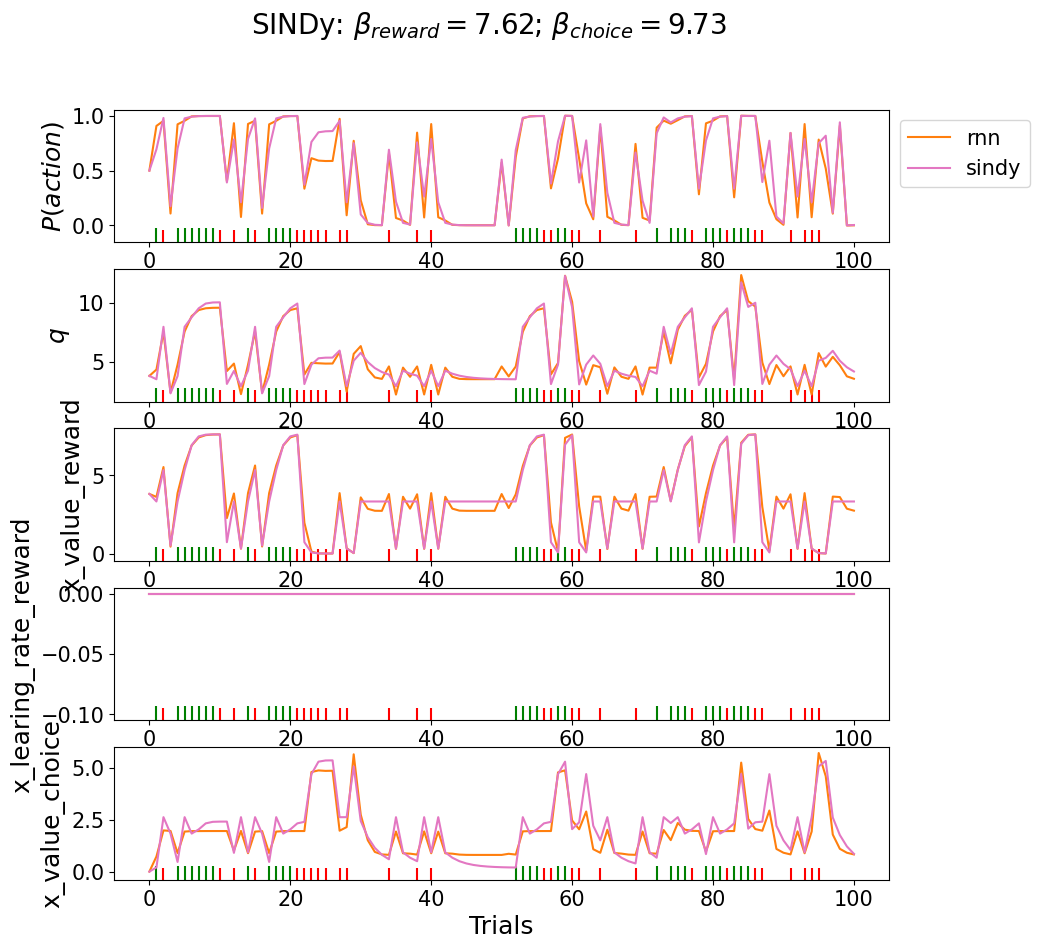

In [6]:
### SINDy
from spice import pipeline_sindy

agent_spice, features, sindy_loss = pipeline_sindy.main(
    class_rnn=class_rnn,
    model = path_model,
    data = path_data,
    additional_inputs_data=additional_inputs,
    save = True,
    
    # general recovery parameters
    participant_id=None,
    filter_bad_participants=False,
    use_optuna=True,
    pruning=False,
    
    # sindy parameters
    train_test_ratio=train_test_ratio,
    polynomial_degree=3,
    optimizer_alpha=0.1,
    optimizer_threshold=0.05, # 0.05
    n_trials_off_policy=1000,
    n_sessions_off_policy=1,
    n_trials_same_action_off_policy=5,
    optuna_threshold=0.1, # 0.1
    optuna_n_trials=50, # 50
    optimizer_type='SR3_weighted_l1',  # 'STLSQ',  'SR3_weighted_l1'
    # optimizer_type='SR3_L1',
    verbose=False,
    
    # generated training dataset parameters
    n_actions=2,
    sigma=0.2,
    beta_reward=1.,
    alpha=0.25,
    alpha_penalty=0.25,
    forget_rate=0.,
    confirmation_bias=0.,
    beta_choice=1.,
    alpha_choice=1.,
    counterfactual=False,
    alpha_counterfactual=0.,
    
    analysis=True,
    get_loss=False,
    
    **sindy_config,
)

In [7]:
# # Model analysis
# if dataset == 'eckstein2022':
#     # ------------------- CONFIGURATION ECKSTEIN2022 w/o AGE --------------------
#     study = 'eckstein2022'
#     models_benchmark = ['ApAnBrBcfBch']#['ApBr', 'ApBrAcfpBcf', 'ApBrAcfpBcfBch', 'ApAnBrBch', 'ApAnBrAcfpAcfnBcfBch', 'ApAnBrBcfBch']
#     train_test_ratio = 0.8
#     sindy_config = sindy_utils.SindyConfig_eckstein2022
#     rnn_class = rnn.RLRNN_eckstein2022
#     additional_inputs = None
#     setup_agent_benchmark = benchmarking_eckstein2022.setup_agent_benchmark
#     rl_model = benchmarking_eckstein2022.rl_model
#     benchmark_file = f'mcmc_{study}_MODEL.nc'
#     model_config_baseline = 'ApBr'
#     baseline_file = f'mcmc_{study}_ApBr.nc'

# elif dataset == 'dezfouli2019':
#     # ------------------------ CONFIGURATION DEZFOULI2019 -----------------------
#     study = 'dezfouli2019'
#     train_test_ratio = [3, 6, 9]
#     models_benchmark = ['PhiChiBetaKappaC']
#     sindy_config = sindy_utils.SindyConfig_dezfouli2019
#     rnn_class = rnn.RLRNN_dezfouli2019
#     additional_inputs = []
#     # setup_agent_benchmark = benchmarking_dezfouli2019.setup_agent_benchmark
#     # gql_model = benchmarking_dezfouli2019.gql_model
#     setup_agent_benchmark = benchmarking_dezfouli2019.setup_agent_gql
#     gql_model = benchmarking_dezfouli2019.Dezfouli2019GQL
#     benchmark_file = f'gql_{study}_MODEL.pkl'
#     model_config_baseline = 'PhiBeta'
#     baseline_file = f'gql_{study}_PhiBeta.pkl'

# # ------------------------- CONFIGURATION FILE PATHS ------------------------
# use_test = True

# path_data = f'data/{study}/{study}.csv'
# path_model_rnn = path_model
# path_model_spice = path_model.replace('_rnn.pkl', '_spice.pkl')
# path_model_baseline = None
# path_model_benchmark = None

# dataset = convert_dataset(path_data, additional_inputs=additional_inputs)[0]
# # use these participant_ids if not defined later
# participant_ids = dataset.xs[:, 0, -1].unique().cpu().numpy()

